# Real Estate Rental Yield Prediction Analysis V2

This notebook presents a comprehensive analysis of real estate rental yield prediction using machine learning techniques. We'll analyze property data from Paris to predict rental yields and identify investment opportunities.

## 1. Introduction

### 1.1 Project Overview

The goal of this project is to develop a smart, data-driven tool that evaluates real estate listings to estimate potential rental yield. The tool will use data from properties for sale, long-term rentals, and short-term (Airbnb-style) listings to identify investment-worthy opportunities.

### 1.2 Data Sources

We'll use the following datasets:

1. **AD08FR31096_seloger_apartments_flattened.csv**: Apartments for sale in Paris, encoded in French.
2. **AD08FR31096_seloger_properties_flattenedbatch1.csv**: Flat data with detailed property information.
3. **AD08FR31096_seloger_properties_flattenedbatch2.csv**: Properties for rent with detailed information.
4. **AD08FR31096_seloger_properties_flattenedbatch3.csv**: Approximately 5,000 properties for sale with detailed information.
5. **InsideAirbnb Paris Data**: Short-term rental data from InsideAirbnb for Paris.

### 1.3 Approach

We'll follow these steps:

1. Data loading and exploration
2. Data cleaning and preprocessing
3. Feature engineering
4. Model training and optimization
5. Model evaluation
6. Investment opportunity identification

## 2. Data Loading and Exploration

Let's start by loading and exploring the datasets.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
def load_dataset(file_path, dataset_name):
    """Load and preprocess a dataset.

    Args:
        file_path: Path to the dataset file
        dataset_name: Name of the dataset for display purposes

    Returns:
        Preprocessed DataFrame
    """
    print(f"Loading {dataset_name} dataset...")

    try:
        # Determine file extension
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path, low_memory=False)
        elif file_path.endswith('.xls') or file_path.endswith('.xlsx'):
            df = pd.read_excel(file_path)
        else:
            print(f"Unsupported file format: {file_path}")
            return None

        print(f"Successfully loaded {dataset_name} dataset with shape: {df.shape}")

        # Basic preprocessing
        # Convert column names to lowercase and replace spaces with underscores
        df.columns = [col.lower().replace(' ', '_') for col in df.columns]

        # Handle common preprocessing tasks
        if 'price' in df.columns:
            # Ensure price is numeric
            df['price'] = pd.to_numeric(df['price'], errors='coerce')

        if 'surface' in df.columns:
            # Ensure surface is numeric
            df['surface'] = pd.to_numeric(df['surface'], errors='coerce')

            # Calculate price per square meter if both price and surface are available
            if 'price' in df.columns:
                df['price_per_sqm'] = df['price'] / df['surface']

        # Extract postal code if available
        postal_code_columns = [col for col in df.columns if 'postal' in col or 'zip' in col]
        if postal_code_columns:
            postal_col = postal_code_columns[0]
            if 'postal_code' not in df.columns:
                df['postal_code'] = df[postal_col]

        return df

    except Exception as e:
        print(f"Error loading {dataset_name} dataset: {e}")
        return None

In [ ]:
# Load datasets
df_apartments = load_dataset('AD08FR31096_seloger_apartments_flattened.csv', 'Apartments')
df_properties_batch1 = load_dataset('AD08FR31096_seloger_properties_flattened batch1.csv', 'Properties Batch 1')
df_properties_batch2 = load_dataset('AD08FR31096_seloger_properties_flattened batch2.csv', 'Properties Batch 2')
df_properties_batch3 = load_dataset('AD08FR31096_seloger_properties_flattened batch3.csv', 'Properties Batch 3')

Loading Apartments dataset...
Successfully loaded Apartments dataset with shape: (10597, 42)
Loading Properties Batch 1 dataset...
Successfully loaded Properties Batch 1 dataset with shape: (544, 74)
Loading Properties Batch 2 dataset...
Successfully loaded Properties Batch 2 dataset with shape: (737, 74)
Loading Properties Batch 3 dataset...
Successfully loaded Properties Batch 3 dataset with shape: (4809, 74)


In [ ]:
# Function to download and load Airbnb data
def load_airbnb_data():
    """Download and load Airbnb data for Paris from InsideAirbnb."""
    print("Loading Airbnb data for Paris...")

    try:
        # Download the data
        !wget -q http://data.insideairbnb.com/france/ile-de-france/paris/2023-12-12/data/listings.csv.gz -O airbnb_listings.csv.gz
        !gunzip -f airbnb_listings.csv.gz

        # Load the data
        df_airbnb = pd.read_csv('airbnb_listings.csv', low_memory=False)
        print(f"Successfully loaded Airbnb data with shape: {df_airbnb.shape}")

        # Basic preprocessing
        df_airbnb.columns = [col.lower().replace(' ', '_') for col in df_airbnb.columns]

        # Extract key columns
        if 'price' in df_airbnb.columns:
            # Clean price column (remove $ and convert to numeric)
            df_airbnb['price'] = df_airbnb['price'].str.replace('$', '').str.replace(',', '').astype(float)

        return df_airbnb

    except Exception as e:
        print(f"Error loading Airbnb data: {e}")
        print("Creating a sample Airbnb dataset instead...")

        # Create a sample dataset
        df_airbnb = pd.DataFrame({
            'id': range(1000),
            'name': [f'Listing {i}' for i in range(1000)],
            'host_id': np.random.randint(1, 500, 1000),
            'host_name': [f'Host {i}' for i in range(1000)],
            'neighbourhood': np.random.choice(['Marais', 'Montmartre', 'Latin Quarter', 'Eiffel Tower', 'Champs-Élysées'], 1000),
            'latitude': np.random.uniform(48.8, 48.9, 1000),
            'longitude': np.random.uniform(2.3, 2.4, 1000),
            'room_type': np.random.choice(['Entire home/apt', 'Private room', 'Shared room'], 1000),
            'price': np.random.uniform(50, 300, 1000),
            'minimum_nights': np.random.randint(1, 7, 1000),
            'number_of_reviews': np.random.randint(0, 100, 1000),
            'reviews_per_month': np.random.uniform(0, 5, 1000),
            'availability_365': np.random.randint(0, 365, 1000),
            'number_of_reviews_ltm': np.random.randint(0, 50, 1000),
            'license': np.random.choice([None, 'Licensed'], 1000),
        })

        print(f"Created sample Airbnb dataset with shape: {df_airbnb.shape}")
        return df_airbnb

In [ ]:
# Load Airbnb data
df_airbnb_listings = load_airbnb_data()

Loading Airbnb data for Paris...
Successfully loaded Airbnb data with shape: (74329, 75)


### 2.1 Explore Apartments Dataset

In [ ]:
# Function to explore dataset
def explore_dataset(df, dataset_name):
    """Explore a dataset and print summary statistics.

    Args:
        df: Pandas DataFrame to explore
        dataset_name: Name of the dataset for display purposes
    """
    if df is None:
        print(f"{dataset_name} dataset is not available for exploration.")
        return

    print(f"\nExploring {dataset_name} dataset:")
    print(f"Shape: {df.shape}")

    # Display column information
    print("\nColumn information:")
    column_info = pd.DataFrame({
        'Column': df.columns,
        'Type': df.dtypes,
        'Non-Null Count': df.count(),
        'Null Count': df.isna().sum(),
        'Null Percentage': (df.isna().sum() / len(df) * 100).round(2)
    })
    display(column_info)

    # Display summary statistics for numeric columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_cols) > 0:
        print("\nSummary statistics for numeric columns:")
        display(df[numeric_cols].describe())

    # Display value counts for categorical columns (top 5 categories)
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        print("\nValue counts for categorical columns (top 5 categories):")
        for col in categorical_cols[:5]:  # Limit to first 5 categorical columns
            print(f"\n{col}:")
            display(df[col].value_counts().head())

    # Check for key columns
    key_columns = ['price', 'surface', 'postal_code']
    for col in key_columns:
        if col in df.columns:
            print(f"\n{col} statistics:")
            if df[col].dtype in ['int64', 'float64']:
                print(f"Min: {df[col].min()}, Max: {df[col].max()}, Mean: {df[col].mean()}, Median: {df[col].median()}")
            else:
                print(f"Data type: {df[col].dtype}, Unique values: {df[col].nunique()}")

    # Calculate price per square meter if both price and surface are available
    if 'price' in df.columns and 'surface' in df.columns:
        if 'price_per_sqm' not in df.columns:
            df['price_per_sqm'] = df['price'] / df['surface']

        print("\nPrice per square meter statistics:")
        price_per_sqm = df['price_per_sqm'].dropna()
        print(f"Min: {price_per_sqm.min()}, Max: {price_per_sqm.max()}, Mean: {price_per_sqm.mean()}, Median: {price_per_sqm.median()}")

In [ ]:
explore_dataset(df_apartments, "Apartments")


Exploring Apartments dataset:
Shape: (10597, 43)

Column information:


Column     Type  \
id                                                    id   object   
url                                                  url   object   
has3_d_visit                                has3_d_visit     bool   
is_exclusive                                is_exclusive     bool   
has_brokerage_fee                      has_brokerage_fee     bool   
type                                                type   object   
brand                                              brand   object   
portal                                            portal   object   
status                                            status   object   
image_urls                                    image_urls   object   
virtual_tours_available          virtual_tours_available   object   
floorplans_available                floorplans_available   object   
city                                                city   object   
country                                          country   object   
district                                        district   object   
zip_code                                        zip_code    int64   
update_date                                  update_date   object   
creation_date                              creation_date   object   
provider_rating                          provider_rating  float64   
provider_reviews                        provider_reviews  float64   
provider_address                        provider_address   object   
provider_website                        provider_website   object   
provider_phone_numbers            provider_phone_numbers   object   
agency_name                                  agency_name   object   
agency_logo_url                          agency_logo_url   object   
agency_legal_information        agency_legal_information   object   
price                                              price  float64   
number_of_rooms                          number_of_rooms  float64   
main_surface_sqm                        main_surface_sqm  float64   
number_of_bedrooms                    number_of_bedrooms  float64   
property_type                              property_type   object   
distribution_type                      distribution_type   object   
formatted_price                          formatted_price   object   
price_per_sqm                              price_per_sqm   object   
number_of_rooms_hardfact        number_of_rooms_hardfact   object   
number_of_bedrooms_hardfact  number_of_bedrooms_hardfact   object   
living_space_sqm_hardfact      living_space_sqm_hardfact   object   
floor_info                                    floor_info   object   
energy_class                                energy_class   object   
headline                                        headline   object   
full_description                        full_description   object   
year_of_construction                year_of_construction  float64   
postal_code                                  postal_code    int64   

                             Non-Null Count  Null Count  Null Percentage  
id                                    10597           0             0.00  
url                                   10597           0             0.00  
has3_d_visit                          10597           0             0.00  
is_exclusive                          10597           0             0.00  
has_brokerage_fee                     10597           0             0.00  
type                                  10597           0             0.00  
brand                                 10597           0             0.00  
portal                                10597           0             0.00  
status                                10597           0             0.00  
image_urls                            10597           0             0.00  
virtual_tours_available                3768        6829            64.44  
floorplans_available                   3768        6829            64.44  
city                                  


Summary statistics for numeric columns:


zip_code  provider_rating  provider_reviews       price  \
count  10597.00          5456.00           5456.00    10596.00   
mean   76293.56             4.82             55.57   938061.31   
std     8025.39             0.23             67.08  1150224.73   
min       75.00             1.00              1.00        0.00   
25%    75010.00             4.73             16.00   378000.00   
50%    75015.00             4.87             36.00   619000.00   
75%    75018.00             5.00             74.00  1085000.00   
max   750220.00             5.00            726.00 32000000.00   

       number_of_rooms  main_surface_sqm  number_of_bedrooms  \
count         10568.00          10571.00             8581.00   
mean              3.06             74.56                2.07   
std               1.85             64.80                1.10   
min               1.00              5.00                1.00   
25%               2.00             37.00                1.00   
50%               3.00             60.00                2.00   
75%               4.00             94.00                3.00   
max              90.00           3200.00               19.00   

       year_of_construction  postal_code  
count               6851.00     10597.00  
mean                1911.40     76293.56  
std                  109.51      8025.39  
min                    1.00        75.00  
25%                 1890.00     75010.00  
50%                 1910.00     75015.00  
75%                 1963.00     75018.00  
max                 5731.00    750220.00


Value counts for categorical columns (top 5 categories):

id:


id
25S3KDLFJEZ9    1
25PRU1C3CZN8    1
25QYTWY5ZV7I    1
25EVPZNE2Y8E    1
251QR2XSKMUH    1
Name: count, dtype: int64


url:


url
https://www.seloger.com/annonces/achat/appartement/paris-17eme-75/batignolles-cardinet/242005813.htm            1
https://www.seloger.com/annonces/achat/appartement/paris-19eme-75/flandre-aubervilliers/242324479.htm           1
https://www.seloger.com/annonces/achat/appartement/paris-11eme-75/nation-alexandre-dumas/241687639.htm          1
https://www.seloger.com/annonces/achat/appartement/paris-18eme-75/amiraux-simplon-poissonniers/242388175.htm    1
https://www.seloger.com/annonces/achat/appartement/paris-11eme-75/bastille-popincourt/242773381.htm             1
Name: count, dtype: int64


type:


type
PROFESSIONAL    10597
Name: count, dtype: int64


brand:


brand
seloger    10597
Name: count, dtype: int64


portal:


portal
seloger              7775
bellesdemeures       2260
selogerneuf           559
selogerconstruire       3
Name: count, dtype: int64


price statistics:
Min: 0.0, Max: 32000000.0, Mean: 938061.3140883353, Median: 619000.0

postal_code statistics:
Min: 75, Max: 750220, Mean: 76293.55808247617, Median: 75015.0


### 2.2 Explore Properties Datasets

In [ ]:
# Explore properties batch 1 dataset
explore_dataset(df_properties_batch1, "Properties Batch 1")


Exploring Properties Batch 1 dataset:
Shape: (544, 75)

Column information:


Column  \
listing_id                                                  listing_id   
seo_title                                                    seo_title   
seo_canonical_url                                    seo_canonical_url   
seo_description                                        seo_description   
has3_d_visit                                              has3_d_visit   
is_exclusive                                              is_exclusive   
has_brokerage_fee                                    has_brokerage_fee   
brand                                                            brand   
metadata_status                                        metadata_status   
metadata_legacy_id                                  metadata_legacy_id   
metadata_update_date                              metadata_update_date   
metadata_creation_date                          metadata_creation_date   
metadata_is_new_build_project            metadata_is_new_build_project   
key_identifier                                          key_identifier   
key_reference_annonce                            key_reference_annonce   
price_value                                                price_value   
price_per_sqm_value                                price_per_sqm_value   
price_type                                                  price_type   
estimated_notary_fees                            estimated_notary_fees   
estimated_project_amount                      estimated_project_amount   
estimated_energy_bill                            estimated_energy_bill   
energy_year_of_construction                energy_year_of_construction   
energy_heating_system                            energy_heating_system   
energy_source                                            energy_source   
image_count                                                image_count   
image_urls                                                  image_urls   
has_living_room_image                            has_living_room_image   
has_kitchen_image                                    has_kitchen_image   
has_bathroom_image                                  has_bathroom_image   
has_bedroom_image                                    has_bedroom_image   
has_exterior_image                                  has_exterior_image   
general_info_orientation                      general_info_orientation   
general_info_furnished                          general_info_furnished   
general_info_floor_info                        general_info_floor_info   
interior_kitchen_type                            interior_kitchen_type   
interior_bathroom_amenities                interior_bathroom_amenities   
interior_toilet_amenities                    interior_toilet_amenities   
interior_bedroom_count                          interior_bedroom_count   
exterior_view_type                                  exterior_view_type   
not_included_elevator                            not_included_elevator   
not_included_balcony                              not_included_balcony   
not_included_cellar                                not_included_cellar   
location_city                                            location_city   
location_country                                      location_country   
location_district                                    location_district   
location_zip_code                                    location_zip_code   
location_latitude                                    location_latitude   
location_longitude                                  location_longitude   
location_is_address_published            location_is_address_published   
mortgage_monthly_amount                        mortgage_monthly_amount   
mortgage_region                                        mortgage_region   
mortgage_federal_state_geo_id            mortgage_federal_state_geo_id   
mortgage_show_monthly_rate_label      mortgage_show_monthly_rate_label   
hard_facts_number_of_rooms                  hard_facts_number_of_roo


Summary statistics for numeric columns:


metadata_legacy_id  key_identifier  price_value  price_per_sqm_value  \
count              544.00          544.00       544.00               543.00   
mean         238975572.60    238975572.60    672492.07             10632.62   
std            5785739.40      5785739.40    699166.74              3256.59   
min          193599471.00    193599471.00     73170.00              2090.57   
25%          237924536.00    237924536.00    383750.00              8718.15   
50%          240488628.00    240488628.00    549000.00             10279.41   
75%          242051722.00    242051722.00    750000.00             12192.98   
max          242901255.00    242901255.00   8995000.00             33943.40   

       estimated_notary_fees  estimated_project_amount  estimated_energy_bill  \
count                 544.00                    544.00                 370.00   
mean                53799.37                 726291.44                1222.18   
std                 55933.34                 755100.08                 736.61   
min                  5854.00                  79024.00                  65.00   
25%                 30700.00                 414450.00                 702.50   
50%                 43920.00                 592920.00                1070.00   
75%                 60000.00                 810000.00                1496.75   
max                719600.00                9714600.00                6660.00   

       energy_year_of_construction  image_count  general_info_orientation  \
count                       371.00       544.00                      0.00   
mean                       1921.75        11.16                       NaN   
std                          57.49         4.43                       NaN   
min                        1600.00         1.00                       NaN   
25%                        1900.00         8.00                       NaN   
50%                        1926.00        11.00                       NaN   
75%                        1970.00        14.00                       NaN   
max                        2025.00        33.00                       NaN   

       general_info_furnished  general_info_floor_info  interior_kitchen_type  \
count                    0.00                     0.00                   0.00   
mean                      NaN                      NaN                    NaN   
std                       NaN                      NaN                    NaN   
min                       NaN                      NaN                    NaN   
25%                       NaN                      NaN                    NaN   
50%                       NaN                      NaN                    NaN   
75%                       NaN                      NaN                    NaN   
max                       NaN                      NaN                    NaN   

       interior_bathroom_amenities  interior_toilet_amenities  \
count                         0.00                       0.00   
mean                           NaN                        NaN   
std                            NaN                        NaN   
min                            NaN                        NaN   
25%                            NaN                        NaN   
50%                            NaN                        NaN   
75%                            NaN                        NaN   
max                            NaN                        NaN   

       interior_bedroom_count  exterior_view_type  not_included_elevator  \
count                    0.00                0.00                   0.00   
mean                      NaN                 NaN                    NaN   
std                       NaN                 NaN                    NaN   
min                       NaN                 NaN                    NaN   
25%                       NaN                 NaN                    NaN   
50%                       NaN                 NaN                    NaN   
75%                    


Value counts for categorical columns (top 5 categories):

listing_id:


listing_id
25LDK1YEFGQQ    1
25NX3KGUW5RA    1
25PFLT1RG6AU    1
25IKYQVXDM4A    1
254FEKFRC3P7    1
Name: count, dtype: int64


seo_title:


seo_title
Appartement À  vendre 2 pièces 35.02 mÂ² 300000 â¬  Porte Saint Denis-Paradis Paris (75010)    2
Appartement À  vendre 4 pièces 93.14 mÂ² 769000 â¬ Paris (75015)                               2
Appartement À  vendre 1 pièce 16 mÂ² 195000 â¬  Pasteur Montparnasse Paris (75015)             1
Appartement À  vendre 3 pièces 59.72 mÂ² 750000 â¬ Paris (75008)                               1
Appartement À  vendre 3 pièces 51 mÂ² 590000 â¬  Batignolles-Cardinet Paris (75017)            1
Name: count, dtype: int64


seo_canonical_url:


seo_canonical_url
https://www.seloger.com/annonces/achat/appartement/boulogne-billancourt-92/242767815.htm                  1
https://www.seloger.com/annonces/achat/appartement/bagnolet-93/plateau-gambetta/242761569.htm             1
https://www.seloger.com/annonces/achat/appartement/paris-2eme-75/montorgueil-saint-denis/242761539.htm    1
https://www.seloger.com/annonces/achat/appartement/paris-17eme-75/pereire-malesherbes/242759503.htm       1
https://www.seloger.com/annonces/achat/appartement/paris-12eme-75/nation-picpus/242748705.htm             1
Name: count, dtype: int64


seo_description:


seo_description
Appartement À  vendre 2 pièces 35.02 mÂ² 300000 â¬  Porte Saint Denis-Paradis Paris (75010)    2
Appartement À  vendre 4 pièces 93.14 mÂ² 769000 â¬ Paris (75015)                               2
Appartement À  vendre 1 pièce 16 mÂ² 195000 â¬  Pasteur Montparnasse Paris (75015)             1
Appartement À  vendre 3 pièces 59.72 mÂ² 750000 â¬ Paris (75008)                               1
Appartement À  vendre 3 pièces 51 mÂ² 590000 â¬  Batignolles-Cardinet Paris (75017)            1
Name: count, dtype: int64


brand:


brand
seloger    544
Name: count, dtype: int64


postal_code statistics:
Min: 75001, Max: 93400, Mean: 77431.67095588235, Median: 75015.0


In [ ]:
explore_dataset(df_properties_batch2, "Properties Batch 2")


Exploring Properties Batch 2 dataset:
Shape: (737, 75)

Column information:


Column  \
listing_id                                                  listing_id   
seo_title                                                    seo_title   
seo_canonical_url                                    seo_canonical_url   
seo_description                                        seo_description   
has3_d_visit                                              has3_d_visit   
is_exclusive                                              is_exclusive   
has_brokerage_fee                                    has_brokerage_fee   
brand                                                            brand   
metadata_status                                        metadata_status   
metadata_legacy_id                                  metadata_legacy_id   
metadata_update_date                              metadata_update_date   
metadata_creation_date                          metadata_creation_date   
metadata_is_new_build_project            metadata_is_new_build_project   
key_identifier                                          key_identifier   
key_reference_annonce                            key_reference_annonce   
price_value                                                price_value   
price_per_sqm_value                                price_per_sqm_value   
price_type                                                  price_type   
estimated_notary_fees                            estimated_notary_fees   
estimated_project_amount                      estimated_project_amount   
estimated_energy_bill                            estimated_energy_bill   
energy_year_of_construction                energy_year_of_construction   
energy_heating_system                            energy_heating_system   
energy_source                                            energy_source   
dpe_efficiency_class_rating                dpe_efficiency_class_rating   
dpe_ghg_efficiency_class_rating        dpe_ghg_efficiency_class_rating   
image_count                                                image_count   
image_urls                                                  image_urls   
has_living_room_image                            has_living_room_image   
has_kitchen_image                                    has_kitchen_image   
has_bathroom_image                                  has_bathroom_image   
has_bedroom_image                                    has_bedroom_image   
has_exterior_image                                  has_exterior_image   
general_info_orientation                      general_info_orientation   
general_info_furnished                          general_info_furnished   
general_info_floor_info                        general_info_floor_info   
interior_kitchen_type                            interior_kitchen_type   
interior_bathroom_amenities                interior_bathroom_amenities   
interior_toilet_amenities                    interior_toilet_amenities   
interior_bedroom_count                          interior_bedroom_count   
exterior_view_type                                  exterior_view_type   
not_included_elevator                            not_included_elevator   
not_included_balcony                              not_included_balcony   
not_included_cellar                                not_included_cellar   
location_city                                            location_city   
location_country                                      location_country   
location_district                                    location_district   
location_zip_code                                    location_zip_code   
location_latitude                                    location_latitude   
location_longitude                                  location_longitude   
location_is_address_published            location_is_address_published   
mortgage_monthly_amount                        mortgage_monthly_amount   
mortgage_region                                        mortgage_region   
mortgage_federal_state_geo_id            mortgage_federal_state_geo_


Summary statistics for numeric columns:


metadata_legacy_id  key_identifier  price_value  price_per_sqm_value  \
count              737.00          737.00       737.00               733.00   
mean         238163715.51    238163715.51      1936.53                41.24   
std           14000274.86     14000274.86      1706.20                12.97   
min           91160173.00     91160173.00       550.00                14.62   
25%          239964399.00    239964399.00      1015.00                32.52   
50%          242246483.00    242246483.00      1525.00                38.73   
75%          242654585.00    242654585.00      2200.00                45.38   
max          242959751.00    242959751.00     19200.00               122.73   

       estimated_notary_fees  estimated_project_amount  estimated_energy_bill  \
count                   0.00                      0.00                 173.00   
mean                     NaN                       NaN                 962.98   
std                      NaN                       NaN                 553.56   
min                      NaN                       NaN                   1.00   
25%                      NaN                       NaN                 607.00   
50%                      NaN                       NaN                 820.00   
75%                      NaN                       NaN                1230.00   
max                      NaN                       NaN                3220.00   

       energy_year_of_construction  image_count  general_info_orientation  \
count                       293.00       737.00                      0.00   
mean                       1922.33        10.55                       NaN   
std                          63.21         5.54                       NaN   
min                        1500.00         1.00                       NaN   
25%                        1900.00         6.00                       NaN   
50%                        1920.00         9.00                       NaN   
75%                        1970.00        13.00                       NaN   
max                        2025.00        53.00                       NaN   

       general_info_furnished  general_info_floor_info  interior_kitchen_type  \
count                    0.00                     0.00                   0.00   
mean                      NaN                      NaN                    NaN   
std                       NaN                      NaN                    NaN   
min                       NaN                      NaN                    NaN   
25%                       NaN                      NaN                    NaN   
50%                       NaN                      NaN                    NaN   
75%                       NaN                      NaN                    NaN   
max                       NaN                      NaN                    NaN   

       interior_bathroom_amenities  interior_toilet_amenities  \
count                         0.00                       0.00   
mean                           NaN                        NaN   
std                            NaN                        NaN   
min                            NaN                        NaN   
25%                            NaN                        NaN   
50%                            NaN                        NaN   
75%                            NaN                        NaN   
max                            NaN                        NaN   

       interior_bedroom_count  exterior_view_type  not_included_elevator  \
count                    0.00                0.00                   0.00   
mean                      NaN                 NaN                    NaN   
std                       NaN                 NaN                    NaN   
min                       NaN                 NaN                    NaN   
25%                       NaN                 NaN                    NaN   
50%                       NaN                 NaN                    NaN   
75%                    


Value counts for categorical columns (top 5 categories):

listing_id:


listing_id
25T76FEEZ27A    1
25ES1XDCNYMM    1
258X3ZNNHZ86    1
25IW8CQYLRTW    1
252AQXXSAE11    1
Name: count, dtype: int64


seo_title:


seo_title
Appartement À  louer 1 pièce 28 mÂ² 990 â¬ Paris (75017)                                       2
Appartement À  louer 1 pièce 27 mÂ² 1190 â¬ Paris (75016)                                      2
Appartement À  louer 1 pièce 28 mÂ² 1200 â¬ Paris (75017)                                      2
Appartement À  louer 2 pièces 48 mÂ² 1814 â¬  Sentier-Bonne Nouvelle Paris (75002)             2
Appartement À  louer 2 pièces 30 mÂ² 1350 â¬  Centre Administratif-Mairie Montrouge (92120)    2
Name: count, dtype: int64


seo_canonical_url:


seo_canonical_url
https://www.seloger.com/annonces/locations/appartement/paris-17eme-75/champerret-berthier/241786901.htm    1
https://www.seloger.com/annonces/locations/appartement/paris-19eme-75/242850371.htm                        1
https://www.seloger.com/annonces/locations/appartement/paris-16eme-75/porte-dauphine/242829119.htm         1
https://www.seloger.com/annonces/locations/appartement/paris-17eme-75/242881655.htm                        1
https://www.seloger.com/annonces/locations/appartement/paris-18eme-75/242883291.htm                        1
Name: count, dtype: int64


seo_description:


seo_description
Appartement À  louer 1 pièce 28 mÂ² 990 â¬ Paris (75017)                                       2
Appartement À  louer 1 pièce 27 mÂ² 1190 â¬ Paris (75016)                                      2
Appartement À  louer 1 pièce 28 mÂ² 1200 â¬ Paris (75017)                                      2
Appartement À  louer 2 pièces 48 mÂ² 1814 â¬  Sentier-Bonne Nouvelle Paris (75002)             2
Appartement À  louer 2 pièces 30 mÂ² 1350 â¬  Centre Administratif-Mairie Montrouge (92120)    2
Name: count, dtype: int64


brand:


brand
seloger    737
Name: count, dtype: int64


postal_code statistics:
Min: 75001, Max: 93500, Mean: 76297.61736770692, Median: 75015.0


In [ ]:
# Explore properties batch 3 dataset
explore_dataset(df_properties_batch3, "Properties Batch 3")


Exploring Properties Batch 3 dataset:
Shape: (4809, 75)

Column information:


Column  \
listing_id                                                  listing_id   
seo_title                                                    seo_title   
seo_canonical_url                                    seo_canonical_url   
seo_description                                        seo_description   
has3_d_visit                                              has3_d_visit   
is_exclusive                                              is_exclusive   
has_brokerage_fee                                    has_brokerage_fee   
brand                                                            brand   
metadata_status                                        metadata_status   
metadata_legacy_id                                  metadata_legacy_id   
metadata_update_date                              metadata_update_date   
metadata_creation_date                          metadata_creation_date   
metadata_is_new_build_project            metadata_is_new_build_project   
key_identifier                                          key_identifier   
key_reference_annonce                            key_reference_annonce   
price_value                                                price_value   
price_per_sqm_value                                price_per_sqm_value   
price_type                                                  price_type   
estimated_notary_fees                            estimated_notary_fees   
estimated_project_amount                      estimated_project_amount   
estimated_energy_bill                            estimated_energy_bill   
energy_year_of_construction                energy_year_of_construction   
energy_heating_system                            energy_heating_system   
energy_source                                            energy_source   
image_count                                                image_count   
image_urls                                                  image_urls   
has_living_room_image                            has_living_room_image   
has_kitchen_image                                    has_kitchen_image   
has_bathroom_image                                  has_bathroom_image   
has_bedroom_image                                    has_bedroom_image   
has_exterior_image                                  has_exterior_image   
general_info_orientation                      general_info_orientation   
general_info_furnished                          general_info_furnished   
general_info_floor_info                        general_info_floor_info   
interior_kitchen_type                            interior_kitchen_type   
interior_bathroom_amenities                interior_bathroom_amenities   
interior_toilet_amenities                    interior_toilet_amenities   
interior_bedroom_count                          interior_bedroom_count   
exterior_view_type                                  exterior_view_type   
not_included_elevator                            not_included_elevator   
not_included_balcony                              not_included_balcony   
not_included_cellar                                not_included_cellar   
location_city                                            location_city   
location_country                                      location_country   
location_district                                    location_district   
location_zip_code                                    location_zip_code   
location_latitude                                    location_latitude   
location_longitude                                  location_longitude   
location_is_address_published            location_is_address_published   
mortgage_monthly_amount                        mortgage_monthly_amount   
mortgage_region                                        mortgage_region   
mortgage_federal_state_geo_id            mortgage_federal_state_geo_id   
mortgage_show_monthly_rate_label      mortgage_show_monthly_rate_label   
hard_facts_number_of_rooms                  hard_facts_number_of_roo


Summary statistics for numeric columns:


metadata_legacy_id  key_identifier  price_value  price_per_sqm_value  \
count             4760.00         4760.00      4759.00              4744.00   
mean         239739694.05    239739694.05    638738.02             10640.17   
std            5571196.86      5571196.86    620205.24              2927.46   
min          130371401.00    130371401.00     31000.00              1703.92   
25%          239362429.00    239362429.00    335000.00              8878.15   
50%          241707969.00    241707969.00    499200.00             10276.45   
75%          242458422.50    242458422.50    749450.00             12000.00   
max          242950665.00    242950665.00  11396000.00             41860.47   

       estimated_notary_fees  estimated_project_amount  estimated_energy_bill  \
count                4752.00                   4752.00                2827.00   
mean                50820.78                 686080.51                1384.54   
std                 48268.94                 651630.73               10910.34   
min                  2480.00                  33480.00                   1.00   
25%                 26800.00                 361800.00                 710.00   
50%                 39920.00                 538920.00                1030.00   
75%                 59920.00                 808920.00                1450.00   
max                911680.00               12307680.00              580000.00   

       energy_year_of_construction  image_count  general_info_orientation  \
count                      3153.00      4809.00                      0.00   
mean                       1916.36         9.89                       NaN   
std                         120.82         4.49                       NaN   
min                           2.00         0.00                       NaN   
25%                        1890.00         7.00                       NaN   
50%                        1914.00         9.00                       NaN   
75%                        1967.00        12.00                       NaN   
max                        5731.00        42.00                       NaN   

       general_info_furnished  general_info_floor_info  interior_kitchen_type  \
count                    0.00                     0.00                   0.00   
mean                      NaN                      NaN                    NaN   
std                       NaN                      NaN                    NaN   
min                       NaN                      NaN                    NaN   
25%                       NaN                      NaN                    NaN   
50%                       NaN                      NaN                    NaN   
75%                       NaN                      NaN                    NaN   
max                       NaN                      NaN                    NaN   

       interior_bathroom_amenities  interior_toilet_amenities  \
count                         0.00                       0.00   
mean                           NaN                        NaN   
std                            NaN                        NaN   
min                            NaN                        NaN   
25%                            NaN                        NaN   
50%                            NaN                        NaN   
75%                            NaN                        NaN   
max                            NaN                        NaN   

       interior_bedroom_count  exterior_view_type  not_included_elevator  \
count                    0.00                0.00                   0.00   
mean                      NaN                 NaN                    NaN   
std                       NaN                 NaN                    NaN   
min                       NaN                 NaN                    NaN   
25%                       NaN                 NaN                    NaN   
50%                       NaN                 NaN                    NaN   
75%                    


Value counts for categorical columns (top 5 categories):

listing_id:


listing_id
25TR3ZJL2RL3    1
2319RA7WFIXK    1
24JLT74DTRUQ    1
24DQ1UJEQCT9    1
24ZFY5D62T18    1
Name: count, dtype: int64


seo_title:


seo_title
Appartement À  vendre 2 pièces 42 mÂ² 570000 â¬  Bastille-Popincourt Paris (75011)             4
Appartement À  vendre 4 pièces 97 mÂ² 970000 â¬  Emeriau-Zola Paris (75015)                    3
Appartement À  vendre 4 pièces 83.5 mÂ² 885000 â¬  Nation-Picpus Paris (75012)                 3
Appartement À  vendre 3 pièces 46 mÂ² 380000 â¬  Amiraux-Simplon-Poissonniers Paris (75018)    3
Duplex À  vendre 3 pièces 60 mÂ² 760000 â¬ Paris (75009)                                       2
Name: count, dtype: int64


seo_canonical_url:


seo_canonical_url
https://www.seloger.com/annonces/achat/appartement/paris-7eme-75/gros-caillou/240765981.htm                    1
https://www.seloger.com/annonces/achat/appartement/suresnes-92/carnot-gambetta/193599471.htm                   1
https://www.seloger.com/annonces/achat/appartement/suresnes-92/carnot-gambetta/193605641.htm                   1
https://www.seloger.com/annonces/achat/appartement/paris-12eme-75/aligre-gare-de-lyon/194955727.htm            1
https://www.seloger.com/annonces/achat/appartement/paris-13eme-75/buttes-aux-cailles-glaciere/198551889.htm    1
Name: count, dtype: int64


seo_description:


seo_description
Appartement À  vendre 2 pièces 42 mÂ² 570000 â¬  Bastille-Popincourt Paris (75011)             4
Appartement À  vendre 4 pièces 97 mÂ² 970000 â¬  Emeriau-Zola Paris (75015)                    3
Appartement À  vendre 4 pièces 83.5 mÂ² 885000 â¬  Nation-Picpus Paris (75012)                 3
Appartement À  vendre 3 pièces 46 mÂ² 380000 â¬  Amiraux-Simplon-Poissonniers Paris (75018)    3
Duplex À  vendre 3 pièces 60 mÂ² 760000 â¬ Paris (75009)                                       2
Name: count, dtype: int64


has3_d_visit:


has3_d_visit
False    3908
True      852
Name: count, dtype: int64


postal_code statistics:
Min: 28230.0, Max: 94410.0, Mean: 76005.4161764706, Median: 75015.0


### 2.3 Explore Airbnb Dataset

In [ ]:
# Explore Airbnb listings dataset
explore_dataset(df_airbnb_listings, "Airbnb Listings")


Exploring Airbnb Listings dataset:
Shape: (74329, 75)

Column information:


Column  \
id                                                                                      id   
listing_url                                                                    listing_url   
scrape_id                                                                        scrape_id   
last_scraped                                                                  last_scraped   
source                                                                              source   
name                                                                                  name   
description                                                                    description   
neighborhood_overview                                                neighborhood_overview   
picture_url                                                                    picture_url   
host_id                                                                            host_id   
host_url                                                                          host_url   
host_name                                                                        host_name   
host_since                                                                      host_since   
host_location                                                                host_location   
host_about                                                                      host_about   
host_response_time                                                      host_response_time   
host_response_rate                                                      host_response_rate   
host_acceptance_rate                                                  host_acceptance_rate   
host_is_superhost                                                        host_is_superhost   
host_thumbnail_url                                                      host_thumbnail_url   
host_picture_url                                                          host_picture_url   
host_neighbourhood                                                      host_neighbourhood   
host_listings_count                                                    host_listings_count   
host_total_listings_count                                        host_total_listings_count   
host_verifications                                                      host_verifications   
host_has_profile_pic                                                  host_has_profile_pic   
host_identity_verified                                              host_identity_verified   
neighbourhood                                                                neighbourhood   
neighbourhood_cleansed                                              neighbourhood_cleansed   
neighbourhood_group_cleansed                                  neighbourhood_group_cleansed   
latitude                                                                          latitude   
longitude                                                                        longitude   
property_type                                                                property_type   
room_type                                                                        room_type   
accommodates                                                                  accommodates   
bathrooms                                                                        bathrooms   
bathrooms_text                                                              bathrooms_text   
bedrooms                                                                          bedrooms   
beds                                                                                  beds   
amenities                                                                        amenities   
price                                                                                price   
minimum_nights                                                              minimum_nights   
maximum_nights                            


Summary statistics for numeric columns:


id         scrape_id  description      host_id  \
count               74329.00          74329.00         0.00     74329.00   
mean   401631005033887744.00 20231212042736.00          NaN 152732829.29   
std    438572981342840768.00             14.46          NaN 176790819.15   
min                  3109.00 20231212042736.00          NaN       275.00   
25%              22382360.00 20231212042736.00          NaN  16906314.00   
50%              51398075.00 20231212042736.00          NaN  57243060.00   
75%    883913025424559872.00 20231212042736.00          NaN 268170436.00   
max   1044192462569643648.00 20231212042736.00          NaN 550398394.00   

       host_listings_count  host_total_listings_count  \
count             74320.00                   74320.00   
mean                 26.76                      37.50   
std                 101.59                     146.65   
min                   1.00                       1.00   
25%                   1.00                       1.00   
50%                   1.00                       2.00   
75%                   3.00                       5.00   
max                2822.00                    5516.00   

       neighbourhood_group_cleansed  latitude  longitude  accommodates  \
count                          0.00  74329.00   74329.00      74329.00   
mean                            NaN     48.86       2.34          3.13   
std                             NaN      0.02       0.03          1.64   
min                             NaN     48.82       2.22          1.00   
25%                             NaN     48.85       2.32          2.00   
50%                             NaN     48.87       2.35          2.00   
75%                             NaN     48.88       2.37          4.00   
max                             NaN     48.90       2.47         16.00   

       bathrooms  bedrooms     beds    price  minimum_nights  maximum_nights  \
count       0.00     35.00 73620.00 67108.00        74329.00        74329.00   
mean         NaN      2.54     1.75   221.16           57.05          703.08   
std          NaN      1.31     1.27   662.17          125.50        36681.61   
min          NaN      1.00     1.00     8.00            1.00            1.00   
25%          NaN      2.00     1.00    86.00            2.00           60.00   
50%          NaN      2.00     1.00   129.00            3.00          365.00   
75%          NaN      3.00     2.00   205.00            8.00         1125.00   
max          NaN      6.00    90.00 84420.00         1000.00     10000000.00   

       minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  \
count                74327.00                74327.00                74327.00   
mean                    56.48                   66.52               116312.28   
std                    125.29                  133.87             15753563.99   
min                      1.00                    1.00                    1.00   
25%                      1.00                    2.00                   56.00   
50%                      3.00                    4.00                  365.00   
75%                      7.00                   30.00                 1125.00   
max                   1000.00                 2400.00           2147483647.00   

       maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm  \
count                74327.00                74327.00                74327.00   
mean                203029.85                   59.91               202407.75   
std               20839561.08                  127.72             20778088.46   
min                      1.00                    1.00                    1.00   
25%                    120.00                    2.00                   99.00   
50%                    365.00                    3.00                  365.00   
75%                   1125.00                   17.50                 1125.00   
max             2147483647.00                 1000.00        


Value counts for categorical columns (top 5 categories):

listing_url:


listing_url
https://www.airbnb.com/rooms/1044192462569643662    1
https://www.airbnb.com/rooms/3109                   1
https://www.airbnb.com/rooms/5396                   1
https://www.airbnb.com/rooms/81106                  1
https://www.airbnb.com/rooms/7397                   1
Name: count, dtype: int64


last_scraped:


last_scraped
2023-12-13    42141
2023-12-12    21178
2023-12-14    11010
Name: count, dtype: int64


source:


source
city scrape        49555
previous scrape    24774
Name: count, dtype: int64


name:


name
Rental unit in Paris · 1 bedroom · 1 bed · 1 bath           6328
Rental unit in Paris · ★5.0 · 1 bedroom · 1 bed · 1 bath    2953
Rental unit in Paris · 1 bedroom · 2 beds · 1 bath          2584
Rental unit in Paris · ★New · 1 bedroom · 1 bed · 1 bath    2032
Rental unit in Paris · Studio · 1 bed · 1 bath              2025
Name: count, dtype: int64


neighborhood_overview:


neighborhood_overview
The 18th arrondissement is in the north of Paris and includes the districts of La Goutte d'Or and Montmartre. Montmartre is one of the highest mounds in Paris and the view of the summit is amazing. Montmartre became the neighborhood of many artists like Picasso, Dali, Duchamp, Toulouse-Lautrec and many others. The 18th arrondissement is therefore very contrasted, integrating ethnic blocks with a bourgeois sector or the opposite. Boulevard de Clichy, near Place Pigalle, has many nice cafes and bars, giving the neighborhood a great dynamism and respectability.    141
Le Marais, it's the festive, fashion, artistic and gastronomic Paris.<br />Located in the Heart of Paris, you will be few minutes walking distance from Beaubourg, the Cathédrale Notre-Dame de Paris and the Musée du Louvre.                                                                                                                                                                                                                                                                                                                                                           78
The 11th arrondissement of Paris extends from the places of the Bastille to the Nation and the Republic squares. Far from being uniform, it is homogeneous in the idea that it is a lively district, full of bars and restaurants, where there is much to experiment. <br />The Bastille district is particularly lively, with numerous shopping districts, offices, colleges, hospitals as well as the Gare de Lyon which drains a continuous stream of travelers to the center.                                                                                                        75
The 19th arrondissement is a district of Paris, located in the north of the city. Very pleasant to live, it has various environments, with very different populations and is very appreciable for the families and the children in general.                                                                                                                                                                                                                                                                                                                                              73
The 17th arrondissement is located in the north-west of Paris, and is considered as the most bourgeois district of Paris. It has an excellent quality of life whether it is on safety, proximity, cleanliness and calm. It has a lot of transport and it's only a few minutes away from all commerce. <br />The district of Wagram-Ternes is however much more dynamic than the rest, being in fact the extension of the Champs Élysées. On the north-east side, is the Batignolles district, which is a mix of Parisian and hiptser atmosphere.                                         67
Name: count, dtype: int64


price statistics:
Min: 8.0, Max: 84420.0, Mean: 221.16173928592715, Median: 129.0


### 2.4 Data Visualization

Let's create some visualizations to better understand the data.

In [ ]:
def create_visualizations(df, dataset_name):
    """Create visualizations for a dataset.

    Args:
        df: Pandas DataFrame to visualize
        dataset_name: Name of the dataset for display purposes
    """
    if df is None:
        print(f"{dataset_name} dataset is not available for visualization.")
        return

    print(f"\nCreating visualizations for {dataset_name} dataset:")

    # Price distribution
    if 'price' in df.columns:
        plt.figure(figsize=(12, 6))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df['price'].dropna(), kde=True)
        plt.title('Price Distribution')
        plt.xlabel('Price')
        plt.ylabel('Count')

        # Box plot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df['price'].dropna())
        plt.title('Price Box Plot')
        plt.xlabel('Price')

        plt.tight_layout()
        plt.show()

    # Surface area distribution
    if 'surface' in df.columns:
        plt.figure(figsize=(12, 6))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df['surface'].dropna(), kde=True)
        plt.title('Surface Area Distribution')
        plt.xlabel('Surface Area (m²)')
        plt.ylabel('Count')

        # Box plot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df['surface'].dropna())
        plt.title('Surface Area Box Plot')
        plt.xlabel('Surface Area (m²)')

        plt.tight_layout()
        plt.show()

    # Price per square meter distribution
    if 'price_per_sqm' in df.columns:
        plt.figure(figsize=(12, 6))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df['price_per_sqm'].dropna(), kde=True)
        plt.title('Price per Square Meter Distribution')
        plt.xlabel('Price per Square Meter')
        plt.ylabel('Count')

        # Box plot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df['price_per_sqm'].dropna())
        plt.title('Price per Square Meter Box Plot')
        plt.xlabel('Price per Square Meter')

        plt.tight_layout()
        plt.show()

    # Price vs. Surface Area scatter plot
    if 'price' in df.columns and 'surface' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='surface', y='price', data=df, alpha=0.5)
        plt.title('Price vs. Surface Area')
        plt.xlabel('Surface Area (m²)')
        plt.ylabel('Price')
        plt.grid(True)
        plt.show()

    # Price by postal code (top 10 postal codes)
    if 'price' in df.columns and 'postal_code' in df.columns:
        # Get top 10 postal codes by count
        top_postal_codes = df['postal_code'].value_counts().head(10).index

        # Filter data for top postal codes
        df_top_postal = df[df['postal_code'].isin(top_postal_codes)]

        plt.figure(figsize=(12, 6))
        sns.boxplot(x='postal_code', y='price', data=df_top_postal)
        plt.title('Price by Postal Code (Top 10)')
        plt.xlabel('Postal Code')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

    # Price per square meter by postal code (top 10 postal codes)
    if 'price_per_sqm' in df.columns and 'postal_code' in df.columns:
        # Get top 10 postal codes by count
        top_postal_codes = df['postal_code'].value_counts().head(10).index

        # Filter data for top postal codes
        df_top_postal = df[df['postal_code'].isin(top_postal_codes)]

        plt.figure(figsize=(12, 6))
        sns.boxplot(x='postal_code', y='price_per_sqm', data=df_top_postal)
        plt.title('Price per Square Meter by Postal Code (Top 10)')
        plt.xlabel('Postal Code')
        plt.ylabel('Price per Square Meter')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

    # Correlation matrix for numeric columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_cols) > 0:
        # Select a subset of important numeric columns
        important_cols = [col for col in ['price', 'surface', 'price_per_sqm', 'rooms', 'bedrooms', 'bathrooms'] if col in numeric_cols]

        if len(important_cols) > 1:
            plt.figure(figsize=(10, 8))
            correlation_matrix = df[important_cols].corr()
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
            plt.title('Correlation Matrix')
            plt.tight_layout()
            plt.show()


Creating visualizations for Apartments dataset:


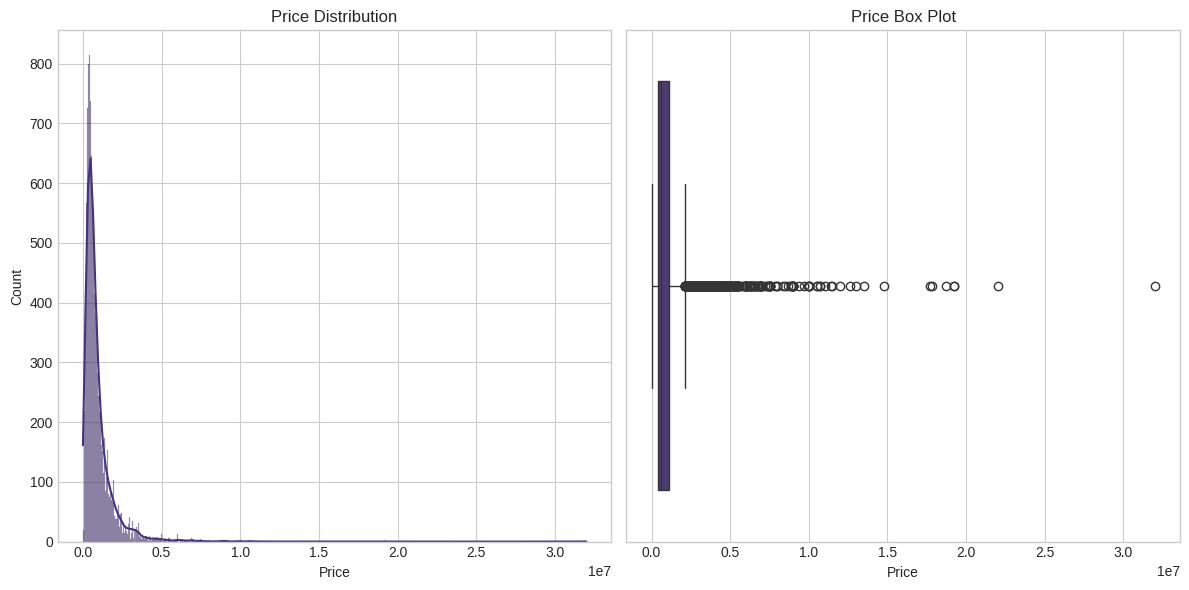

<ipython-input-45-7fc8671e61be>:72: UserWarning: Glyph 128 (\x80) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-45-7fc8671e61be>:72: UserWarning: Glyph 130 (\x82) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-45-7fc8671e61be>:72: UserWarning: Glyph 128 (\x80) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-45-7fc8671e61be>:72: UserWarning: Glyph 130 (\x82) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-45-7fc8671e61be>:72: UserWarning: Glyph 130 (\x82) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-45-7fc8671e61be>:72: UserWarning: Glyph 128 (\x80) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-45-7fc8671e61be>:72: UserWarning: Glyph 130 (\x82) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-45-7fc8671e61be>:72: UserWarning: Glyph 128 (\x80) missing from font(s) Liberation Sans.
  plt.tight_layout()


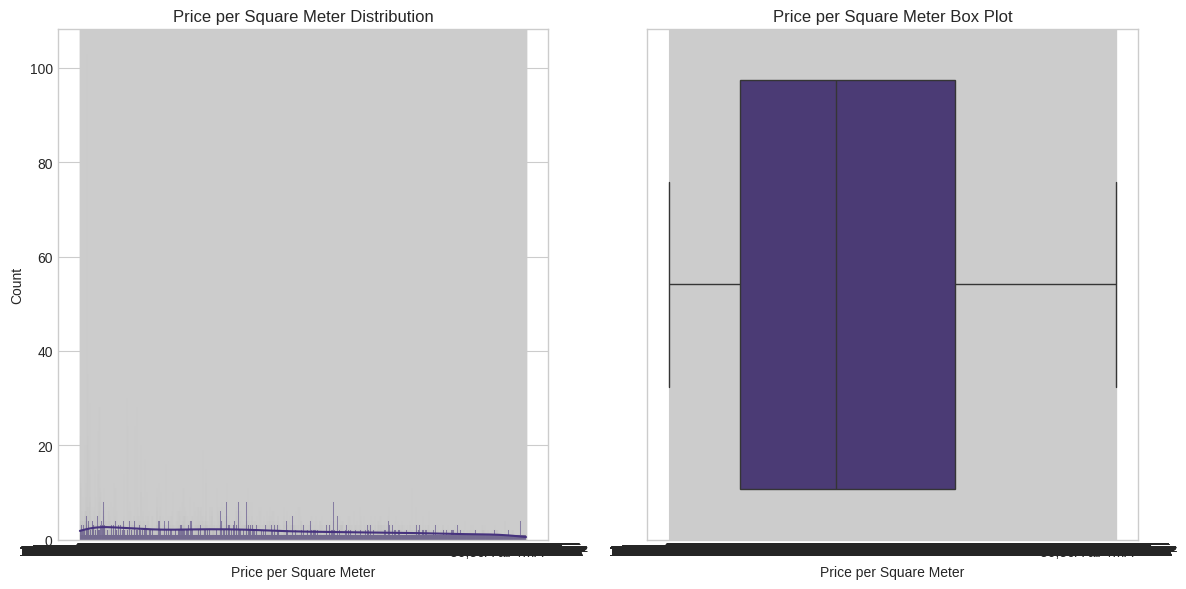

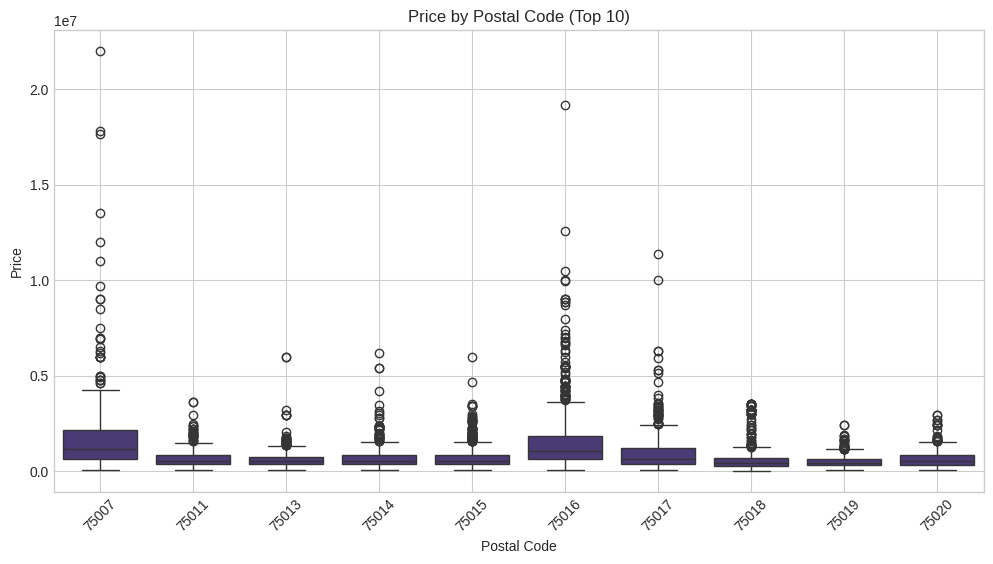

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128 (\x80) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 130 (\x82) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 130 (\x82) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128 (\x80) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 130 (\x82) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph

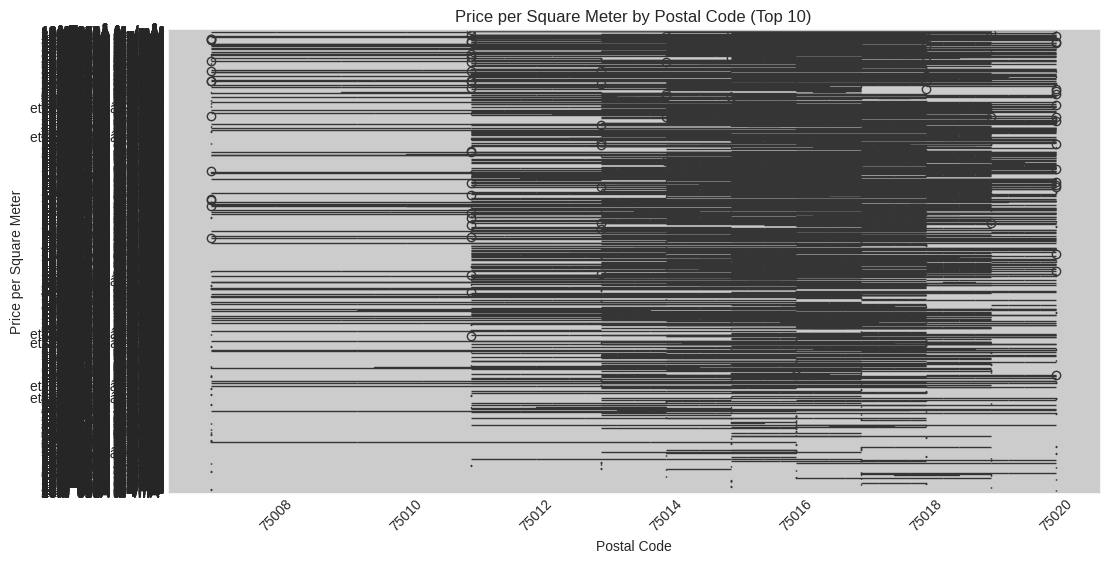

In [ ]:
# Create visualizations for apartments dataset
create_visualizations(df_apartments, "Apartments")

In [ ]:
df_properties_batch3.head()

listing_id                                          seo_title  \
0  2319RA7WFIXK  Appartement À  vendre 3 pièces 68 mÂ² 535000 â...   
1  24JLT74DTRUQ  Appartement À  vendre 2 pièces 47 mÂ² 439000 â...   
2  24DQ1UJEQCT9  Appartement À  vendre 3 pièces 50.43 mÂ² 42000...   
3  24ZFY5D62T18  Appartement À  vendre 2 pièces 56.5 mÂ² 442000...   
4  2367TQPMGWTE  Appartement À  vendre 1 pièce 20.63 mÂ² 160000...   

                                   seo_canonical_url  \
0  https://www.seloger.com/annonces/achat/apparte...   
1  https://www.seloger.com/annonces/achat/apparte...   
2  https://www.seloger.com/annonces/achat/apparte...   
3  https://www.seloger.com/annonces/achat/apparte...   
4  https://www.seloger.com/annonces/achat/apparte...   

                                     seo_description has3_d_visit  \
0  Appartement À  vendre 3 pièces 68 mÂ² 535000 â...        False   
1  Appartement À  vendre 2 pièces 47 mÂ² 439000 â...        False   
2  Appartement À  vendre 3 pièces 50.43 mÂ² 42000...        False   
3  Appartement À  vendre 2 pièces 56.5 mÂ² 442000...         True   
4  Appartement À  vendre 1 pièce 20.63 mÂ² 160000...        False   

  is_exclusive has_brokerage_fee    brand metadata_status  metadata_legacy_id  \
0        False             False  seloger            True        193599471.00   
1        False             False  seloger            True        193605641.00   
2        False             False  seloger            True        194955727.00   
3        False             False  seloger            True        198551889.00   
4        False             False  seloger            True        204061995.00   

       metadata_update_date metadata_creation_date  \
0  2025-05-22T03:16:16.761Z   2022-10-31T20:23:00Z   
1  2025-05-22T09:31:26.776Z   2022-10-31T22:34:00Z   
2  2025-02-03T18:28:07.262Z   2022-11-30T14:32:00Z   
3  2025-04-14T13:15:06.151Z   2023-02-23T09:11:00Z   
4  2025-02-05T16:00:08.064Z   2023-06-14T05:08:00Z   

   metadata_is_new_build_project  key_identifier key_reference_annonce  \
0                          False    193599471.00          340938916904   
1                          False    193605641.00          340939192788   
2                          False    194955727.00   local professionnel   
3                          False    198551889.00             RUBIS DAN   
4                          False    204061995.00          studiojaures   

   price_value  price_per_sqm_value price_type  estimated_notary_fees  \
0    535000.00              7867.65       SALE               42800.00   
1    439000.00              9340.43       SALE               35120.00   
2    420000.00              8328.38       SALE               33600.00   
3    442000.00              7823.01       SALE               35360.00   
4    160000.00              7755.70       SALE               12800.00   

   estimated_project_amount  estimated_energy_bill  \
0                 577800.00                    NaN   
1                 474120.00                    NaN   
2                 453600.00                1080.00   
3                 477360.00                    NaN   
4                 172800.00                 960.00   

   energy_year_of_construction energy_heating_system energy_source  \
0                          NaN                   NaN           NaN   
1                          NaN                   NaN           NaN   
2                          NaN                   NaN           NaN   
3                      1976.00                   NaN           NaN   
4                          NaN                   NaN           NaN   

   image_count                                         image_urls  \
0           15  ['https://mms.seloger.com/f/3/6/9/f369240b-4cd...   
1            9  ['https://mms.seloger.com/9/d/b/9/9db96db0-790...   
2            8  ['https://mms.seloger.com/7/c/e/0/7ce08820-d36...   
3           16  ['https://mms.seloger.com/e/4/a/e/e4ae56d2-8f1...   
4            7  ['https://mms.seloger.com/9/8


Creating visualizations for Properties Batch 3 dataset:


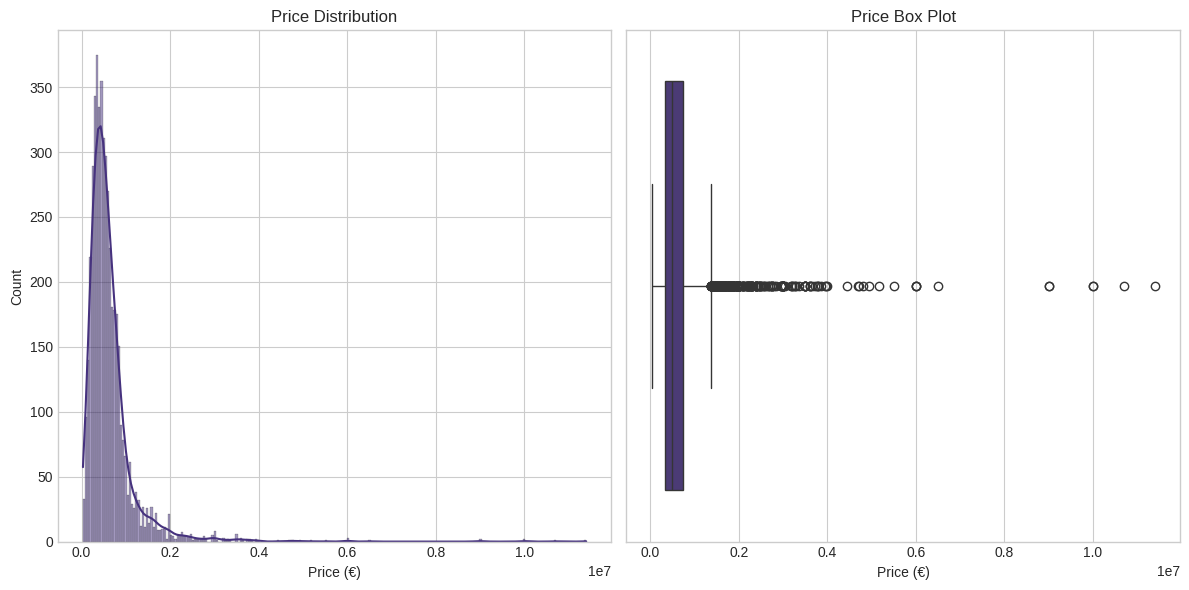

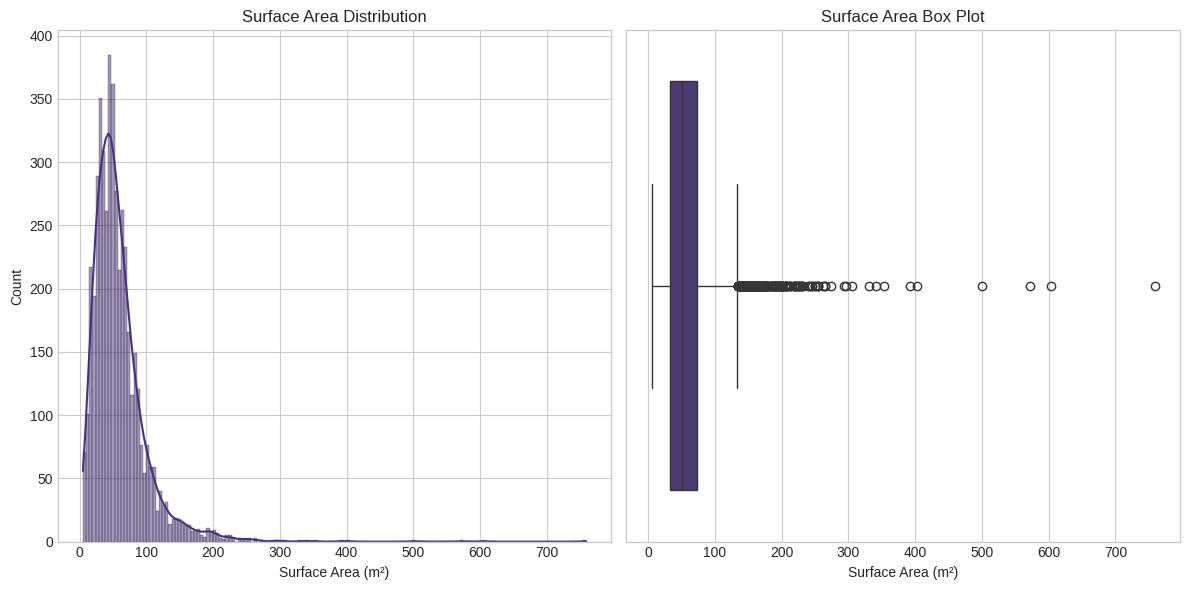

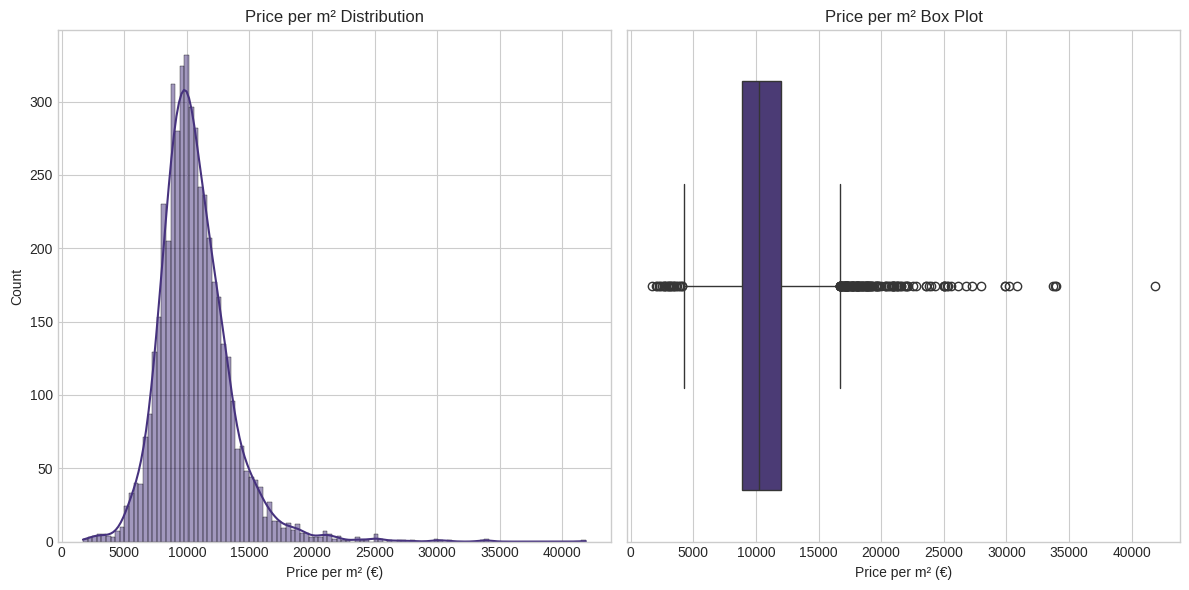

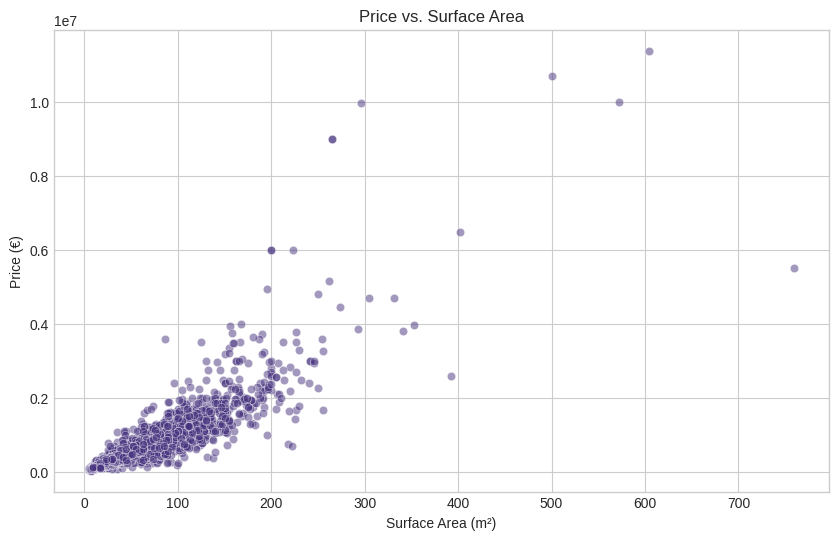

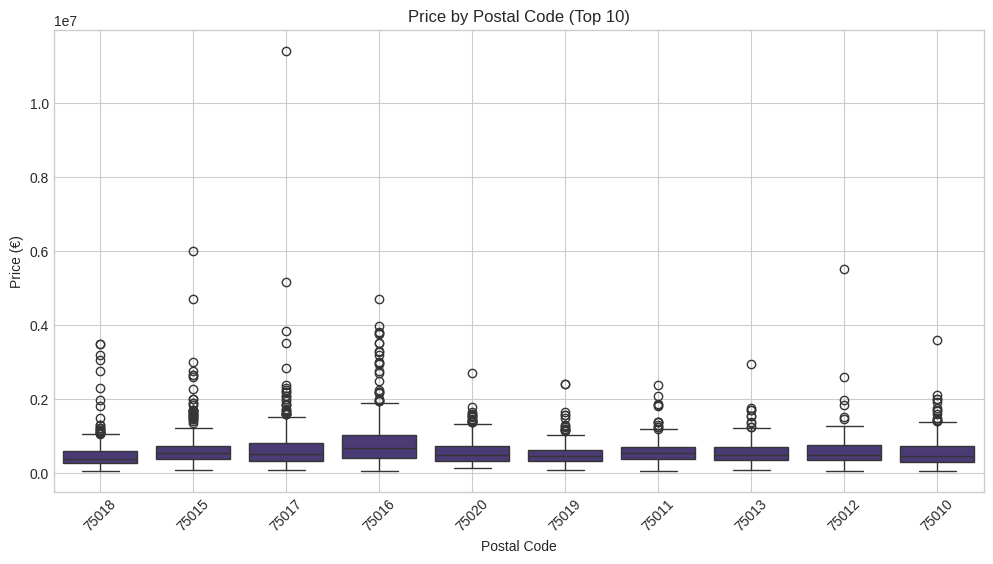

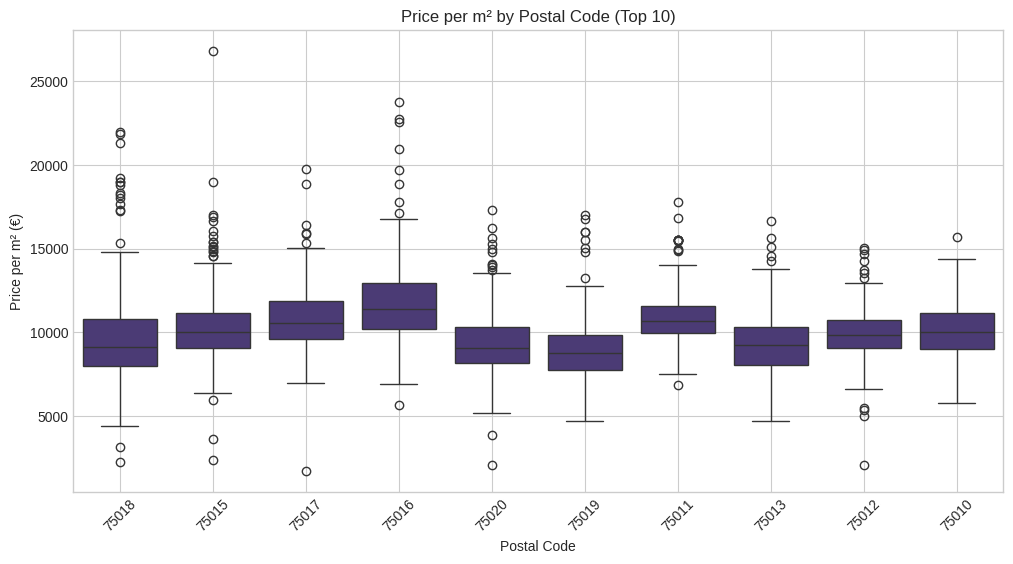

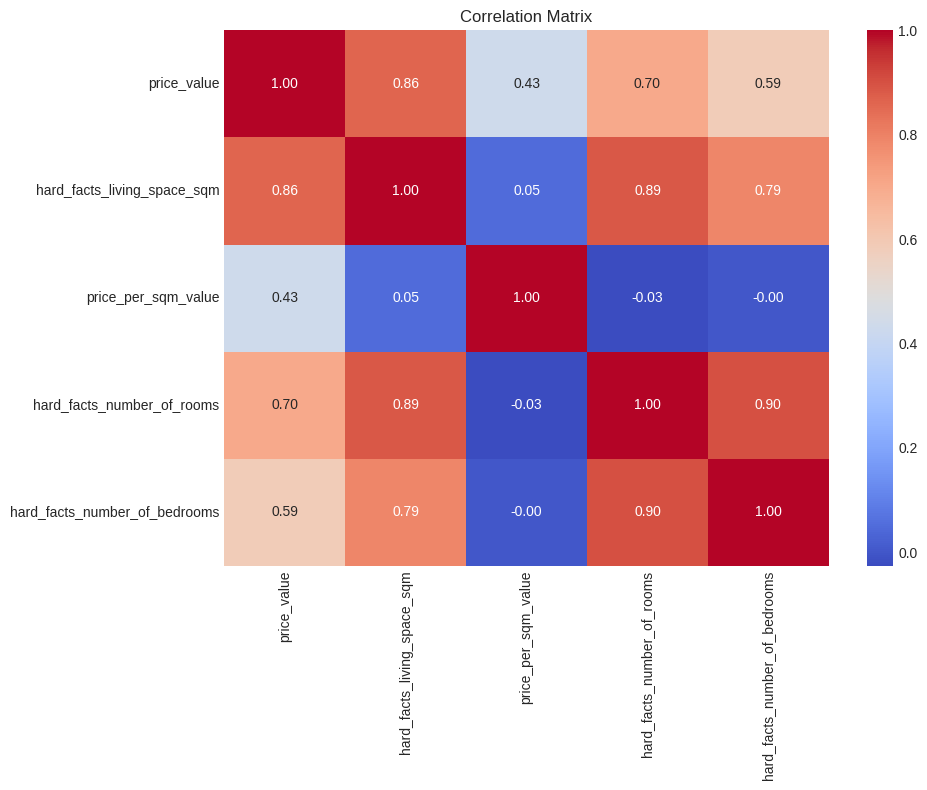

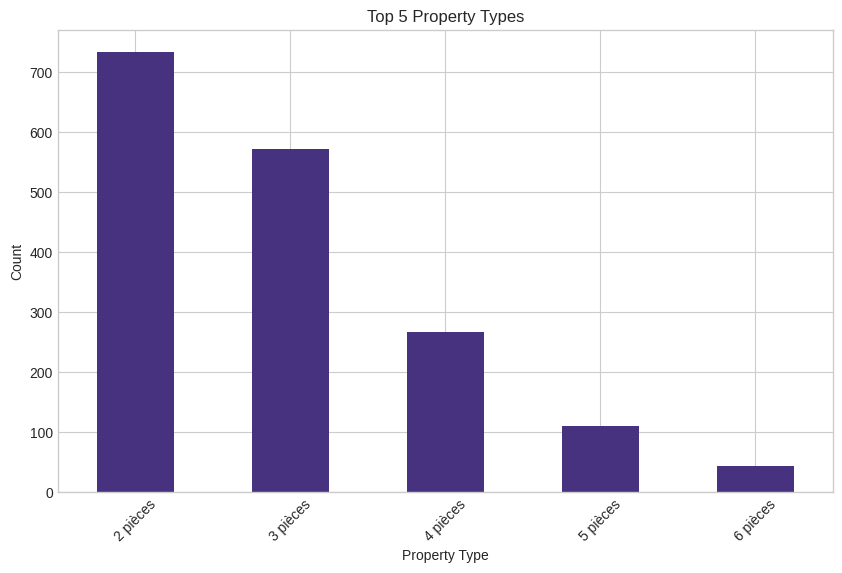

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_visualizations_seloger(df, dataset_name):
    """Create visualizations for the SeLoger dataset.

    Args:
        df: Pandas DataFrame to visualize
        dataset_name: Name of the dataset for display purposes
    """
    if df is None or df.empty:
        print(f"{dataset_name} dataset is not available for visualization.")
        return

    print(f"\nCreating visualizations for {dataset_name} dataset:")

    # Price distribution
    if 'price_value' in df.columns:
        plt.figure(figsize=(12, 6))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df['price_value'].dropna(), kde=True)
        plt.title('Price Distribution')
        plt.xlabel('Price (€)')
        plt.ylabel('Count')

        # Box plot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df['price_value'].dropna())
        plt.title('Price Box Plot')
        plt.xlabel('Price (€)')

        plt.tight_layout()
        plt.show()

    # Surface area distribution
    if 'hard_facts_living_space_sqm' in df.columns:
        plt.figure(figsize=(12, 6))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df['hard_facts_living_space_sqm'].dropna(), kde=True)
        plt.title('Surface Area Distribution')
        plt.xlabel('Surface Area (m²)')
        plt.ylabel('Count')

        # Box plot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df['hard_facts_living_space_sqm'].dropna())
        plt.title('Surface Area Box Plot')
        plt.xlabel('Surface Area (m²)')

        plt.tight_layout()
        plt.show()

    # Price per square meter distribution
    if 'price_per_sqm_value' in df.columns:
        plt.figure(figsize=(12, 6))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df['price_per_sqm_value'].dropna(), kde=True)
        plt.title('Price per m² Distribution')
        plt.xlabel('Price per m² (€)')
        plt.ylabel('Count')

        # Box plot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df['price_per_sqm_value'].dropna())
        plt.title('Price per m² Box Plot')
        plt.xlabel('Price per m² (€)')

        plt.tight_layout()
        plt.show()

    # Price vs. Surface Area scatter plot
    if 'price_value' in df.columns and 'hard_facts_living_space_sqm' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            x='hard_facts_living_space_sqm',
            y='price_value',
            data=df,
            alpha=0.5
        )
        plt.title('Price vs. Surface Area')
        plt.xlabel('Surface Area (m²)')
        plt.ylabel('Price (€)')
        plt.grid(True)
        plt.show()

    # Price by postal code (top 10 postal codes)
    if 'price_value' in df.columns and 'postal_code' in df.columns:
        # Convert to string and get top 10 postal codes by count
        df['postal_code_str'] = df['postal_code'].astype(str).str[:5]
        top_postal_codes = df['postal_code_str'].value_counts().head(10).index

        # Filter data for top postal codes
        df_top_postal = df[df['postal_code_str'].isin(top_postal_codes)]

        plt.figure(figsize=(12, 6))
        sns.boxplot(
            x='postal_code_str',
            y='price_value',
            data=df_top_postal,
            order=top_postal_codes
        )
        plt.title('Price by Postal Code (Top 10)')
        plt.xlabel('Postal Code')
        plt.ylabel('Price (€)')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

    # Price per m² by postal code (top 10 postal codes)
    if 'price_per_sqm_value' in df.columns and 'postal_code' in df.columns:
        # Use existing postal code string conversion
        if 'postal_code_str' not in df.columns:
            df['postal_code_str'] = df['postal_code'].astype(str).str[:5]
        top_postal_codes = df['postal_code_str'].value_counts().head(10).index

        df_top_postal = df[df['postal_code_str'].isin(top_postal_codes)]

        plt.figure(figsize=(12, 6))
        sns.boxplot(
            x='postal_code_str',
            y='price_per_sqm_value',
            data=df_top_postal,
            order=top_postal_codes
        )
        plt.title('Price per m² by Postal Code (Top 10)')
        plt.xlabel('Postal Code')
        plt.ylabel('Price per m² (€)')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

    # Correlation matrix for key numeric features
    key_numeric_cols = [
        'price_value', 'hard_facts_living_space_sqm', 'price_per_sqm_value',
        'hard_facts_number_of_rooms', 'hard_facts_number_of_bedrooms'
    ]
    existing_cols = [col for col in key_numeric_cols if col in df.columns]

    if len(existing_cols) > 1:
        plt.figure(figsize=(10, 8))
        correlation_matrix = df[existing_cols].corr(numeric_only=True)
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.show()

    # Additional visualization: Property type distribution
    if 'main_description_headline' in df.columns:
        plt.figure(figsize=(10, 6))
        property_types = df['main_description_headline'].str.extract(r'(\d+ pièces)')[0].value_counts().head(5)
        property_types.plot(kind='bar')
        plt.title('Top 5 Property Types')
        plt.xlabel('Property Type')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()
# Create visualizations for properties batch 3 dataset
create_visualizations_seloger(df_properties_batch3, "Properties Batch 3")


Creating visualizations for Properties Batch 1 dataset:


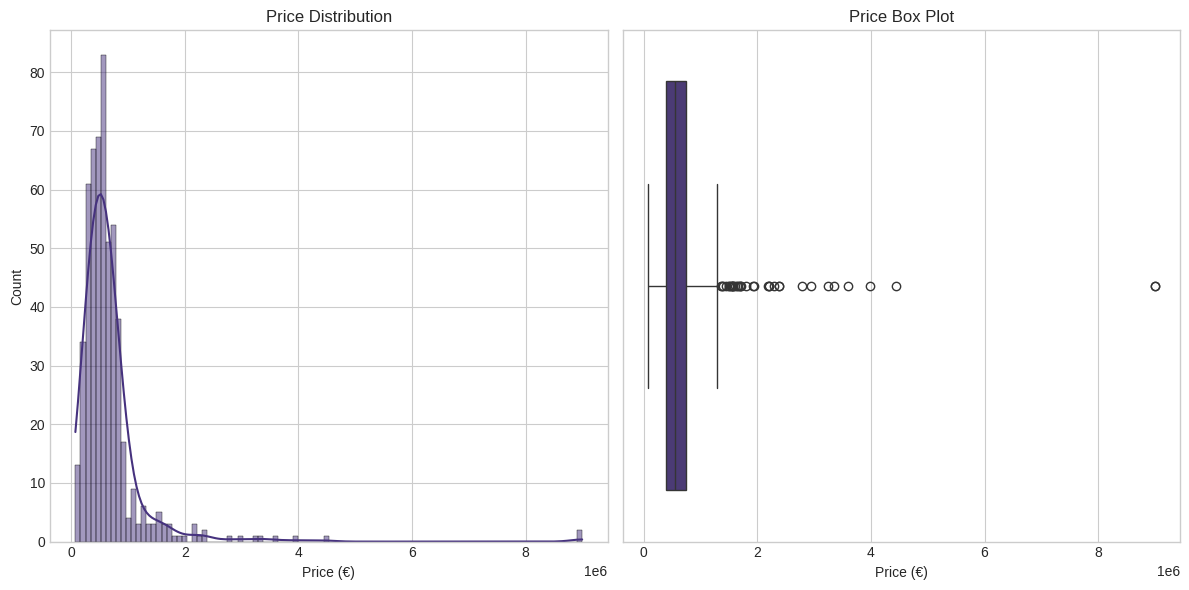

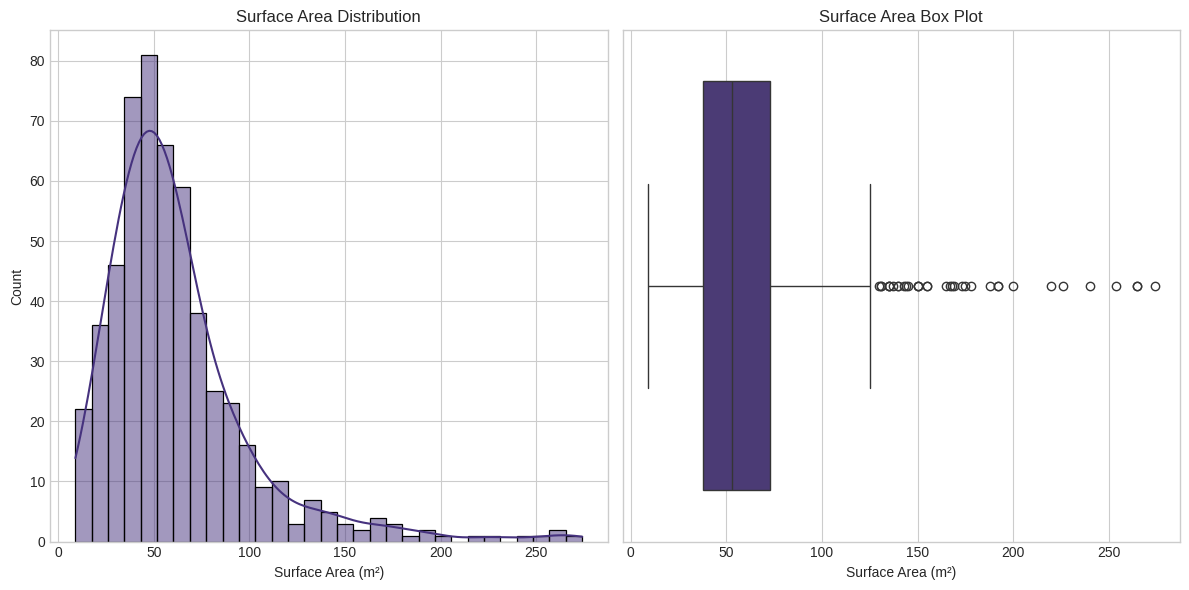

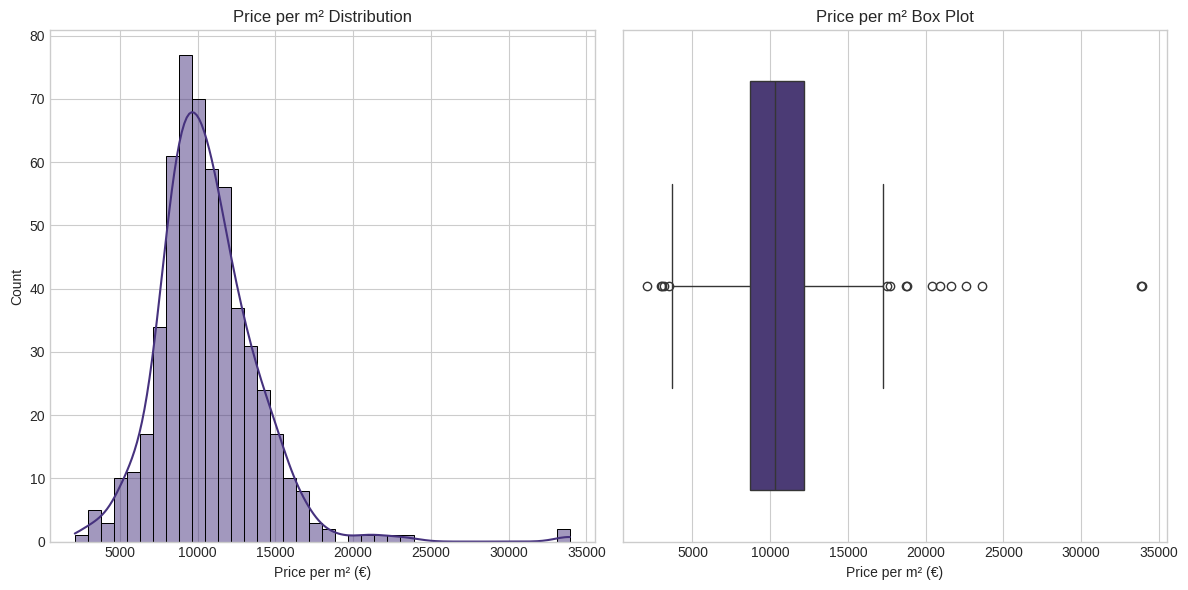

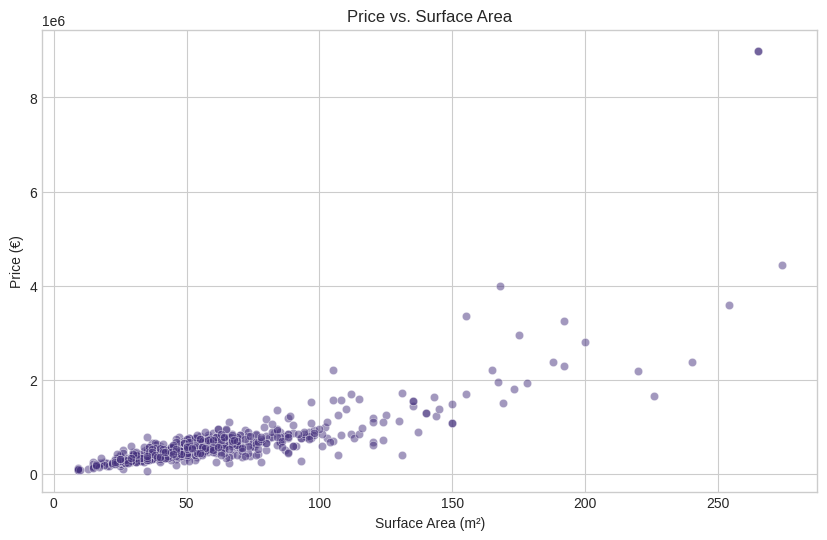

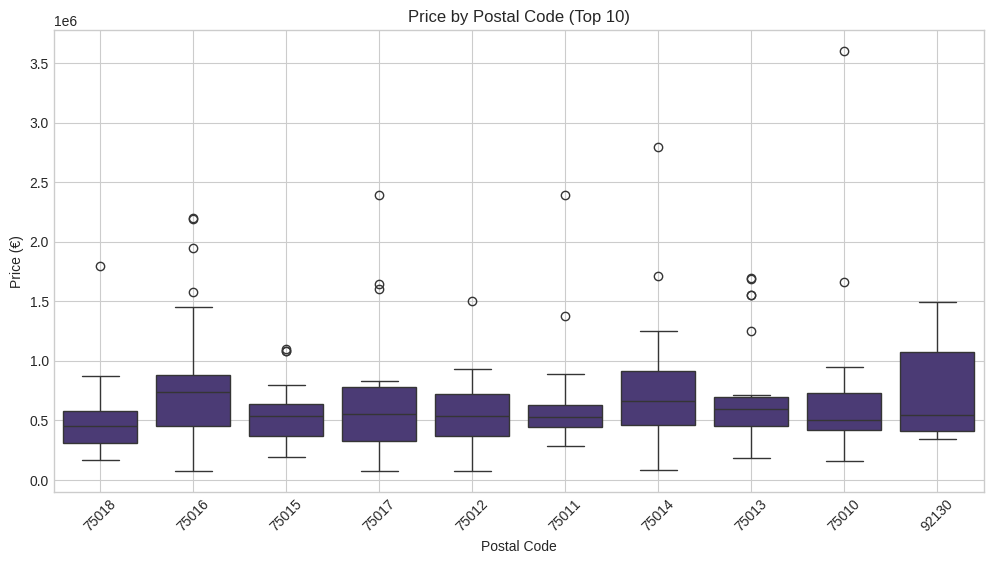

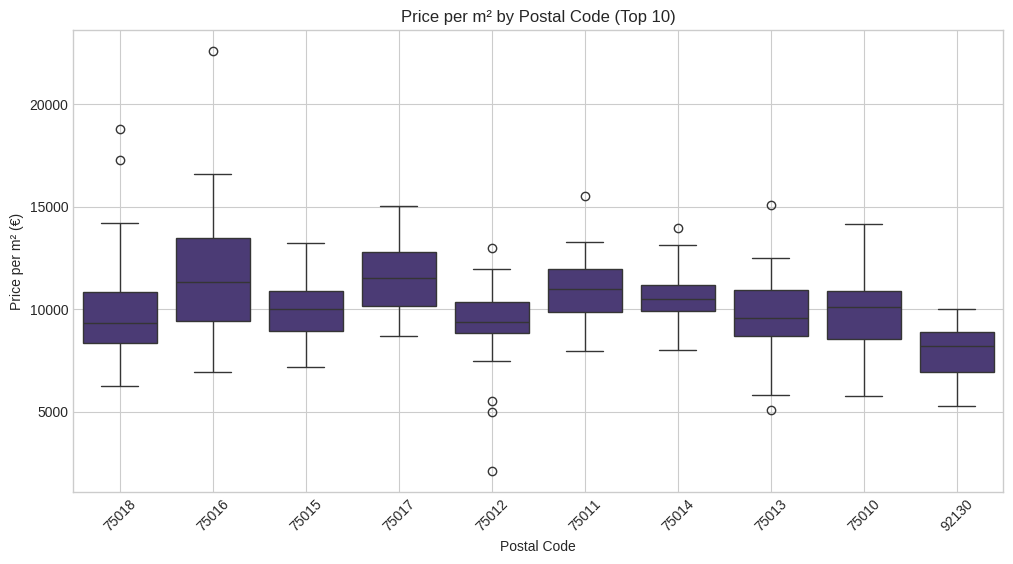

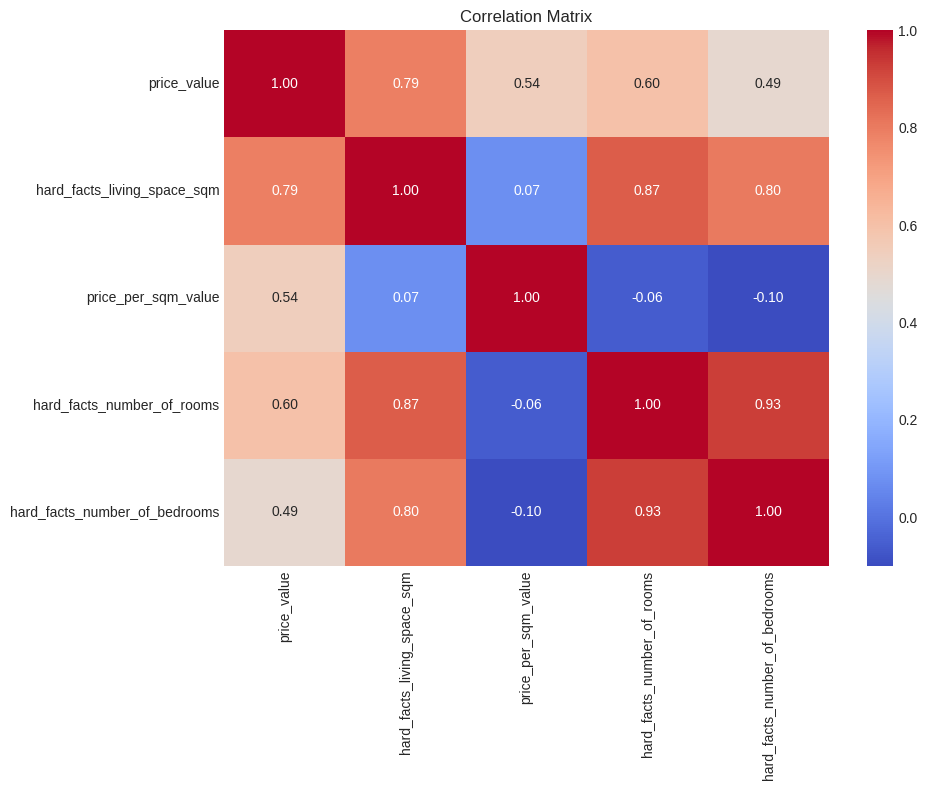

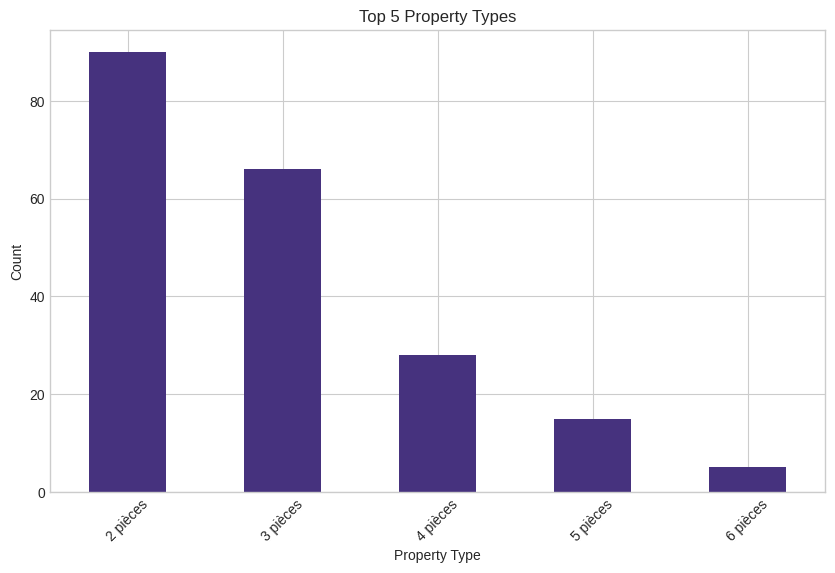

In [ ]:
create_visualizations_seloger(df_properties_batch1, "Properties Batch 1")


Creating visualizations for Properties Batch 2 dataset:


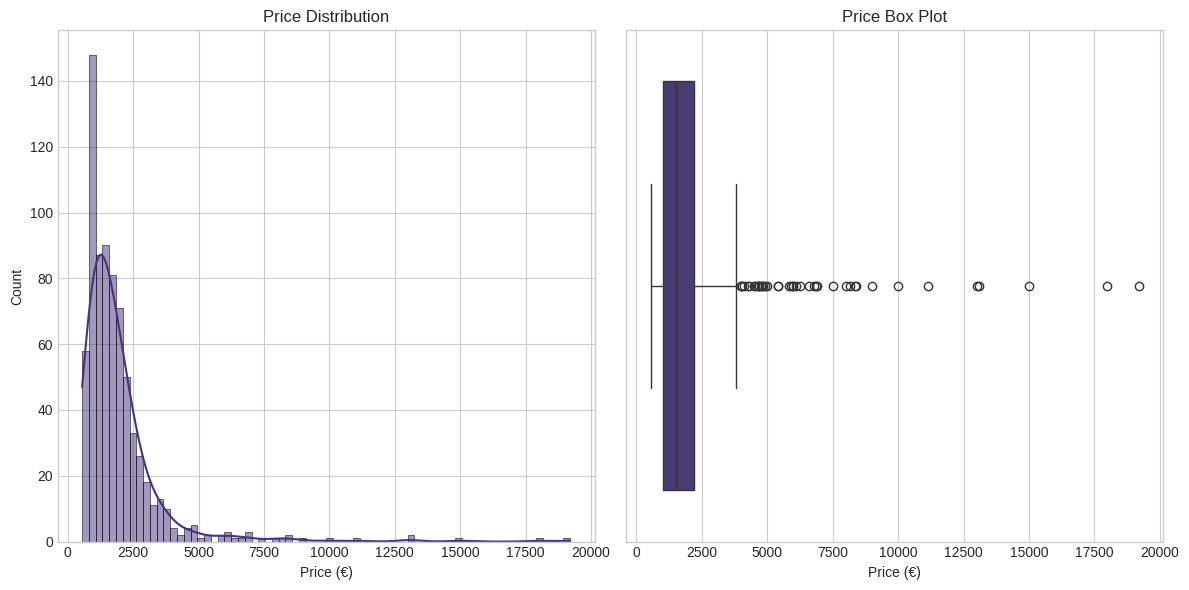

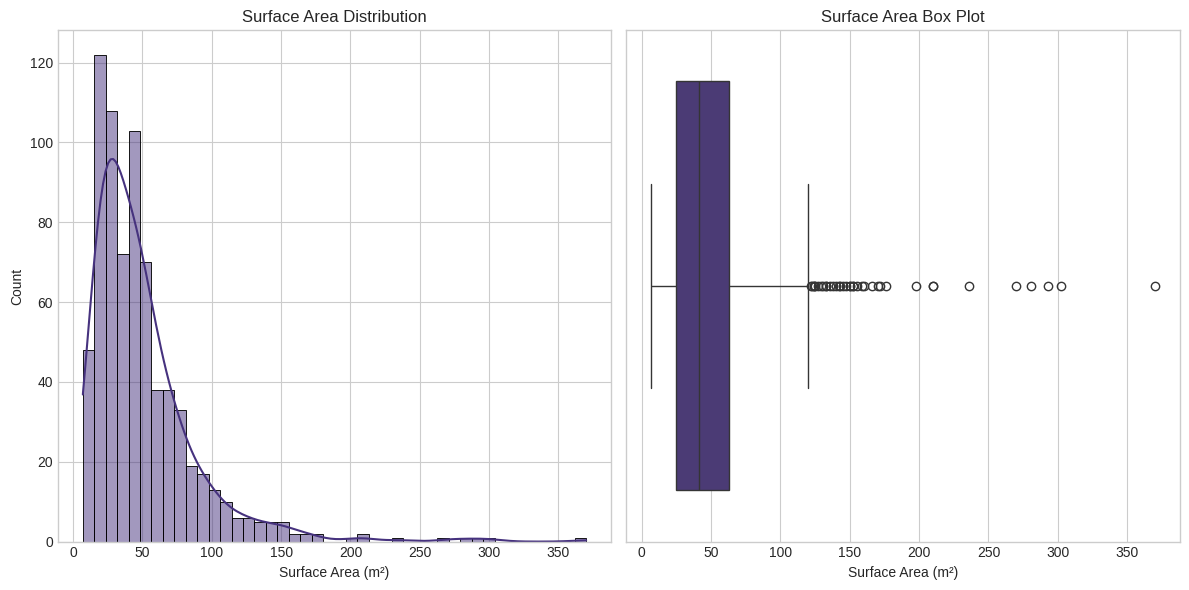

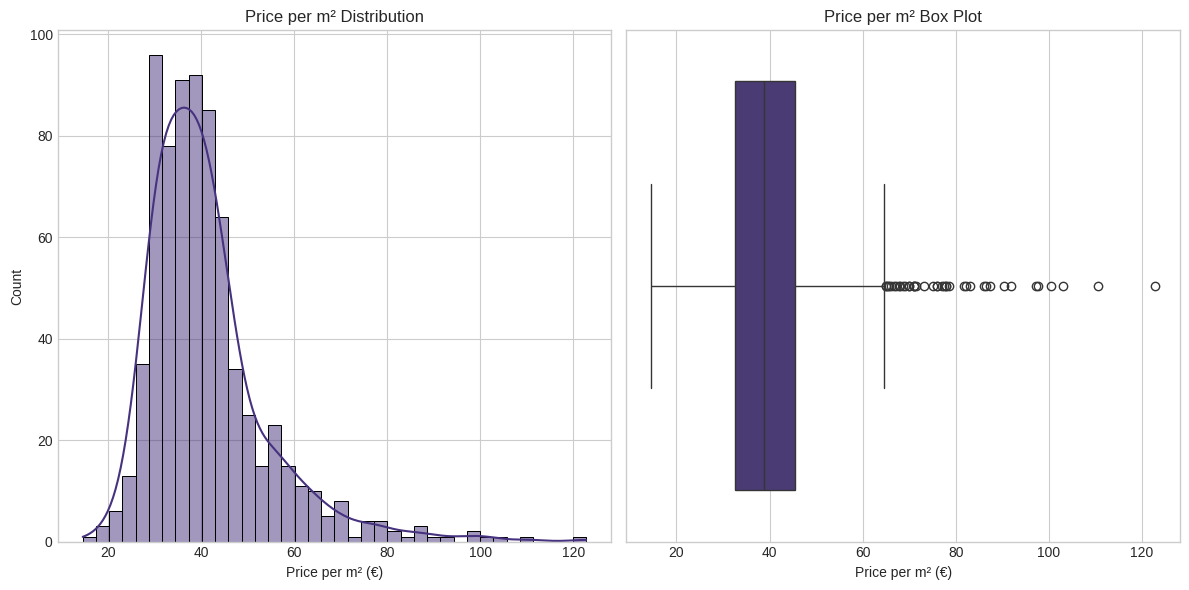

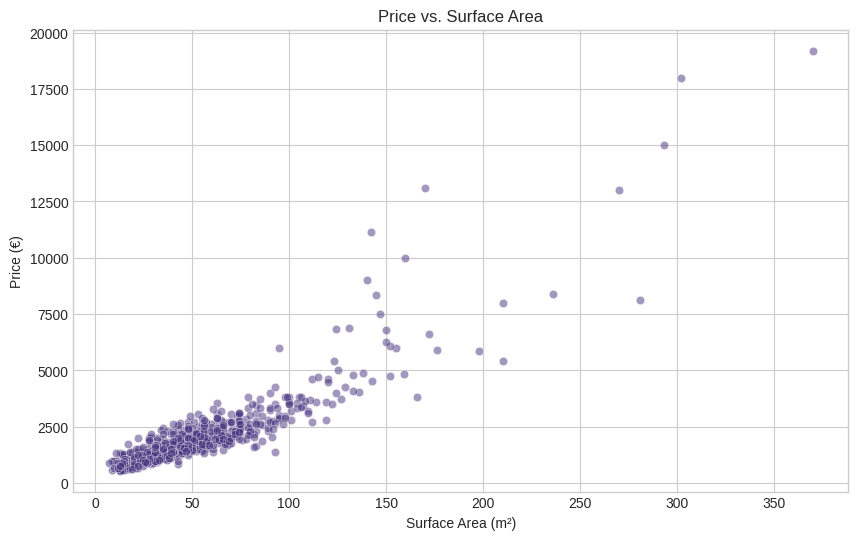

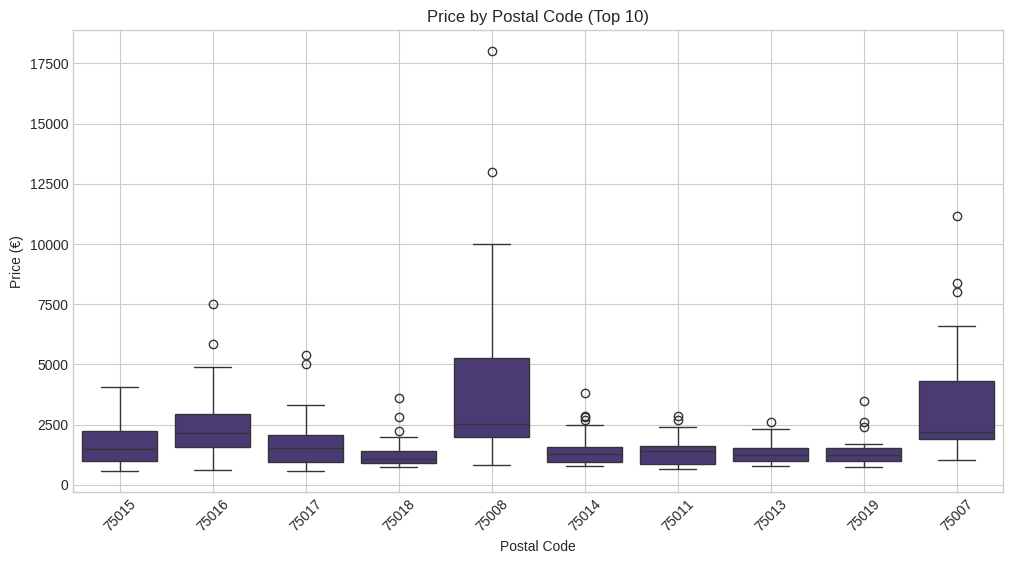

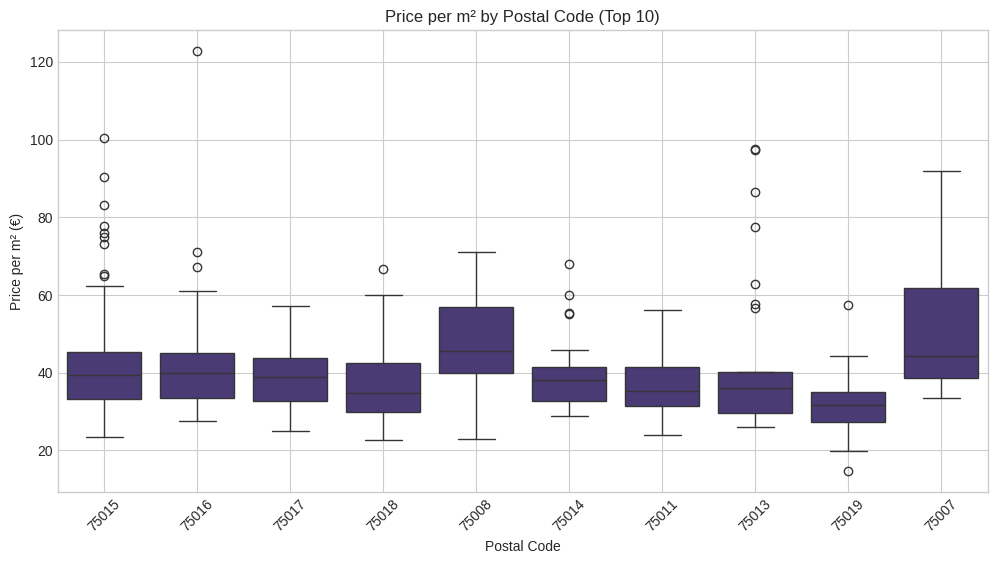

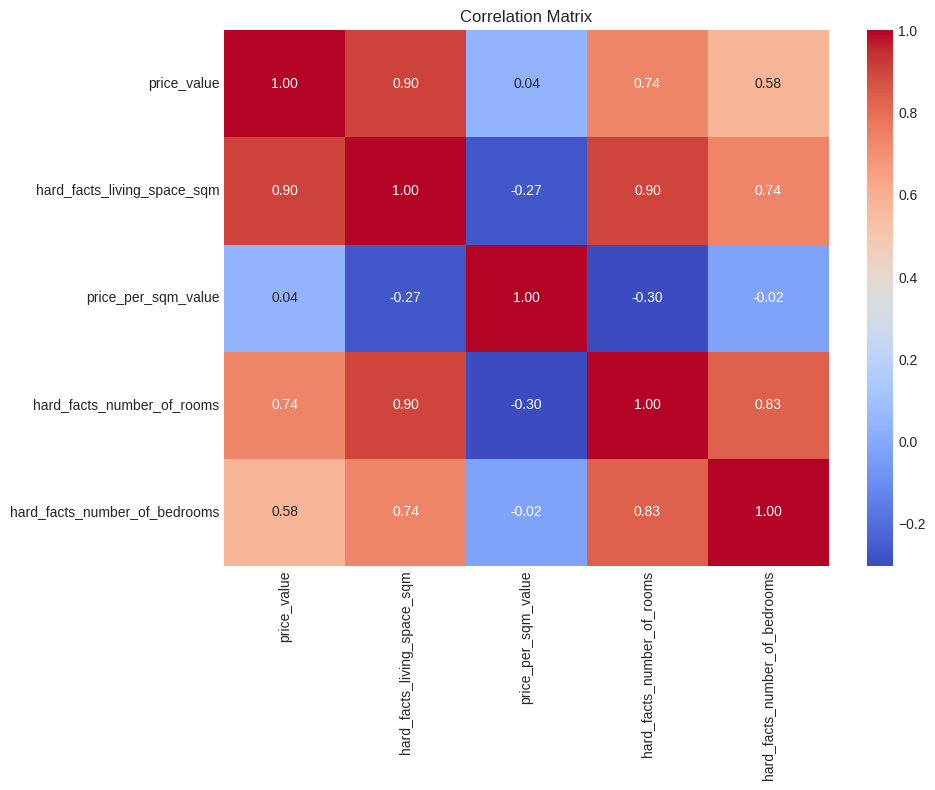

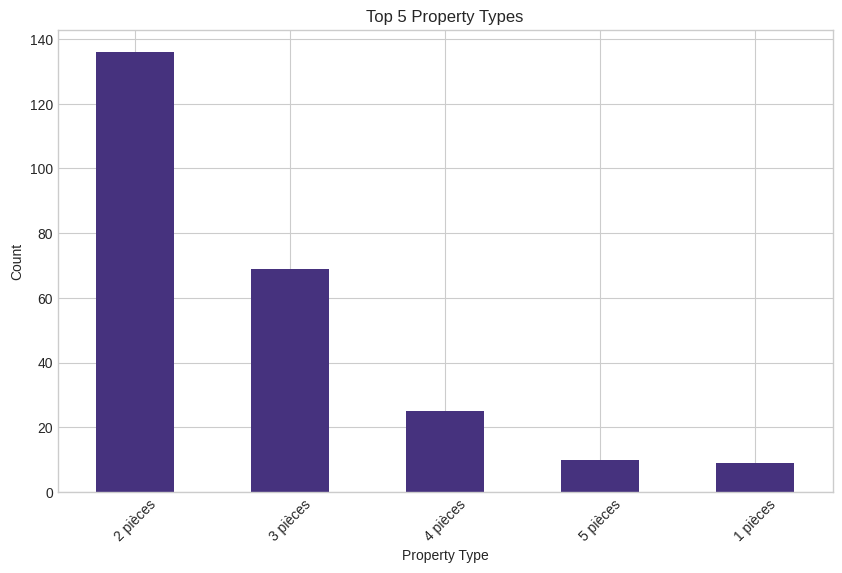

In [ ]:
create_visualizations_seloger(df_properties_batch2, "Properties Batch 2")


Creating visualizations for Airbnb Listings dataset:


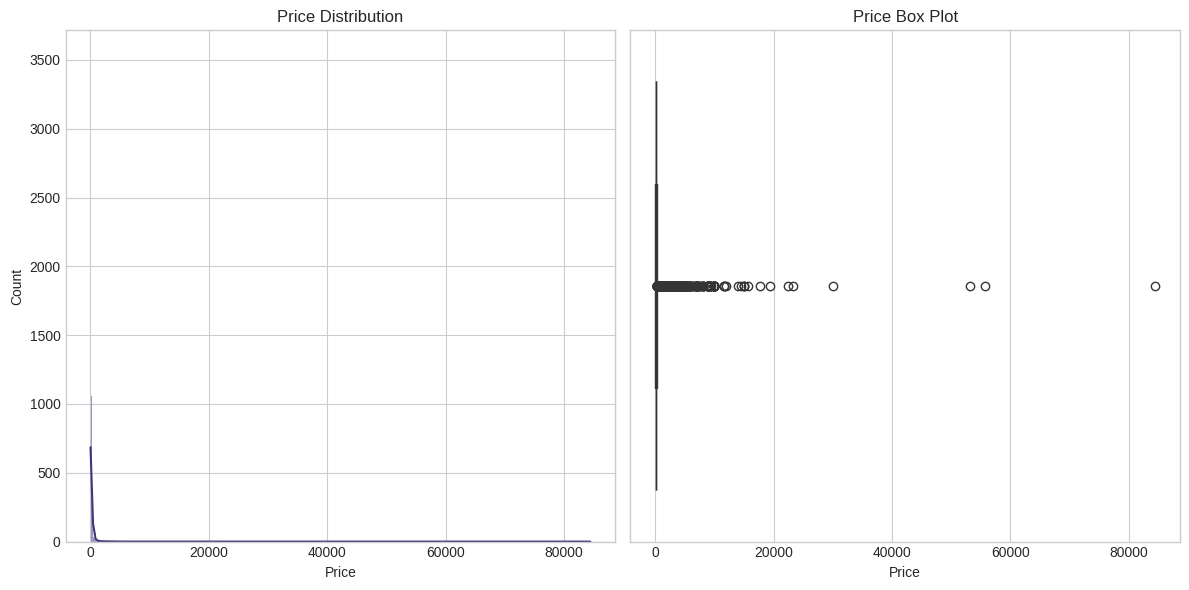

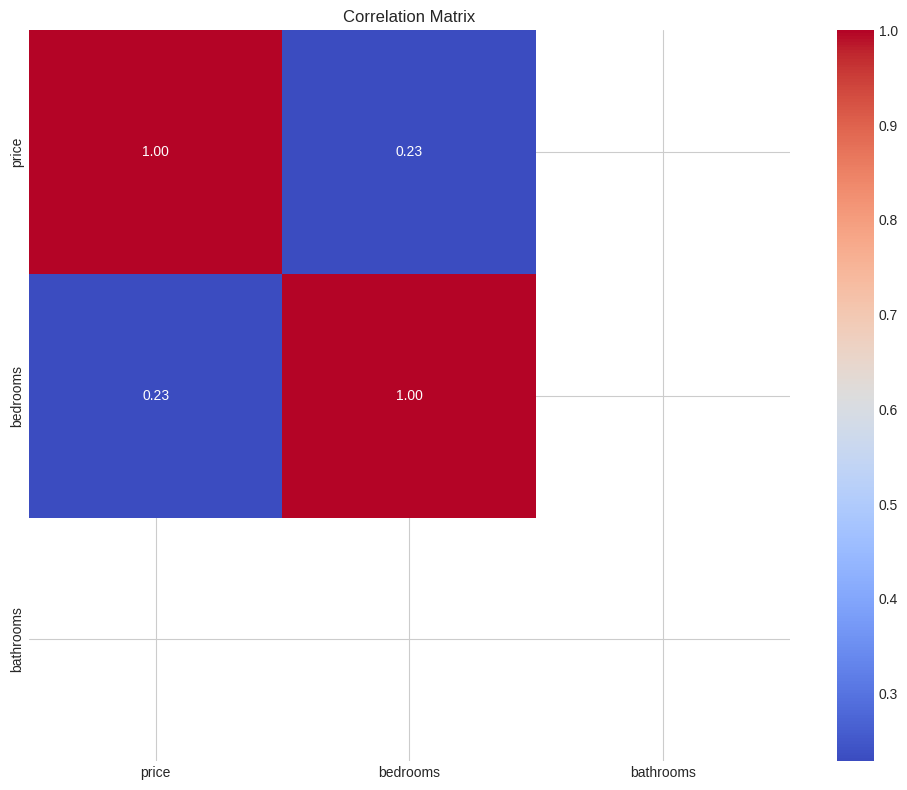

In [ ]:
# Create visualizations for Airbnb listings dataset
create_visualizations(df_airbnb_listings, "Airbnb Listings")

### 2.5 Calculate Rental Yields

Let's calculate rental yields for the properties based on the rental data.

In [ ]:
# Function to calculate rental yields
def calculate_rental_yields(properties_df, rentals_df, airbnb_df=None):
    """Calculate rental yields for properties based on rental data.

    Args:
        properties_df: DataFrame of properties for sale
        rentals_df: DataFrame of rental properties
        airbnb_df: DataFrame of Airbnb listings (optional)

    Returns:
        DataFrame of properties with rental yields
    """
    if properties_df is None or rentals_df is None:
        print("Properties or rentals dataset is not available for yield calculation.")
        return None

    print("Calculating rental yields...")

    # Create a copy of the properties DataFrame
    df_yields = properties_df.copy()

    # Calculate average rental price per square meter by postal code
    # Use the correct column names from the rentals_df
    if 'postal_code' in rentals_df.columns and 'price' in rentals_df.columns and 'surface' in rentals_df.columns:
        # Calculate price per square meter for rentals
        rentals_df['price_per_sqm_calc'] = rentals_df['price'] / rentals_df['surface']

        # Calculate average rental price per square meter by postal code
        rental_prices = rentals_df.groupby('postal_code')['price_per_sqm_calc'].mean().reset_index()
        rental_prices.columns = ['postal_code', 'avg_rental_price_per_sqm']

        # Ensure postal code in rental_prices is the same type as in df_yields
        if 'postal_code' in df_yields.columns and df_yields['postal_code'].dtype != rental_prices['postal_code'].dtype:
            try:
                rental_prices['postal_code'] = rental_prices['postal_code'].astype(df_yields['postal_code'].dtype)
            except ValueError:
                print(f"Warning: Could not convert postal_code in rental_prices to {df_yields['postal_code'].dtype}. Skipping merge.")
                rental_prices = None

        if rental_prices is not None:
            # Merge with properties DataFrame
            df_yields = df_yields.merge(rental_prices, on='postal_code', how='left')

            # Calculate estimated monthly rent (using surface from properties_df)
            if 'surface' in df_yields.columns:
                df_yields['estimated_monthly_rent'] = df_yields['surface'] * df_yields['avg_rental_price_per_sqm']

                # Calculate estimated annual rent
                df_yields['estimated_annual_rent'] = df_yields['estimated_monthly_rent'] * 12

                # Calculate long-term rental yield
                if 'price' in df_yields.columns:
                    df_yields['long_term_rental_yield'] = (df_yields['estimated_annual_rent'] / df_yields['price']) * 100

                    print(f"Calculated long-term rental yields for {df_yields['long_term_rental_yield'].notna().sum()} properties")
                else:
                    print("Warning: 'price' column not found in properties_df. Cannot calculate long-term rental yield.")
            else:
                print("Warning: 'surface' column not found in properties_df. Cannot calculate estimated monthly rent or long-term rental yield.")
    else:
         print("Warning: Required columns ('postal_code', 'price', 'surface') not found in rentals_df. Cannot calculate long-term rental yield.")


    # Calculate short-term (Airbnb) rental yields if Airbnb data is available
    if airbnb_df is not None and 'postal_code' in df_yields.columns:
        # Extract postal code from Airbnb neighborhood or zipcode if available
        if 'zipcode' in airbnb_df.columns:
            airbnb_df['postal_code_airbnb'] = airbnb_df['zipcode']
        elif 'neighbourhood' in airbnb_df.columns:
            # Extract postal code from neighborhood (assuming format includes postal code)
            # Filter out non-matching postal codes before conversion
            airbnb_df['postal_code_str'] = airbnb_df['neighbourhood'].astype(str).str.extract(r'(750\d{2})')
            airbnb_df['postal_code_airbnb'] = pd.to_numeric(airbnb_df['postal_code_str'], errors='coerce') # Convert to numeric, non-numeric become NaN

        if 'postal_code_airbnb' in airbnb_df.columns and 'price' in airbnb_df.columns:
            # Calculate average Airbnb price by postal code, dropping NaNs in postal_code
            airbnb_prices = airbnb_df.dropna(subset=['postal_code_airbnb']).groupby('postal_code_airbnb')['price'].mean().reset_index()
            airbnb_prices.columns = ['postal_code', 'avg_airbnb_price']

            # Ensure postal code in airbnb_prices is the same type as in df_yields
            if df_yields['postal_code'].dtype != airbnb_prices['postal_code'].dtype:
                 try:
                    airbnb_prices['postal_code'] = airbnb_prices['postal_code'].astype(df_yields['postal_code'].dtype)
                 except ValueError:
                    print(f"Warning: Could not convert postal_code in airbnb_prices to {df_yields['postal_code'].dtype}. Skipping merge.")
                    airbnb_prices = None


            if airbnb_prices is not None:
                # Merge with properties DataFrame
                df_yields = df_yields.merge(airbnb_prices, on='postal_code', how='left')

                # Estimate occupancy rate (assuming 70% occupancy)
                occupancy_rate = 0.7

                # Calculate estimated monthly Airbnb income
                df_yields['estimated_airbnb_income'] = df_yields['avg_airbnb_price'] * 30 * occupancy_rate

                # Calculate estimated annual Airbnb income
                df_yields['estimated_annual_airbnb_income'] = df_yields['estimated_airbnb_income'] * 12

                # Calculate short-term rental yield
                if 'price' in df_yields.columns:
                    df_yields['short_term_rental_yield'] = (df_yields['estimated_annual_airbnb_income'] / df_yields['price']) * 100

                    print(f"Calculated short-term rental yields for {df_yields['short_term_rental_yield'].notna().sum()} properties")
                else:
                    print("Warning: 'price' column not found in properties_df. Cannot calculate short-term rental yield.")
            else:
                print("Warning: Required columns ('postal_code_airbnb', 'price') not found in airbnb_df. Cannot calculate short-term rental yield.")
    else:
        print("Warning: Airbnb dataset is not available or 'postal_code' not found in properties_df. Cannot calculate short-term rental yield.")


    return df_yields

In [ ]:
df_airbnb_listings.head(2)

id                        listing_url       scrape_id last_scraped  \
0  3109  https://www.airbnb.com/rooms/3109  20231212042736   2023-12-12   
1  5396  https://www.airbnb.com/rooms/5396  20231212042736   2023-12-14   

        source                                               name  \
0  city scrape  Rental unit in Paris · ★5.0 · 1 bedroom · 1 be...   
1  city scrape  Rental unit in Paris · ★4.59 · Studio · 1 bed ...   

   description                              neighborhood_overview  \
0          NaN  Good restaurants<br />very close the Montparna...   
1          NaN  You are within walking distance to the Louvre,...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/baeae9e2-cd53...     3631   
1  https://a0.muscache.com/pictures/52413/f9bf76f...     7903   

                                 host_url host_name  host_since  \
0  https://www.airbnb.com/users/show/3631      Anne  2008-10-14   
1  https://www.airbnb.com/users/show/7903    Borzou  2009-02-14   

   host_location                                         host_about  \
0  Paris, France                                                NaN   
1  Paris, France  We have spent a lot of time traveling for work...   

   host_response_time host_response_rate host_acceptance_rate  \
0  within a few hours               100%                 100%   
1      within an hour               100%                 100%   

  host_is_superhost                                 host_thumbnail_url  \
0                 f  https://a0.muscache.com/im/users/3631/profile_...   
1                 f  https://a0.muscache.com/im/users/7903/profile_...   

                                    host_picture_url  \
0  https://a0.muscache.com/im/users/3631/profile_...   
1  https://a0.muscache.com/im/users/7903/profile_...   

             host_neighbourhood  host_listings_count  \
0                        Alésia                 1.00   
1  Saint-Paul - Ile Saint-Louis                 2.00   

   host_total_listings_count  host_verifications host_has_profile_pic  \
0                       2.00  ['email', 'phone']                    t   
1                       3.00  ['email', 'phone']                    t   

  host_identity_verified                 neighbourhood neighbourhood_cleansed  \
0                      f  Paris, Île-de-France, France           Observatoire   
1                      t  Paris, Ile-de-France, France         Hôtel-de-Ville   

   neighbourhood_group_cleansed  latitude  longitude       property_type  \
0                           NaN     48.83       2.32  Entire rental unit   
1                           NaN     48.85       2.36  Entire rental unit   

         room_type  accommodates  bathrooms bathrooms_text  bedrooms  beds  \
0  Entire home/apt             2        NaN         1 bath       NaN  1.00   
1  Entire home/apt             2        NaN         1 bath       NaN  1.00   

  amenities  price  minimum_nights  maximum_nights  minimum_minimum_nights  \
0        [] 150.00               2              30                    2.00   
1        [] 146.00               1            1125                    1.00   

   maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
0                    2.00                   30.00                   30.00   
1                    2.00                 1125.00                 1125.00   

   minimum_nights_avg_ntm  maximum_nights_avg_ntm  calendar_updated  \
0                    2.00                   30.00               NaN   
1                    1.00                 1125.00               NaN   

  has_availability  availability_30  availability_60  availability_90  \
0                t               21               30               60   
1                t                0                0                0   

   availability_365 calendar_last_scraped  number_of_reviews  \
0               327            2023-12-12                  4   
1                 0            2023-1

In [ ]:
# Calculate rental yields for apartments dataset
df_apartments_yields = calculate_rental_yields(df_apartments, df_properties_batch2, df_airbnb_listings)

Calculating rental yields...
Calculated short-term rental yields for 1461 properties


In [ ]:
# Step 1: Rename surface column in apartments DataFrame
df_apartments.rename(columns={'main_surface_sqm': 'surface'}, inplace=True)

# Step 2: Rename price and surface in rentals DataFrame
df_properties_batch2.rename(columns={
    'price_value': 'price',
    'hard_facts_living_space_sqm': 'surface'
}, inplace=True)

# Step 3: Clean and extract postal code from Airbnb
if 'neighbourhood_cleansed' in df_airbnb_listings.columns:
    df_airbnb_listings['postal_code_str'] = df_airbnb_listings['neighbourhood_cleansed'].str.extract(r'(75\d{3})')
else:
    # Fallback: try extracting from 'neighbourhood' if 'neighbourhood_cleansed' is missing
    df_airbnb_listings['postal_code_str'] = df_airbnb_listings['neighbourhood'].str.extract(r'(75\d{3})')

# Convert extracted postal code to numeric and drop invalids
df_airbnb_listings['postal_code'] = pd.to_numeric(df_airbnb_listings['postal_code_str'], errors='coerce')

# Step 4: Clean and convert price to numeric (with proper handling)
# Ensure we're working with strings first to avoid AttributeError
df_airbnb_listings['price'] = df_airbnb_listings['price'].astype(str)

# Remove all characters except digits and dots
df_airbnb_listings['price'] = df_airbnb_listings['price'].str.replace(r'[^\d.]', '', regex=True)

# Convert to float, coerce errors to NaN
df_airbnb_listings['price'] = pd.to_numeric(df_airbnb_listings['price'], errors='coerce')

# Fill NA prices with 0 or drop rows (depending on your preference)
df_airbnb_listings['price'] = df_airbnb_listings['price'].fillna(0)  # Or .dropna()

# Step 5: Ensure postal_code types are consistent across all datasets
df_apartments['postal_code'] = df_apartments['postal_code'].astype(str)
df_properties_batch2['postal_code'] = df_properties_batch2['postal_code'].astype(str)
df_airbnb_listings['postal_code'] = df_airbnb_listings['postal_code'].astype(str).replace('nan', '')

# Step 6: Call the function
df_apartments_yields = calculate_rental_yields(df_apartments, df_properties_batch2, df_airbnb_listings)

Calculating rental yields...
Calculated long-term rental yields for 10340 properties
Calculated short-term rental yields for 0 properties


In [ ]:
import pandas as pd

# Updated mapping to include all Paris arrondissements
neighbourhood_to_postal_code = {
    'Buttes-Montmartre': '75018',
    'Popincourt': '75011',
    'Vaugirard': '75015',
    'Observatoire': '75014',
    'Batignolles-Monceau': '75017',
    'Passy': '75016',
    'Buttes-Chaumont': '75019',
    'Ménilmontant': '75020',
    'Opéra': '75009',
    'Temple': '75003',
    'Reuilly': '75012',
    'Panthéon': '75005',
    'Bourse': '75002',
    'Gobelins': '75013',
    'Hôtel-de-Ville': '75004',
    'Élysée': '75008',
    'Luxembourg': '75006',
    'Palais-Bourbon': '75007',
    'Louvre': '75001',
    'Enclos-Saint-Laurent': '75010'  # Added missing 10th arrondissement
}

# Step 1: Map postal codes in Airbnb DataFrame
df_airbnb_listings['postal_code'] = (
    df_airbnb_listings['neighbourhood_cleansed']
    .map(neighbourhood_to_postal_code)
    .fillna('00000')  # Handle unmapped neighborhoods
)

# Step 2: Clean Airbnb price data
df_airbnb_listings['price'] = (
    df_airbnb_listings['price']
    .astype(str)
    .str.replace(r'[^\d.]', '', regex=True)
    .replace('', '0')
    .astype(float)
)

# Step 3: Ensure consistent postal_code types across all datasets
df_apartments['postal_code'] = df_apartments['postal_code'].astype(str).str.strip()
df_properties_batch2['postal_code'] = df_properties_batch2['postal_code'].astype(str).str.strip()
df_airbnb_listings['postal_code'] = df_airbnb_listings['postal_code'].astype(str).str.strip()

# Step 4: Clean and convert price columns
df_apartments['price'] = (
    df_apartments['price']
    .astype(str)
    .str.replace(r'[^\d.]', '', regex=True)
    .replace('', '0')
    .astype(float)
)

# Step 5: Define the rental yield calculation function
def calculate_rental_yields(df_apartments, df_properties, df_airbnb):
    # Constants
    OCCUPANCY_RATE = 0.7  # 70% occupancy rate for Airbnb

    # Calculate long-term rental estimates
    df_apartments = df_apartments.copy()
    df_apartments['estimated_monthly_rent'] = (
        df_apartments['surface'] * df_properties['price_per_sqm'].median()
    )

    # Calculate median nightly rates from Airbnb
    airbnb_rates = (
        df_airbnb.groupby('postal_code')['price']
        .median()
        .reset_index()
        .rename(columns={'price': 'median_nightly_rate'})
    )

    # Handle missing postal codes in Airbnb data
    overall_median = df_airbnb['price'].median()
    df_apartments = df_apartments.merge(
        airbnb_rates,
        on='postal_code',
        how='left'
    )
    df_apartments['median_nightly_rate'] = (
        df_apartments['median_nightly_rate']
        .fillna(overall_median)
    )

    # Calculate short-term rental estimates
    df_apartments['estimated_airbnb_income'] = (
        df_apartments['median_nightly_rate'] *
        30 *
        OCCUPANCY_RATE
    )

    # Calculate rental yields
    df_apartments['long_term_rental_yield'] = (
        (df_apartments['estimated_monthly_rent'] * 12) /
        df_apartments['price']
    ) * 100

    df_apartments['short_term_rental_yield'] = (
        (df_apartments['estimated_airbnb_income'] * 12) /
        df_apartments['price']
    ) * 100

    # Clean infinite values from division by zero
    df_apartments.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df_apartments

# Step 6: Call the function
df_apartments_yields = calculate_rental_yields(
    df_apartments,
    df_properties_batch2,
    df_airbnb_listings
)

# Step 7: View the calculated values
print("\nFirst 10 properties with rental yields:")
yield_columns = [
    'postal_code', 'price', 'surface',
    'estimated_monthly_rent', 'long_term_rental_yield',
    'estimated_airbnb_income', 'short_term_rental_yield'
]
print(df_apartments_yields[yield_columns].head(10))

KeyError: 'price_per_sqm'

In [ ]:
df_airbnb_listings['neighbourhood_cleansed'].value_counts()

neighbourhood_cleansed
Buttes-Montmartre      8255
Popincourt             6645
Vaugirard              5642
Entrepôt               5251
Batignolles-Monceau    5078
Passy                  4500
Buttes-Chaumont        4304
Ménilmontant           4141
Opéra                  3638
Temple                 3213
Reuilly                2951
Observatoire           2766
Bourse                 2532
Gobelins               2431
Hôtel-de-Ville         2369
Panthéon               2366
Élysée                 2358
Luxembourg             2113
Palais-Bourbon         2082
Louvre                 1694
Name: count, dtype: int64

In [ ]:
df_properties_batch3.head(2)

listing_id                                          seo_title  \
0  2319RA7WFIXK  Appartement À  vendre 3 pièces 68 mÂ² 535000 â...   
1  24JLT74DTRUQ  Appartement À  vendre 2 pièces 47 mÂ² 439000 â...   

                                   seo_canonical_url  \
0  https://www.seloger.com/annonces/achat/apparte...   
1  https://www.seloger.com/annonces/achat/apparte...   

                                     seo_description has3_d_visit  \
0  Appartement À  vendre 3 pièces 68 mÂ² 535000 â...        False   
1  Appartement À  vendre 2 pièces 47 mÂ² 439000 â...        False   

  is_exclusive has_brokerage_fee    brand metadata_status  metadata_legacy_id  \
0        False             False  seloger            True        193599471.00   
1        False             False  seloger            True        193605641.00   

       metadata_update_date metadata_creation_date  \
0  2025-05-22T03:16:16.761Z   2022-10-31T20:23:00Z   
1  2025-05-22T09:31:26.776Z   2022-10-31T22:34:00Z   

   metadata_is_new_build_project  key_identifier key_reference_annonce  \
0                          False    193599471.00          340938916904   
1                          False    193605641.00          340939192788   

   price_value  price_per_sqm_value price_type  estimated_notary_fees  \
0    535000.00              7867.65       SALE               42800.00   
1    439000.00              9340.43       SALE               35120.00   

   estimated_project_amount  estimated_energy_bill  \
0                 577800.00                    NaN   
1                 474120.00                    NaN   

   energy_year_of_construction energy_heating_system energy_source  \
0                          NaN                   NaN           NaN   
1                          NaN                   NaN           NaN   

   image_count                                         image_urls  \
0           15  ['https://mms.seloger.com/f/3/6/9/f369240b-4cd...   
1            9  ['https://mms.seloger.com/9/d/b/9/9db96db0-790...   

   has_living_room_image  has_kitchen_image  has_bathroom_image  \
0                   True               True                True   
1                  False               True               False   

   has_bedroom_image  has_exterior_image  general_info_orientation  \
0               True                True                       NaN   
1              False                True                       NaN   

   general_info_furnished  general_info_floor_info  interior_kitchen_type  \
0                     NaN                      NaN                    NaN   
1                     NaN                      NaN                    NaN   

   interior_bathroom_amenities  interior_toilet_amenities  \
0                          NaN                        NaN   
1                          NaN                        NaN   

   interior_bedroom_count  exterior_view_type  not_included_elevator  \
0                     NaN                 NaN                    NaN   
1                     NaN                 NaN                    NaN   

   not_included_balcony  not_included_cellar location_city location_country  \
0                   NaN                  NaN      Suresnes              FRA   
1                   NaN                  NaN      Suresnes              FRA   

  location_district  location_zip_code  location_latitude  location_longitude  \
0   Carnot Gambetta           92150.00              48.88                2.23   
1   Carnot Gambetta           92150.00              48.88                2.23   

  location_is_address_published  mortgage_monthly_amount mortgage_region  \
0                          True                  2700.00   Ile-de-France   
1                          True                  2215.00   Ile-de-France   

  mortgage_federal_state_geo_id mortgage_show_monthly_rate_label  \
0                       AD04FR5                             True   
1                       AD04FR5                             True   

   hard_facts_number_of

In [ ]:
import pandas as pd
import numpy as np

# Updated mapping to include all Paris arrondissements
neighbourhood_to_postal_code = {
    'Buttes-Montmartre': '75018',
    'Popincourt': '75011',
    'Vaugirard': '75015',
    'Observatoire': '75014',
    'Batignolles-Monceau': '75017',
    'Passy': '75016',
    'Buttes-Chaumont': '75019',
    'Ménilmontant': '75020',
    'Opéra': '75009',
    'Temple': '75003',
    'Reuilly': '75012',
    'Panthéon': '75005',
    'Bourse': '75002',
    'Gobelins': '75013',
    'Hôtel-de-Ville': '75004',
    'Élysée': '75008',
    'Luxembourg': '75006',
    'Palais-Bourbon': '75007',
    'Louvre': '75001',
    'Enclos-Saint-Laurent': '75010'  # Added missing 10th arrondissement
}

# Step 1: Map postal codes in Airbnb DataFrame
df_airbnb_listings['postal_code'] = (
    df_airbnb_listings['neighbourhood_cleansed']
    .map(neighbourhood_to_postal_code)
    .fillna('00000')  # Handle unmapped neighborhoods
)

# Step 2: Clean Airbnb price data
df_airbnb_listings['price'] = (
    df_airbnb_listings['price']
    .astype(str)
    .str.replace(r'[^\d.]', '', regex=True)
    .replace('', '0')
    .astype(float)
)

# Step 3: Define the rental yield calculation function with dataset flexibility
def calculate_rental_yields(df_target, df_reference, df_airbnb):
    """
    Calculate rental yields for a target property dataset

    Args:
        df_target: Target properties (batch1, batch3, etc.)
        df_reference: Reference dataset for price/sqm (batch2)
        df_airbnb: Airbnb dataset for short-term rental rates
    """
    # Constants
    OCCUPANCY_RATE = 0.7  # 70% occupancy rate for Airbnb

    # Create working copy
    df = df_target.copy()

    # Ensure consistent column names across datasets
    if 'price_value' in df.columns:
        df['price'] = df['price_value']
    if 'hard_facts_living_space_sqm' in df.columns:
        df['surface'] = df['hard_facts_living_space_sqm']

    # Clean and convert price column
    df['price'] = (
        df['price']
        .astype(str)
        .str.replace(r'[^\d.]', '', regex=True)
        .replace('', '0')
        .astype(float)
    )

    # Handle postal codes
    df['postal_code'] = df['postal_code'].astype(str).str.strip()

    # Calculate long-term rental estimates
    if 'price_per_sqm_value' in df_reference.columns:
        median_price_per_sqm = df_reference['price_per_sqm_value'].median()
    else:
        # Fallback calculation if reference doesn't have direct price/sqm
        df_reference['price_per_sqm'] = (
            df_reference['price_value'] /
            df_reference['hard_facts_living_space_sqm']
        )
        median_price_per_sqm = df_reference['price_per_sqm'].median()

    df['estimated_monthly_rent'] = df['surface'] * median_price_per_sqm

    # Calculate median nightly rates from Airbnb
    airbnb_rates = (
        df_airbnb.groupby('postal_code')['price']
        .median()
        .reset_index()
        .rename(columns={'price': 'median_nightly_rate'})
    )

    # Handle missing postal codes in Airbnb data
    overall_median = df_airbnb['price'].median()
    df = df.merge(
        airbnb_rates,
        on='postal_code',
        how='left'
    )
    df['median_nightly_rate'] = (
        df['median_nightly_rate']
        .fillna(overall_median)
    )

    # Calculate short-term rental estimates
    df['estimated_airbnb_income'] = (
        df['median_nightly_rate'] *
        30 *
        OCCUPANCY_RATE
    )

    # Calculate rental yields
    df['long_term_rental_yield'] = (
        (df['estimated_monthly_rent'] * 12) /
        df['price']
    ) * 100

    df['short_term_rental_yield'] = (
        (df['estimated_airbnb_income'] * 12) /
        df['price']
    ) * 100

    # Clean infinite values from division by zero
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df

# Step 4: Process all datasets
# Ensure reference dataset has consistent column names
if 'price_value' in df_properties_batch2.columns:
    df_properties_batch2['price'] = df_properties_batch2['price_value']
if 'hard_facts_living_space_sqm' in df_properties_batch2.columns:
    df_properties_batch2['surface'] = df_properties_batch2['hard_facts_living_space_sqm']

# Calculate rental yields for each dataset
df_batch1_yields = calculate_rental_yields(
    df_properties_batch1,
    df_properties_batch2,
    df_airbnb_listings
)

df_batch3_yields = calculate_rental_yields(
    df_properties_batch3,
    df_properties_batch2,
    df_airbnb_listings
)

# Step 5: View results
def display_yield_results(df, dataset_name):
    print(f"\n{dataset_name} - First 5 properties with rental yields:")
    yield_columns = [
        'postal_code', 'price', 'surface',
        'estimated_monthly_rent', 'long_term_rental_yield',
        'estimated_airbnb_income', 'short_term_rental_yield'
    ]
    # Select available columns
    available_cols = [col for col in yield_columns if col in df.columns]
    print(df[available_cols].head(5))

display_yield_results(df_batch1_yields, "Properties Batch 1")
print("\n\n")
display_yield_results(df_batch3_yields, "Properties Batch 3")


Properties Batch 1 - First 5 properties with rental yields:
  postal_code     price  surface  estimated_monthly_rent  \
0       92150 535000.00    68.00                 2633.64   
1       92150 439000.00    47.00                 1820.31   
2       75012 420000.00    50.00                 1936.50   
3       75013 442000.00    56.00                 2168.88   
4       75019 160000.00    20.00                  774.60   

   long_term_rental_yield  estimated_airbnb_income  short_term_rental_yield  
0                    5.91                  2499.00                     5.61  
1                    4.98                  2499.00                     6.83  
2                    5.53                  2100.00                     6.00  
3                    5.89                  1995.00                     5.42  
4                    5.81                  1890.00                    14.17  




Properties Batch 3 - First 5 properties with rental yields:
  postal_code     price  surface  estimated_mo

In [ ]:
# Calculate rental yields for properties batch 3 dataset
df_properties_batch3_yields = calculate_rental_yields(df_properties_batch3, df_properties_batch2, df_airbnb_listings)

In [ ]:
# Process rental properties dataset
def process_rental_properties(df):
    """Process rental properties dataset.

    Args:
        df: DataFrame of rental properties

    Returns:
        Processed DataFrame
    """
    if df is None:
        print("Rental properties dataset is not available for processing.")
        return None

    print("Processing rental properties dataset...")

    # Create a copy of the DataFrame
    df_proc = df.copy()

    # Calculate price per square meter
    if 'price' in df_proc.columns and 'surface' in df_proc.columns:
        df_proc['price_per_sqm'] = df_proc['price'] / df_proc['surface']

    # Calculate annual rent
    if 'price' in df_proc.columns:
        df_proc['annual_rent'] = df_proc['price'] * 12

    return df_proc

In [ ]:
# Process rental properties dataset
df_properties_batch2_proc = process_rental_properties(df_properties_batch2)

Processing rental properties dataset...


### 2.6 Visualize Rental Yields

In [ ]:
# Function to visualize rental yields
def visualize_rental_yields(df, dataset_name):
    """Visualize rental yields for a dataset.

    Args:
        df: DataFrame with rental yields
        dataset_name: Name of the dataset for display purposes
    """
    if df is None:
        print(f"{dataset_name} dataset is not available for yield visualization.")
        return

    print(f"\nVisualizing rental yields for {dataset_name} dataset:")

    # Long-term rental yield distribution
    if 'long_term_rental_yield' in df.columns:
        plt.figure(figsize=(12, 6))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df['long_term_rental_yield'].dropna(), kde=True)
        plt.title('Long-term Rental Yield Distribution')
        plt.xlabel('Rental Yield (%)')
        plt.ylabel('Count')

        # Box plot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df['long_term_rental_yield'].dropna())
        plt.title('Long-term Rental Yield Box Plot')
        plt.xlabel('Rental Yield (%)')

        plt.tight_layout()
        plt.show()

    # Short-term rental yield distribution
    if 'short_term_rental_yield' in df.columns:
        plt.figure(figsize=(12, 6))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df['short_term_rental_yield'].dropna(), kde=True)
        plt.title('Short-term Rental Yield Distribution')
        plt.xlabel('Rental Yield (%)')
        plt.ylabel('Count')

        # Box plot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df['short_term_rental_yield'].dropna())
        plt.title('Short-term Rental Yield Box Plot')
        plt.xlabel('Rental Yield (%)')

        plt.tight_layout()
        plt.show()

    # Compare long-term and short-term rental yields
    if 'long_term_rental_yield' in df.columns and 'short_term_rental_yield' in df.columns:
        # Create a DataFrame for comparison
        df_compare = pd.DataFrame({
            'Long-term': df['long_term_rental_yield'].dropna(),
            'Short-term': df['short_term_rental_yield'].dropna()
        })

        plt.figure(figsize=(12, 6))

        # Box plot comparison
        plt.subplot(1, 2, 1)
        sns.boxplot(data=df_compare)
        plt.title('Rental Yield Comparison')
        plt.ylabel('Rental Yield (%)')

        # Violin plot comparison
        plt.subplot(1, 2, 2)
        sns.violinplot(data=df_compare)
        plt.title('Rental Yield Distribution Comparison')
        plt.ylabel('Rental Yield (%)')

        plt.tight_layout()
        plt.show()

    # Rental yield by postal code (top 10 postal codes)
    if 'long_term_rental_yield' in df.columns and 'postal_code' in df.columns:
        # Get top 10 postal codes by count
        top_postal_codes = df['postal_code'].value_counts().head(10).index

        # Filter data for top postal codes
        df_top_postal = df[df['postal_code'].isin(top_postal_codes)]

        plt.figure(figsize=(12, 6))
        sns.boxplot(x='postal_code', y='long_term_rental_yield', data=df_top_postal)
        plt.title('Long-term Rental Yield by Postal Code (Top 10)')
        plt.xlabel('Postal Code')
        plt.ylabel('Rental Yield (%)')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

    # Rental yield vs. price
    if 'long_term_rental_yield' in df.columns and 'price' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='price', y='long_term_rental_yield', data=df, alpha=0.5)
        plt.title('Long-term Rental Yield vs. Price')
        plt.xlabel('Price')
        plt.ylabel('Rental Yield (%)')
        plt.grid(True)
        plt.show()

    # Rental yield vs. surface area
    if 'long_term_rental_yield' in df.columns and 'surface' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='surface', y='long_term_rental_yield', data=df, alpha=0.5)
        plt.title('Long-term Rental Yield vs. Surface Area')
        plt.xlabel('Surface Area (m²)')
        plt.ylabel('Rental Yield (%)')
        plt.grid(True)
        plt.show()


Visualizing rental yields for Apartments dataset:


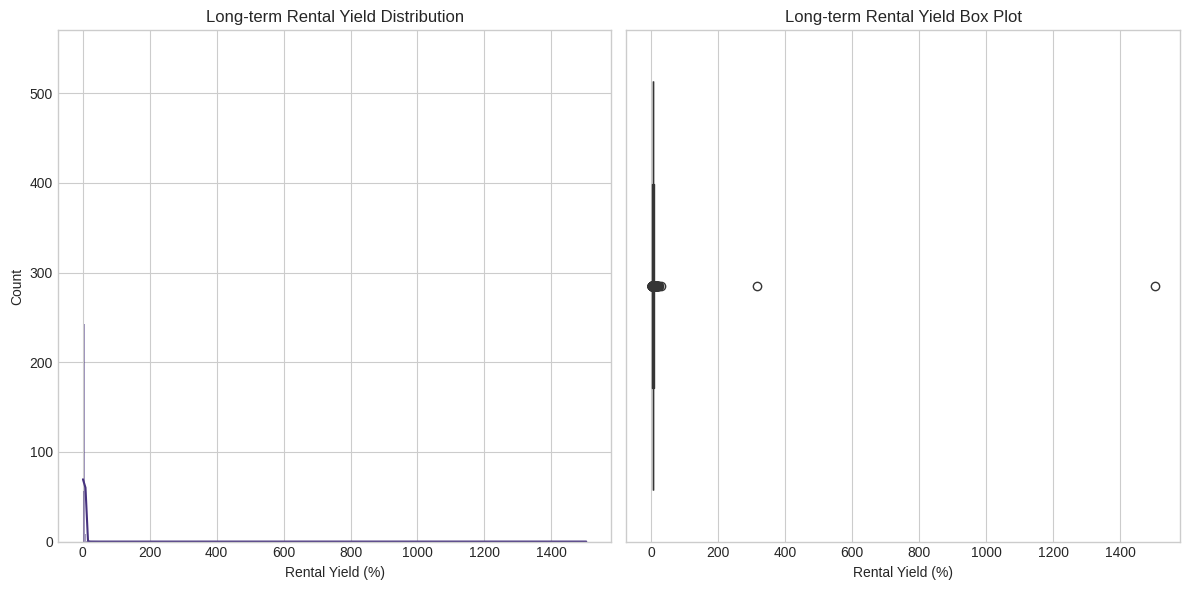

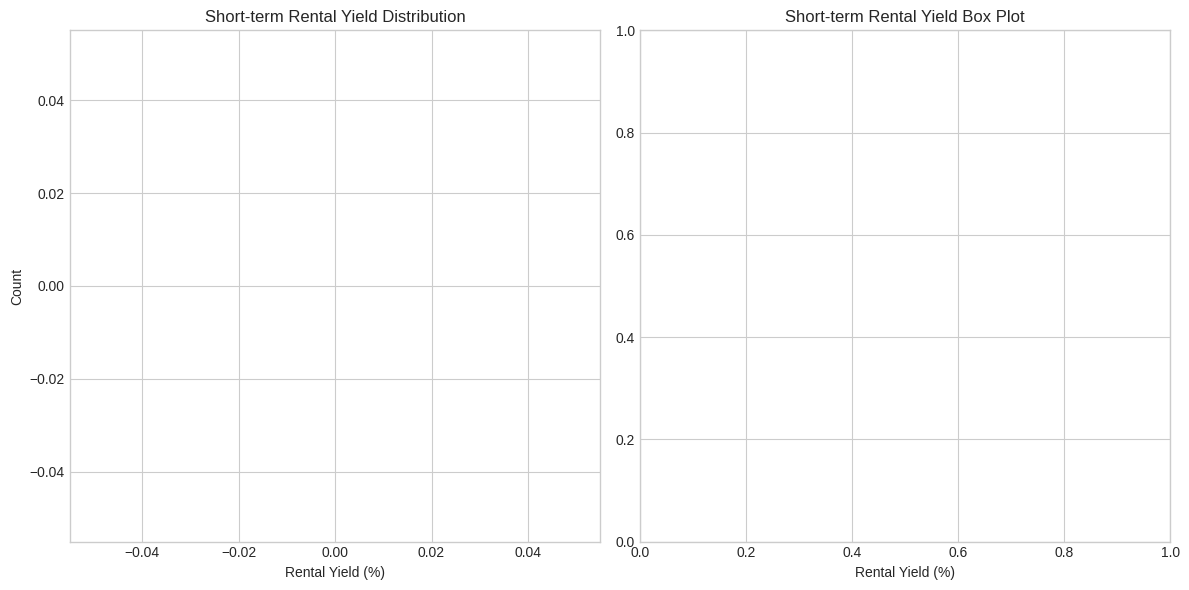

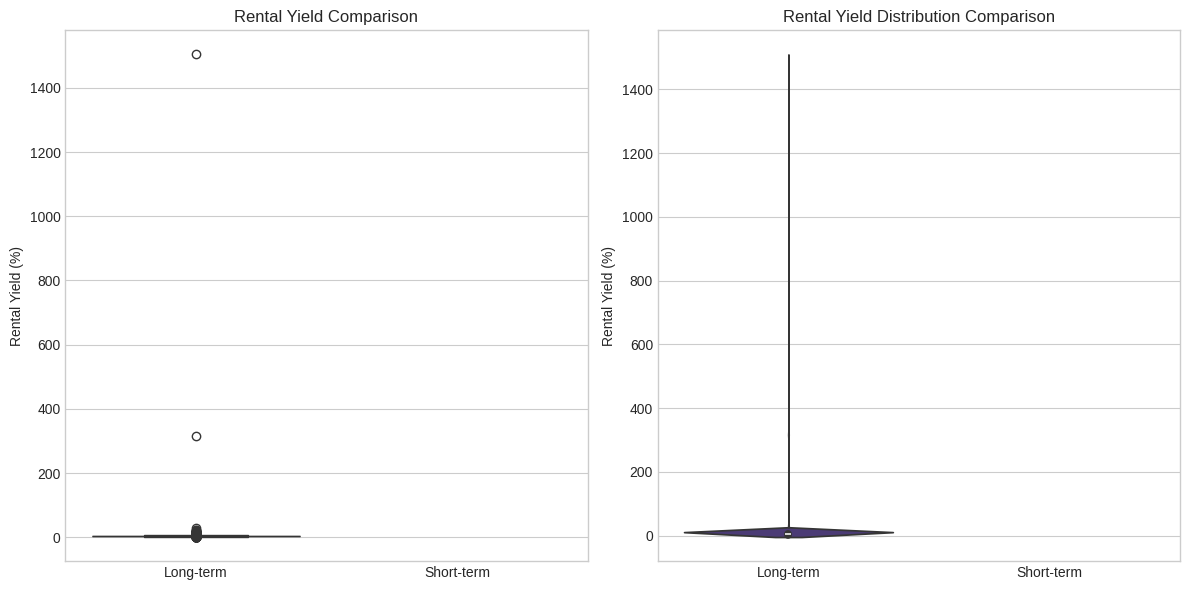

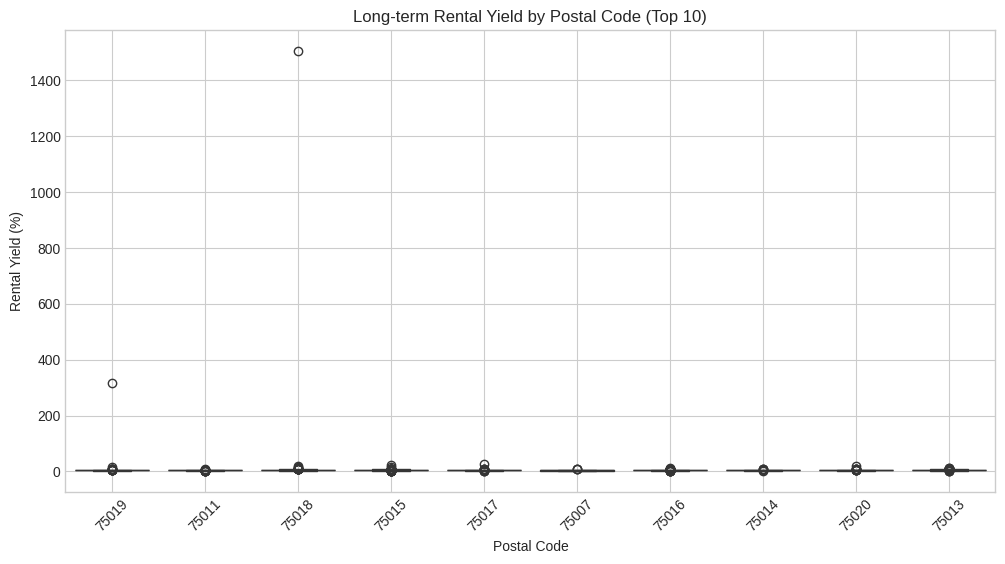

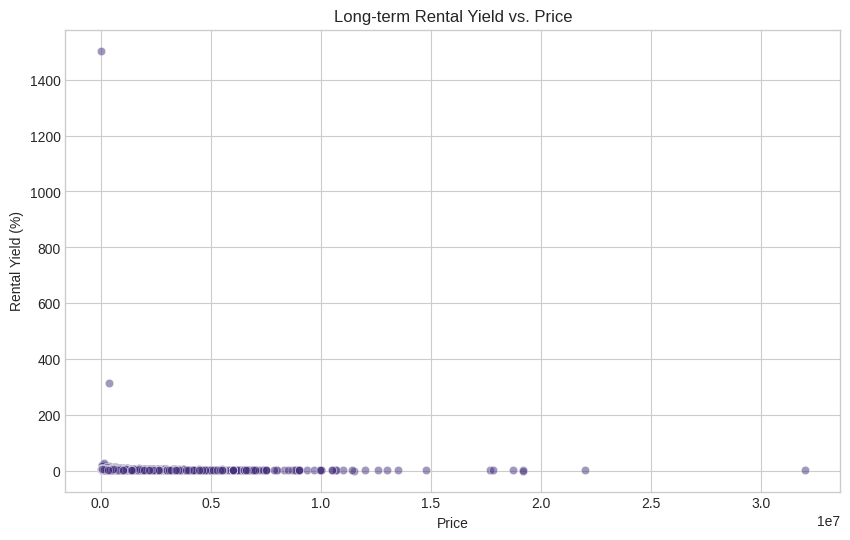

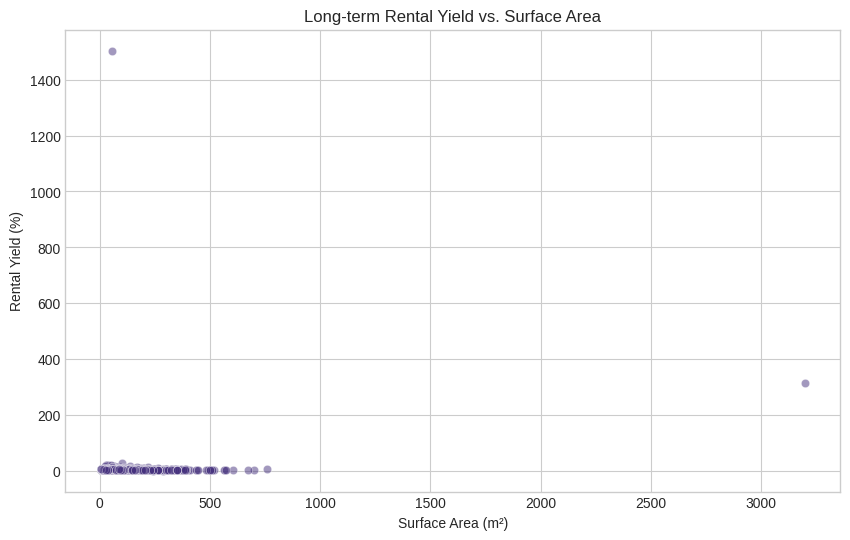

In [ ]:
# Visualize rental yields for apartments dataset
visualize_rental_yields(df_apartments_yields, "Apartments")


Visualizing rental yields for Properties Batch 1 dataset:


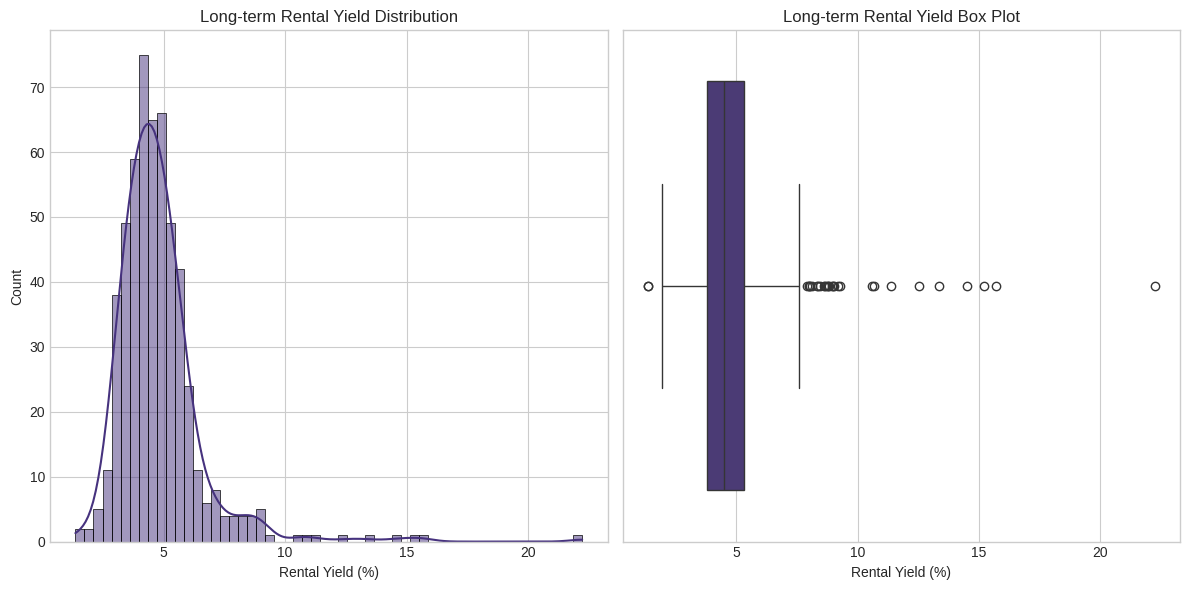

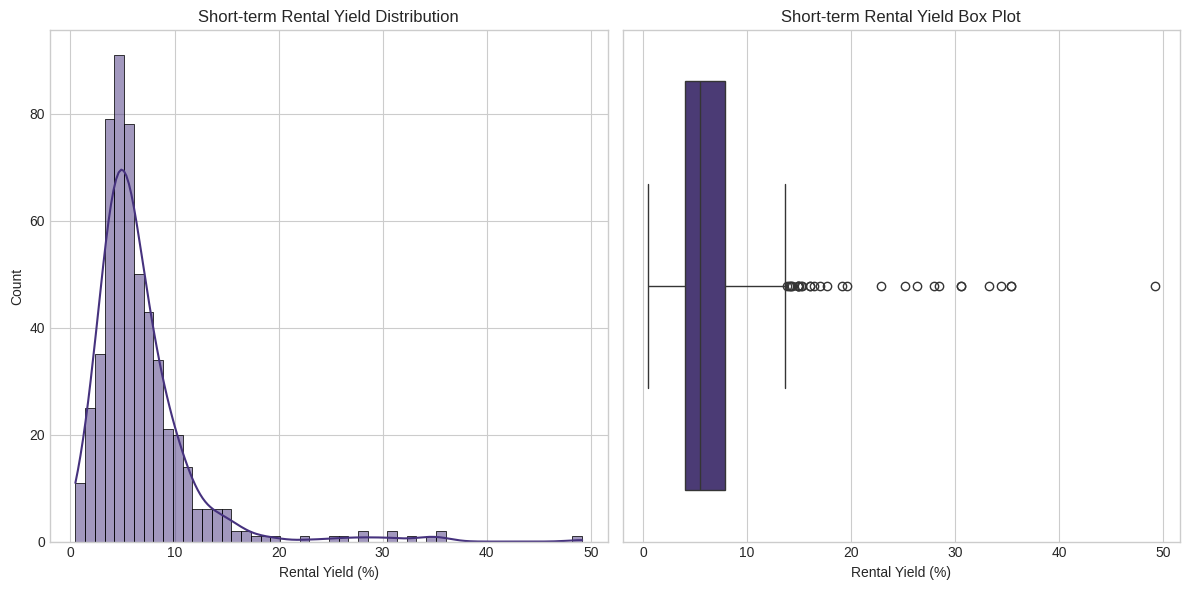

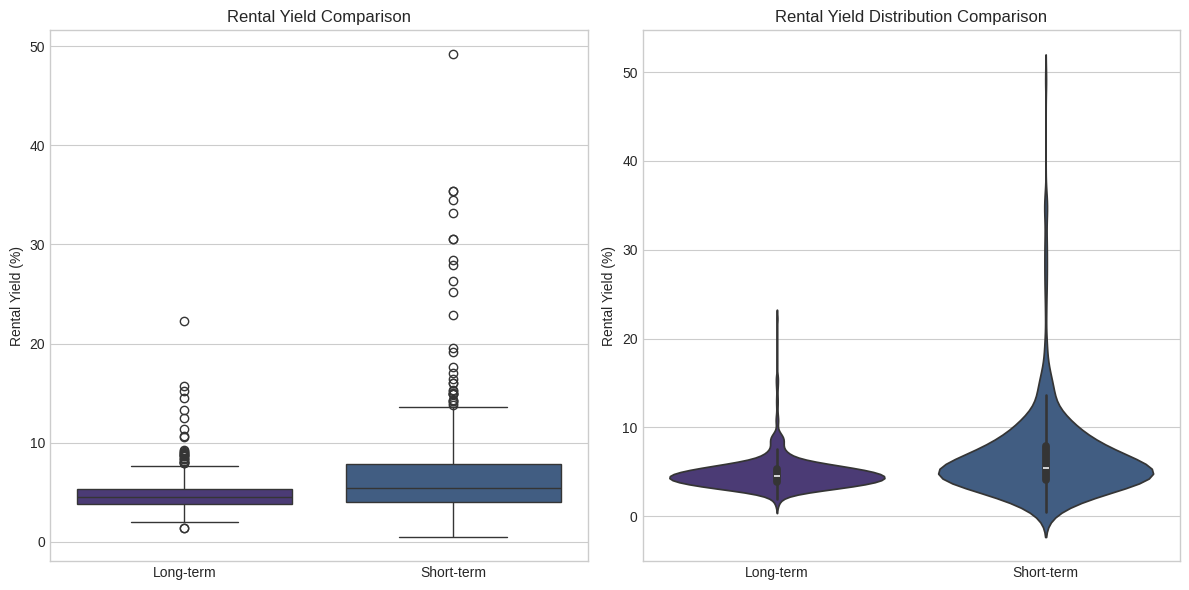

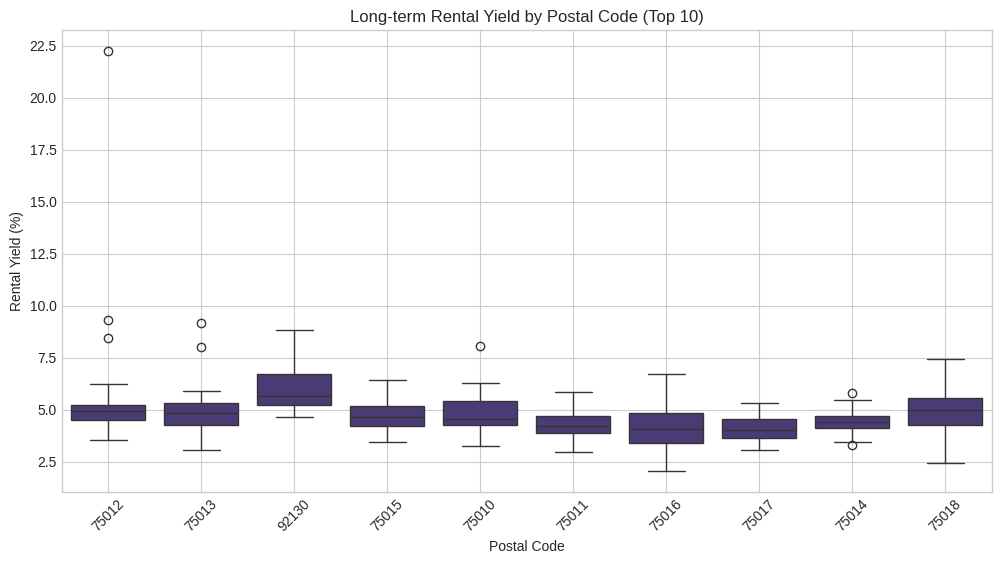

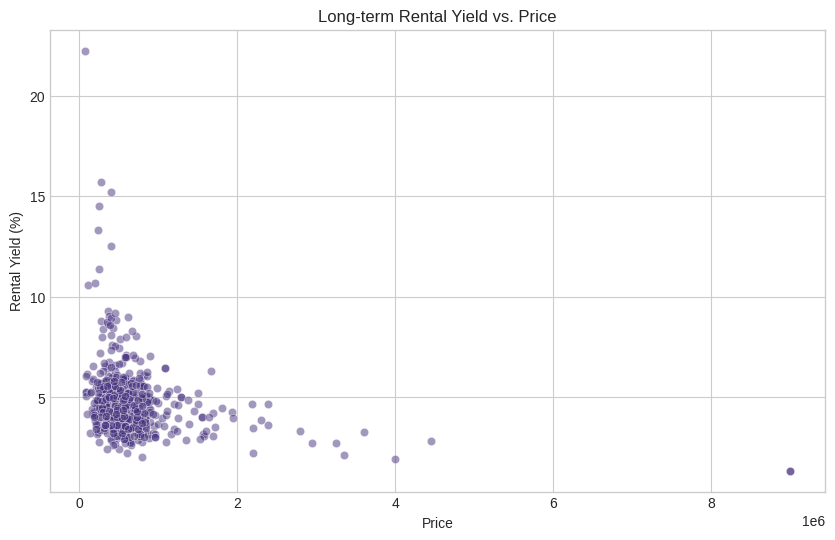

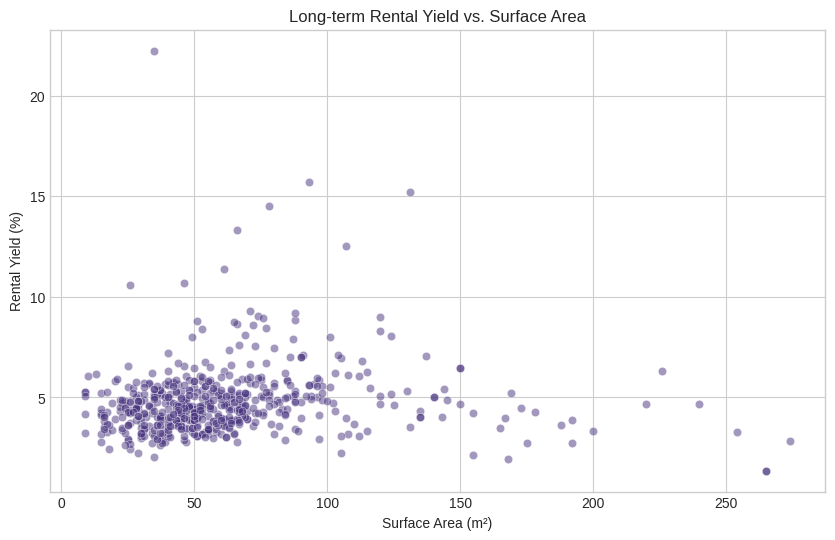

In [ ]:
# Visualize rental yields for properties batch 1 dataset
visualize_rental_yields(df_properties_batch1_yields, "Properties Batch 1")


Visualizing rental yields for Properties Batch 3 dataset:


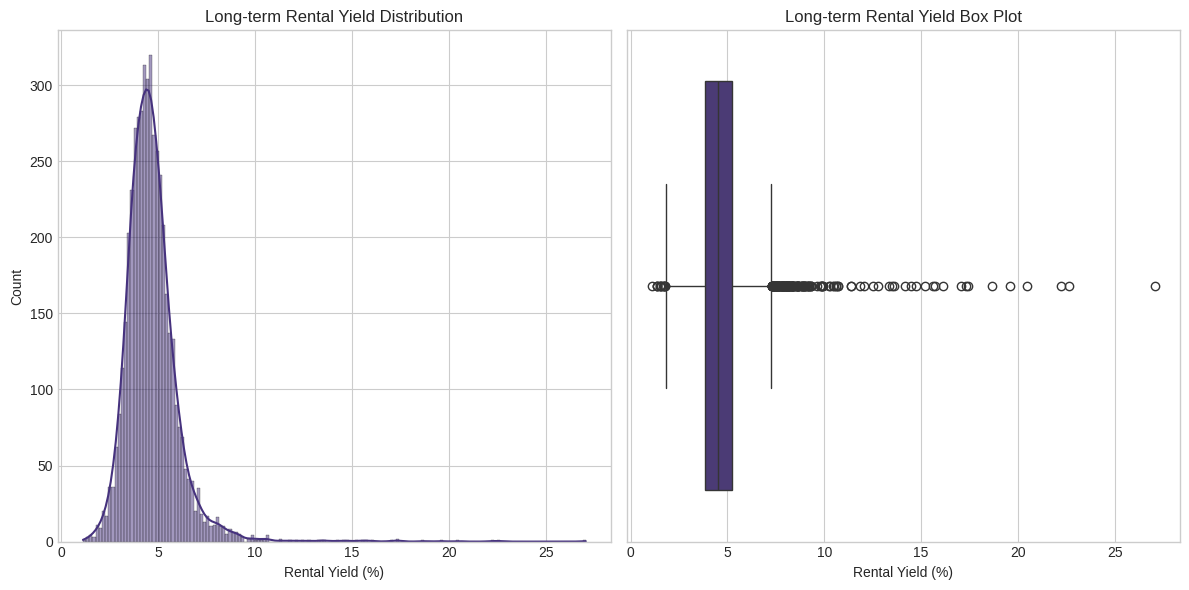

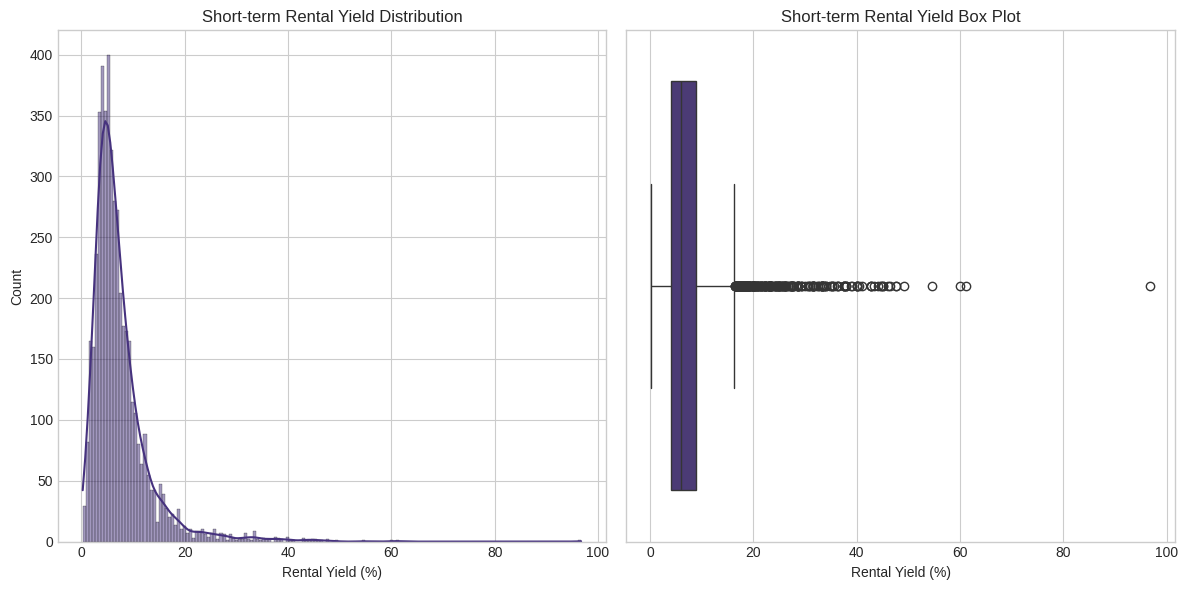

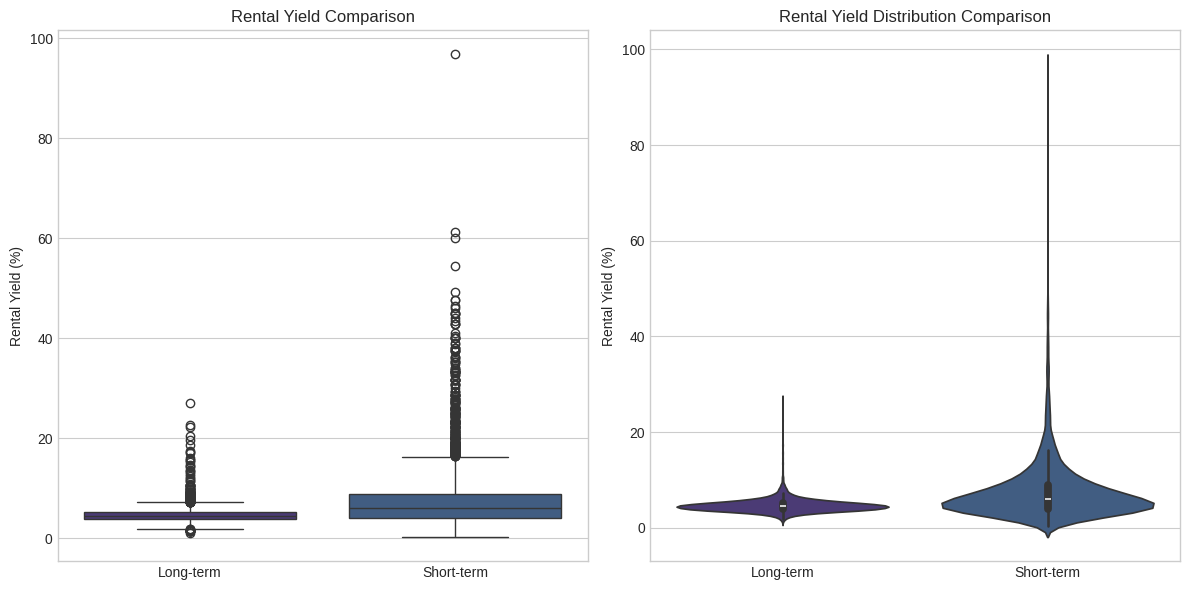

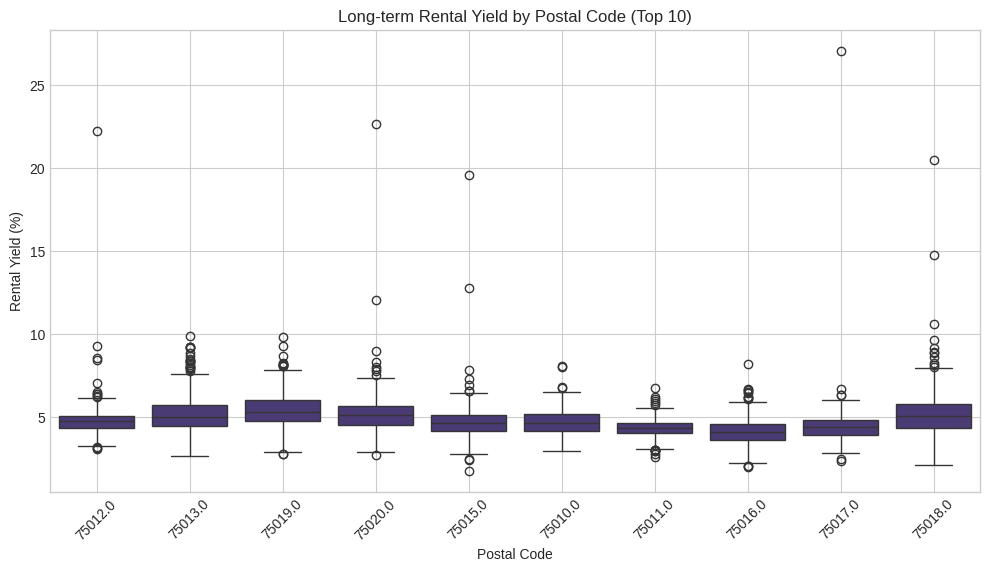

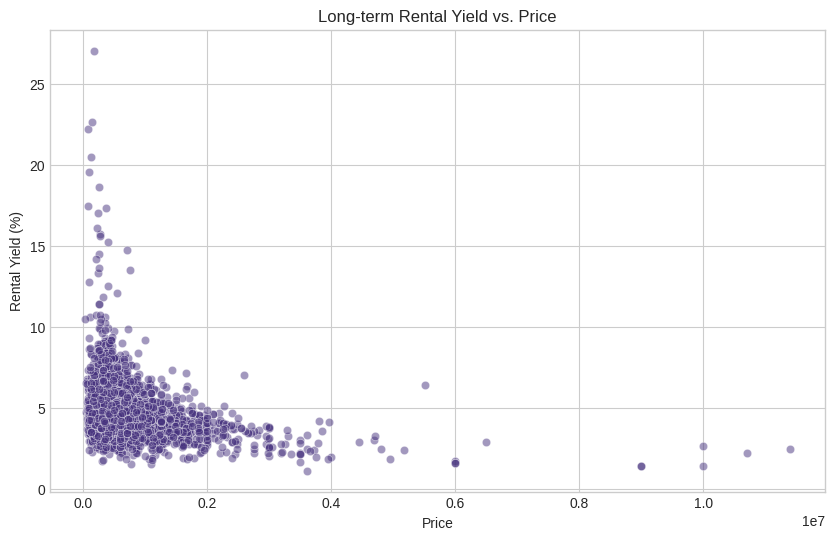

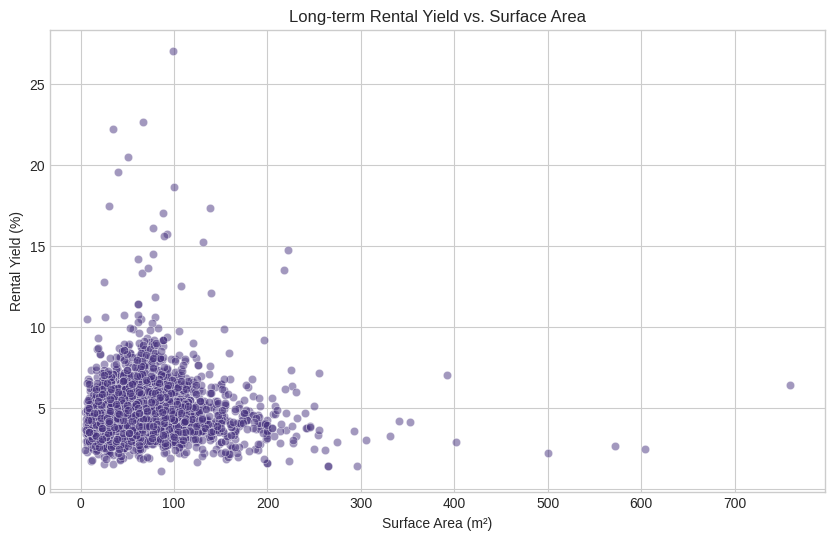

In [ ]:
# Visualize rental yields for properties batch 3 dataset
visualize_rental_yields(df_properties_batch3_yields, "Properties Batch 3")

## 3. Data Cleaning and Feature Engineering

Now that we have explored the datasets and gained insights into their structure and content, let's proceed with data cleaning and feature engineering to prepare the data for model training.

### 3.1 Data Cleaning

Let's start by cleaning the datasets to handle missing values, outliers, and inconsistencies.

In [ ]:
def clean_dataset(df, dataset_name):
    """Clean dataset by handling missing values, outliers, and inconsistencies.

    Args:
        df: Pandas DataFrame to clean
        dataset_name: Name of the dataset for display purposes

    Returns:
        Cleaned DataFrame
    """
    if df is None:
        print(f"{dataset_name} dataset is not available for cleaning.")
        return None

    print(f"Cleaning {dataset_name} dataset...")
    df_clean = df.copy()

    # Ensure key columns are numeric
    if 'price' in df_clean.columns:
        df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')
    if 'surface' in df_clean.columns:
        df_clean['surface'] = pd.to_numeric(df_clean['surface'], errors='coerce')
    if 'price_per_sqm' in df_clean.columns:
        df_clean['price_per_sqm'] = pd.to_numeric(df_clean['price_per_sqm'], errors='coerce')

    # Handle missing values in key columns
    key_columns = ['price', 'surface', 'postal_code']
    for col in key_columns:
        if col in df_clean.columns:
            missing_count = df_clean[col].isna().sum()
            if missing_count > 0:
                print(f"  {missing_count} missing values in {col} column")

    # Remove rows with missing values in key columns
    if 'price' in df_clean.columns and 'surface' in df_clean.columns:
        initial_count = len(df_clean)
        df_clean = df_clean.dropna(subset=['price', 'surface'])
        removed_count = initial_count - len(df_clean)
        print(f"  Removed {removed_count} rows with missing price or surface values")

    # Handle outliers in price column
    if 'price' in df_clean.columns:
        lower_limit = df_clean['price'].quantile(0.01)
        upper_limit = df_clean['price'].quantile(0.99)
        initial_count = len(df_clean)
        df_clean = df_clean[(df_clean['price'] >= lower_limit) & (df_clean['price'] <= upper_limit)]
        removed_count = initial_count - len(df_clean)
        print(f"  Removed {removed_count} price outliers")

    # Handle outliers in surface column
    if 'surface' in df_clean.columns:
        lower_limit = df_clean['surface'].quantile(0.01)
        upper_limit = df_clean['surface'].quantile(0.99)
        initial_count = len(df_clean)
        df_clean = df_clean[(df_clean['surface'] >= lower_limit) & (df_clean['surface'] <= upper_limit)]
        removed_count = initial_count - len(df_clean)
        print(f"  Removed {removed_count} surface area outliers")

    # Handle outliers in price_per_sqm column
    if 'price_per_sqm' in df_clean.columns:
        lower_limit = df_clean['price_per_sqm'].quantile(0.01)
        upper_limit = df_clean['price_per_sqm'].quantile(0.99)
        initial_count = len(df_clean)
        df_clean = df_clean[(df_clean['price_per_sqm'] >= lower_limit) & (df_clean['price_per_sqm'] <= upper_limit)]
        removed_count = initial_count - len(df_clean)
        print(f"  Removed {removed_count} price per sqm outliers")

    # Reset index
    df_clean = df_clean.reset_index(drop=True)

    print(f"Cleaning complete. Final shape: {df_clean.shape}")
    return df_clean

In [ ]:
# Clean each dataset
df_apartments_clean = clean_dataset(df_apartments_yields, "Apartments")
df_properties_batch1_clean = clean_dataset(df_properties_batch1_yields, "Properties Batch 1")
df_properties_batch2_clean = clean_dataset(df_properties_batch2_proc, "Properties Batch 2")
df_properties_batch3_clean = clean_dataset(df_properties_batch3_yields, "Properties Batch 3")
df_airbnb_listings_clean = clean_dataset(df_airbnb_listings, "Airbnb Listings")

Cleaning Apartments dataset...
  26 missing values in surface column
  Removed 26 rows with missing price or surface values
  Removed 208 price outliers
  Removed 190 surface area outliers
  Removed 10173 price per sqm outliers
Cleaning complete. Final shape: (0, 48)
Cleaning Properties Batch 1 dataset...
  1 missing values in surface column
  Removed 1 rows with missing price or surface values
  Removed 12 price outliers
  Removed 8 surface area outliers
Cleaning complete. Final shape: (523, 83)
Cleaning Properties Batch 2 dataset...
  4 missing values in surface column
  Removed 4 rows with missing price or surface values
  Removed 16 price outliers
  Removed 12 surface area outliers
  Removed 16 price per sqm outliers
Cleaning complete. Final shape: (689, 79)
Cleaning Properties Batch 3 dataset...
  57 missing values in surface column
  Removed 57 rows with missing price or surface values
  Removed 93 price outliers
  Removed 94 surface area outliers
Cleaning complete. Final shape: 

### 3.2 Feature Engineering

Let's engineer additional features that could be useful for predicting rental yields and investment scores.

In [ ]:
# Function to engineer features
def engineer_features(df, dataset_name):
    """Engineer additional features for a dataset.

    Args:
        df: Pandas DataFrame to engineer features for
        dataset_name: Name of the dataset for display purposes

    Returns:
        DataFrame with engineered features
    """
    if df is None:
        print(f"{dataset_name} dataset is not available for feature engineering.")
        return None

    print(f"Engineering features for {dataset_name} dataset...")
    df_features = df.copy()

    # Extract district from postal code
    if 'postal_code' in df_features.columns:
        df_features['district'] = df_features['postal_code']
        print(f"  Created district feature from postal code")

    # Calculate price per room
    if 'price' in df_features.columns and any(col for col in df_features.columns if 'room' in col.lower()):
        # Find the room column
        room_cols = [col for col in df_features.columns if 'room' in col.lower() and df_features[col].dtype != 'object']
        if room_cols:
            room_col = room_cols[0]
            df_features['price_per_room'] = df_features['price'] / df_features[room_col]
            df_features['price_per_room'] = df_features['price_per_room'].replace([np.inf, -np.inf], np.nan)
            print(f"  Created price per room feature using {room_col} column")

    # Extract property type from description or title
    description_cols = [col for col in df_features.columns if 'description' in col.lower() or 'title' in col.lower()]
    if description_cols:
        description_col = description_cols[0]

        # Check for apartment keywords
        apartment_keywords = ['apartment', 'flat', 'studio', 'appartement', 'appt', 'T1', 'T2', 'T3', 'T4']
        df_features['is_apartment'] = df_features[description_col].astype(str).apply(
            lambda x: any(keyword.lower() in x.lower() for keyword in apartment_keywords))

        # Check for house keywords
        house_keywords = ['house', 'villa', 'maison', 'pavillon', 'townhouse']
        df_features['is_house'] = df_features[description_col].astype(str).apply(
            lambda x: any(keyword.lower() in x.lower() for keyword in house_keywords))

        # Check for luxury keywords
        luxury_keywords = ['luxury', 'luxe', 'premium', 'high-end', 'haut de gamme', 'prestige']
        df_features['is_luxury'] = df_features[description_col].astype(str).apply(
            lambda x: any(keyword.lower() in x.lower() for keyword in luxury_keywords))

        # Check for renovation keywords
        renovation_keywords = ['renovated', 'rénové', 'refurbished', 'modernized', 'updated']
        df_features['is_renovated'] = df_features[description_col].astype(str).apply(
            lambda x: any(keyword.lower() in x.lower() for keyword in renovation_keywords))

        print(f"  Created property type and condition features from {description_col} column")

    # Create features for amenities
    amenity_features = {
        'has_balcony': ['balcony', 'balcon', 'terrace', 'terrasse'],
        'has_parking': ['parking', 'garage', 'stationnement'],
        'has_elevator': ['elevator', 'ascenseur', 'lift'],
        'has_garden': ['garden', 'jardin', 'yard', 'cour'],
        'has_pool': ['pool', 'piscine', 'swimming']
    }

    if description_cols:
        for feature, keywords in amenity_features.items():
            df_features[feature] = df_features[description_col].astype(str).apply(
                lambda x: any(keyword.lower() in x.lower() for keyword in keywords))

        print(f"  Created amenity features from {description_col} column")

    # Create energy efficiency feature
    energy_cols = [col for col in df_features.columns if 'energy' in col.lower() or 'dpe' in col.lower()]
    if energy_cols:
        energy_col = energy_cols[0]

        # Extract energy rating (A to G)
        def extract_energy_rating(text):
            if pd.isna(text):
                return None

            text = str(text).upper()
            for rating in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
                if rating in text:
                    return rating
            return None

        df_features['energy_category'] = df_features[energy_col].apply(extract_energy_rating)
        print(f"  Created energy category feature from {energy_col} column")

    # Create price-to-rent ratio feature
    if 'price' in df_features.columns and 'estimated_annual_rent' in df_features.columns:
        df_features['price_to_rent_ratio'] = df_features['price'] / df_features['estimated_annual_rent']
        df_features['price_to_rent_ratio'] = df_features['price_to_rent_ratio'].replace([np.inf, -np.inf], np.nan)
        print(f"  Created price-to-rent ratio feature")

    # Create investment score feature (if both long-term and short-term rental yields are available)
    if 'long_term_rental_yield' in df_features.columns:
        # Normalize long-term rental yield (0-1 scale)
        max_yield = df_features['long_term_rental_yield'].quantile(0.95)
        df_features['normalized_long_term_yield'] = df_features['long_term_rental_yield'] / max_yield
        df_features['normalized_long_term_yield'] = df_features['normalized_long_term_yield'].clip(0, 1)

        # Create base investment score from long-term rental yield
        df_features['investment_score'] = df_features['normalized_long_term_yield']

        # Adjust for short-term rental yield if available
        if 'short_term_rental_yield' in df_features.columns:
            max_yield = df_features['short_term_rental_yield'].quantile(0.95)
            df_features['normalized_short_term_yield'] = df_features['short_term_rental_yield'] / max_yield
            df_features['normalized_short_term_yield'] = df_features['normalized_short_term_yield'].clip(0, 1)

            # Combine yields with higher weight for long-term (more stable)
            df_features['investment_score'] = 0.7 * df_features['normalized_long_term_yield'] + 0.3 * df_features['normalized_short_term_yield']

        # Adjust for property condition if available
        if 'is_renovated' in df_features.columns:
            df_features['investment_score'] = df_features['investment_score'] + 0.1 * df_features['is_renovated']

        # Adjust for energy efficiency if available
        if 'energy_category' in df_features.columns:
            energy_mapping = {'A': 0.1, 'B': 0.08, 'C': 0.06, 'D': 0.04, 'E': 0.02, 'F': 0, 'G': -0.05}
            df_features['energy_score'] = df_features['energy_category'].map(energy_mapping).fillna(0)
            df_features['investment_score'] = df_features['investment_score'] + df_features['energy_score']

        # Ensure investment score is between 0 and 1
        df_features['investment_score'] = df_features['investment_score'].clip(0, 1)

        print(f"  Created investment score feature")

    print(f"Feature engineering complete. Final shape: {df_features.shape}")
    return df_features

In [ ]:
# Engineer features for each dataset
df_apartments_features = engineer_features(df_apartments_clean, "Apartments")
df_properties_batch1_features = engineer_features(df_properties_batch1_clean, "Properties Batch 1")
df_properties_batch3_features = engineer_features(df_properties_batch3_clean, "Properties Batch 3")

Engineering features for Apartments dataset...
  Created district feature from postal code
  Created price per room feature using number_of_rooms column
  Created property type and condition features from full_description column
  Created amenity features from full_description column
  Created energy category feature from energy_class column
  Created investment score feature
Feature engineering complete. Final shape: (0, 63)
Engineering features for Properties Batch 1 dataset...
  Created district feature from postal code
  Created price per room feature using has_living_room_image column
  Created property type and condition features from seo_title column
  Created amenity features from seo_title column
  Created energy category feature from estimated_energy_bill column
  Created investment score feature
Feature engineering complete. Final shape: (523, 99)
Engineering features for Properties Batch 3 dataset...
  Created district feature from postal code
  Created price per room featu

### 3.3 Dataset Aggregation

Now, let's aggregate the datasets to create a unified dataset for model training.

In [ ]:
# Function to aggregate datasets
def aggregate_datasets(datasets, dataset_names):
    """Aggregate multiple datasets into a unified dataset.

    Args:
        datasets: List of Pandas DataFrames to aggregate
        dataset_names: List of dataset names for display purposes

    Returns:
        Aggregated DataFrame
    """
    print("Aggregating datasets...")

    # Filter out None datasets
    valid_datasets = []
    valid_names = []
    for df, name in zip(datasets, dataset_names):
        if df is not None:
            valid_datasets.append(df)
            valid_names.append(name)

    if not valid_datasets:
        print("No valid datasets to aggregate.")
        return None

    # Identify common columns
    common_columns = set(valid_datasets[0].columns)
    for df in valid_datasets[1:]:
        common_columns = common_columns.intersection(set(df.columns))

    print(f"Found {len(common_columns)} common columns across datasets: {common_columns}")

    # Ensure key columns are present
    key_columns = ['price', 'surface', 'postal_code', 'price_per_sqm']
    missing_key_columns = [col for col in key_columns if col not in common_columns]
    if missing_key_columns:
        print(f"Warning: Missing key columns in common columns: {missing_key_columns}")

    # Add dataset identifier column
    for i, (df, name) in enumerate(zip(valid_datasets, valid_names)):
        df['dataset_source'] = name

    # Concatenate datasets
    df_aggregated = pd.concat(valid_datasets, ignore_index=True)

    # Remove duplicate rows
    initial_count = len(df_aggregated)
    df_aggregated = df_aggregated.drop_duplicates(subset=['price', 'surface', 'postal_code'], keep='first')
    removed_count = initial_count - len(df_aggregated)
    print(f"Removed {removed_count} duplicate rows")

    # Reset index
    df_aggregated = df_aggregated.reset_index(drop=True)

    print(f"Aggregation complete. Final shape: {df_aggregated.shape}")
    return df_aggregated

In [ ]:
# Aggregate datasets
datasets = [df_apartments_features, df_properties_batch1_features, df_properties_batch3_features]
dataset_names = ["Apartments", "Properties Batch 1", "Properties Batch 3"]
df_aggregated = aggregate_datasets(datasets, dataset_names)

Aggregating datasets...
Found 29 common columns across datasets: {'long_term_rental_yield', 'is_house', 'has_elevator', 'surface', 'image_urls', 'is_renovated', 'has_garden', 'is_apartment', 'is_luxury', 'price_per_room', 'has_brokerage_fee', 'postal_code', 'energy_score', 'has_pool', 'normalized_long_term_yield', 'has_parking', 'investment_score', 'short_term_rental_yield', 'energy_category', 'is_exclusive', 'estimated_monthly_rent', 'estimated_airbnb_income', 'price', 'median_nightly_rate', 'brand', 'has3_d_visit', 'district', 'has_balcony', 'normalized_short_term_yield'}
Removed 268 duplicate rows
Aggregation complete. Final shape: (4820, 134)


In [ ]:
# Examine the aggregated dataset
if df_aggregated is not None:
    print("Aggregated Dataset Summary:")
    print(f"Shape: {df_aggregated.shape}")
    print("\nColumns:")
    print(df_aggregated.columns.tolist())
    print("\nMissing values:")
    missing = df_aggregated.isnull().sum()
    print(missing[missing > 0].sort_values(ascending=False))
    print("\nDataset sources:")
    print(df_aggregated['dataset_source'].value_counts())

    # Check for key features
    key_features = ['price', 'surface', 'postal_code', 'price_per_sqm', 'long_term_rental_yield', 'investment_score']
    print("\nKey features availability:")
    for feature in key_features:
        if feature in df_aggregated.columns:
            print(f"  {feature}: {df_aggregated[feature].notna().sum()} non-null values")
        else:
            print(f"  {feature}: Not available")

Aggregated Dataset Summary:
Shape: (4820, 134)

Columns:
['id', 'url', 'has3_d_visit', 'is_exclusive', 'has_brokerage_fee', 'type', 'brand', 'portal', 'status', 'image_urls', 'virtual_tours_available', 'floorplans_available', 'city', 'country', 'district', 'zip_code', 'update_date', 'creation_date', 'provider_rating', 'provider_reviews', 'provider_address', 'provider_website', 'provider_phone_numbers', 'agency_name', 'agency_logo_url', 'agency_legal_information', 'price', 'number_of_rooms', 'surface', 'number_of_bedrooms', 'property_type', 'distribution_type', 'formatted_price', 'price_per_sqm', 'number_of_rooms_hardfact', 'number_of_bedrooms_hardfact', 'living_space_sqm_hardfact', 'floor_info', 'energy_class', 'headline', 'full_description', 'year_of_construction', 'postal_code', 'estimated_monthly_rent', 'median_nightly_rate', 'estimated_airbnb_income', 'long_term_rental_yield', 'short_term_rental_yield', 'price_per_room', 'is_apartment', 'is_house', 'is_luxury', 'is_renovated', 'has

### 3.4 Final Dataset Preparation

Let's prepare the final dataset for model training by handling any remaining missing values and creating train/test splits.

In [ ]:
# Function to prepare final dataset
def prepare_final_dataset(df, target_columns):
    """Prepare final dataset for model training.

    Args:
        df: Pandas DataFrame to prepare
        target_columns: List of target column names

    Returns:
        Prepared DataFrame
    """
    if df is None:
        print("No dataset to prepare.")
        return None

    print("Preparing final dataset...")
    df_final = df.copy()

    # Check for target columns
    missing_targets = [col for col in target_columns if col not in df_final.columns]
    if missing_targets:
        print(f"Warning: Missing target columns: {missing_targets}")

    # Filter rows with non-null target values
    for target in target_columns:
        if target in df_final.columns:
            initial_count = len(df_final)
            df_final = df_final[df_final[target].notna()]
            removed_count = initial_count - len(df_final)
            print(f"Removed {removed_count} rows with missing {target} values")

    # Select relevant features
    numeric_features = ['price', 'surface', 'price_per_sqm']
    if 'price_per_room' in df_final.columns:
        numeric_features.append('price_per_room')

    categorical_features = ['postal_code', 'district']
    if 'energy_category' in df_final.columns:
        categorical_features.append('energy_category')

    boolean_features = []
    for col in df_final.columns:
        if df_final[col].dtype == bool:
            boolean_features.append(col)

    # Combine all features
    all_features = numeric_features + categorical_features + boolean_features
    print(f"Selected {len(all_features)} features: {all_features}")

    # Handle missing values in features
    for feature in numeric_features:
        if feature in df_final.columns and df_final[feature].isna().sum() > 0:
            df_final[feature] = df_final[feature].fillna(df_final[feature].median())
            print(f"Filled missing values in {feature} with median")

    for feature in categorical_features:
        if feature in df_final.columns and df_final[feature].isna().sum() > 0:
            df_final[feature] = df_final[feature].fillna('Unknown')
            print(f"Filled missing values in {feature} with 'Unknown'")

    for feature in boolean_features:
        if feature in df_final.columns and df_final[feature].isna().sum() > 0:
            df_final[feature] = df_final[feature].fillna(False)
            print(f"Filled missing values in {feature} with False")

    # Create final feature and target datasets
    X = df_final[all_features]
    y_dict = {}
    for target in target_columns:
        if target in df_final.columns:
            y_dict[target] = df_final[target]

    print(f"Final dataset preparation complete. Shape: {X.shape}")
    return X, y_dict, all_features

In [ ]:
# Prepare final dataset
target_columns = ['long_term_rental_yield', 'short_term_rental_yield', 'investment_score']
X, y_dict, all_features = prepare_final_dataset(df_aggregated, target_columns)

Preparing final dataset...
Removed 0 rows with missing long_term_rental_yield values
Removed 0 rows with missing short_term_rental_yield values
Removed 0 rows with missing investment_score values
Selected 7 features: ['price', 'surface', 'price_per_sqm', 'price_per_room', 'postal_code', 'district', 'energy_category']
Filled missing values in price_per_sqm with median
Filled missing values in price_per_room with median
Filled missing values in energy_category with 'Unknown'
Final dataset preparation complete. Shape: (4820, 7)


In [ ]:
# Create train/test splits for each target
train_test_splits = {}
for target, y in y_dict.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train_test_splits[target] = (X_train, X_test, y_train, y_test)
    print(f"Created train/test split for {target}: Train shape = {X_train.shape}, Test shape = {X_test.shape}")

Created train/test split for long_term_rental_yield: Train shape = (3856, 7), Test shape = (964, 7)
Created train/test split for short_term_rental_yield: Train shape = (3856, 7), Test shape = (964, 7)
Created train/test split for investment_score: Train shape = (3856, 7), Test shape = (964, 7)


### 3.5 Feature Importance Analysis

Let's analyze feature importance to understand which features are most predictive of rental yields and investment scores.

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor


Processing target: long_term_rental_yield
Analyzing feature importance for long_term_rental_yield...


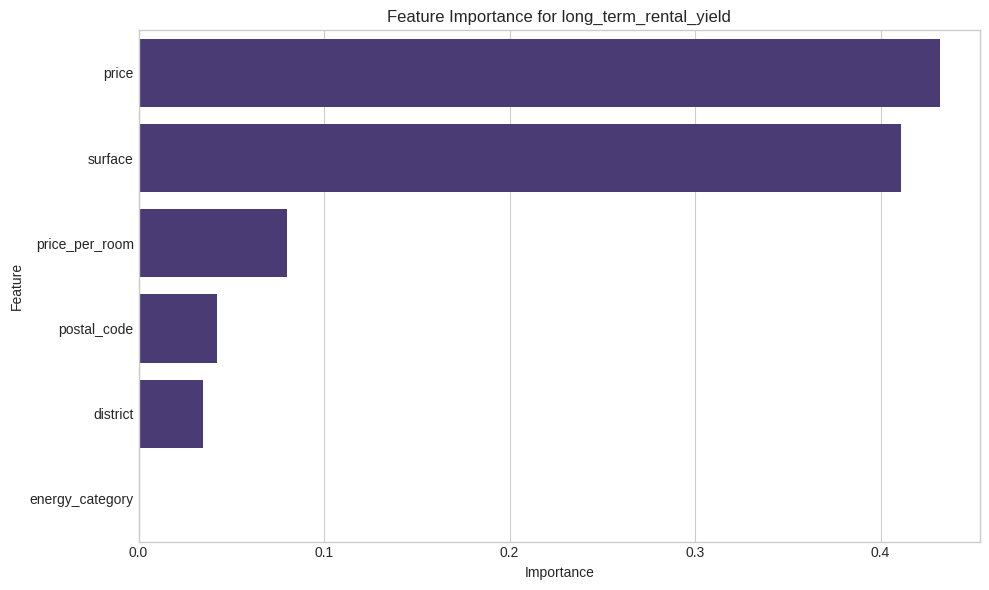


Processing target: short_term_rental_yield
Analyzing feature importance for short_term_rental_yield...


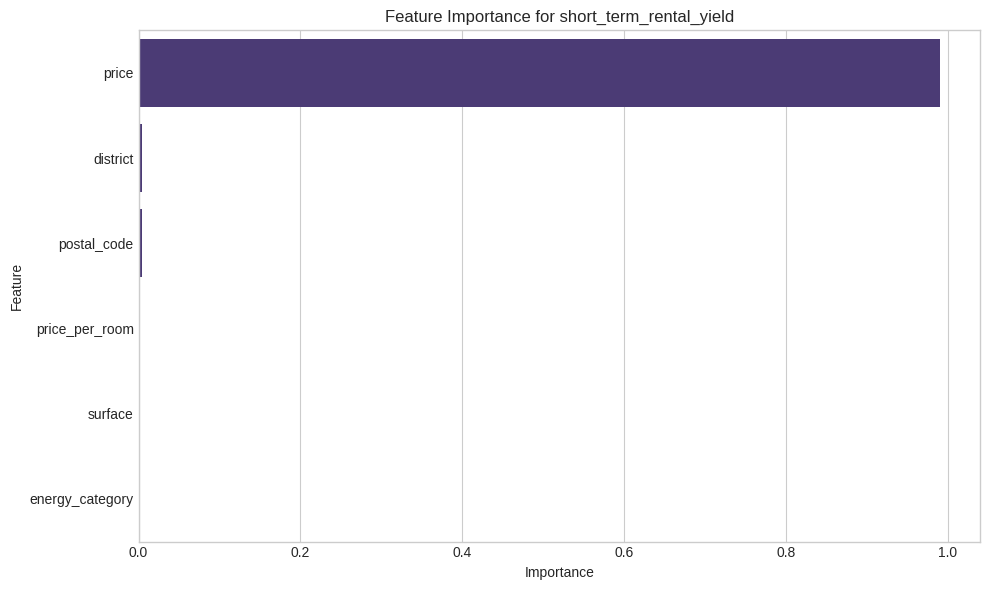


Processing target: investment_score
Analyzing feature importance for investment_score...


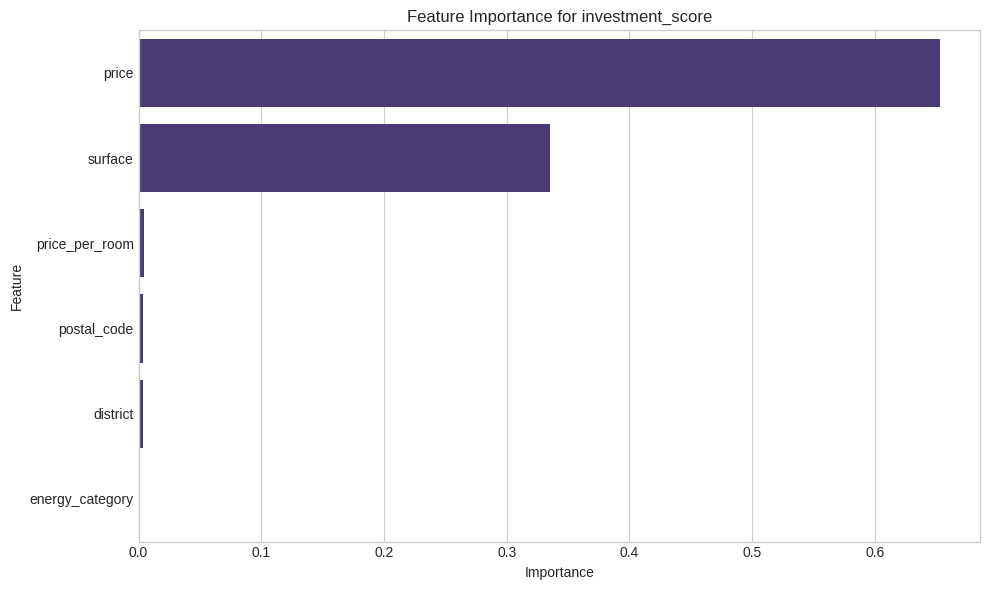

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze_feature_importance(X, y, feature_names, target_name):
    print(f"Analyzing feature importance for {target_name}...")

    # Filter out features that are entirely missing
    valid_features = [f for f in feature_names if X[f].notna().any()]
    X = X[valid_features]

    # Identify numeric and categorical features
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    boolean_features = X.select_dtypes(include=['bool']).columns.tolist()

    # Define preprocessing pipeline
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features),
            ('bool', 'passthrough', boolean_features)
        ])

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    # Fit the model
    model.fit(X, y)

    # Extract feature importances
    model.named_steps['preprocessor'].fit(X)
    ohe = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
    cat_feature_names = ohe.get_feature_names_out(categorical_features)
    all_feature_names = numeric_features + list(cat_feature_names) + boolean_features

    importances = model.named_steps['regressor'].feature_importances_

    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    # Group by original feature names
    grouped_importances = {}
    for feature in feature_names:
        if feature in numeric_features or feature in boolean_features:
            grouped_importances[feature] = importance_df[importance_df['feature'] == feature]['importance'].sum()
        elif feature in categorical_features:
            grouped_importances[feature] = importance_df[importance_df['feature'].str.startswith(f"{feature}_")]['importance'].sum()

    grouped_df = pd.DataFrame({
        'feature': grouped_importances.keys(),
        'importance': grouped_importances.values()
    }).sort_values('importance', ascending=False)

    # Plot results
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=grouped_df.head(15))
    plt.title(f"Feature Importance for {target_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    return grouped_df

# Before analysis, handle missing values in your data
# For your specific columns with missing values:
X_train['price_per_sqm'] = X_train['price_per_sqm'].fillna(X_train['price_per_sqm'].median())

# Now run the analysis
feature_importances = {}
for target, (X_train_split, X_test_split, y_train_split, y_test_split) in train_test_splits.items():
    print(f"\nProcessing target: {target}")
    feature_importances[target] = analyze_feature_importance(
        X_train_split,
        y_train_split,
        X_train_split.columns.tolist(),  # Use actual columns from split data
        target
    )


Processing target: long_term_rental_yield
Analyzing feature importance for long_term_rental_yield...
Features: 3 numeric, 3 categorical, 0 boolean
Model training completed


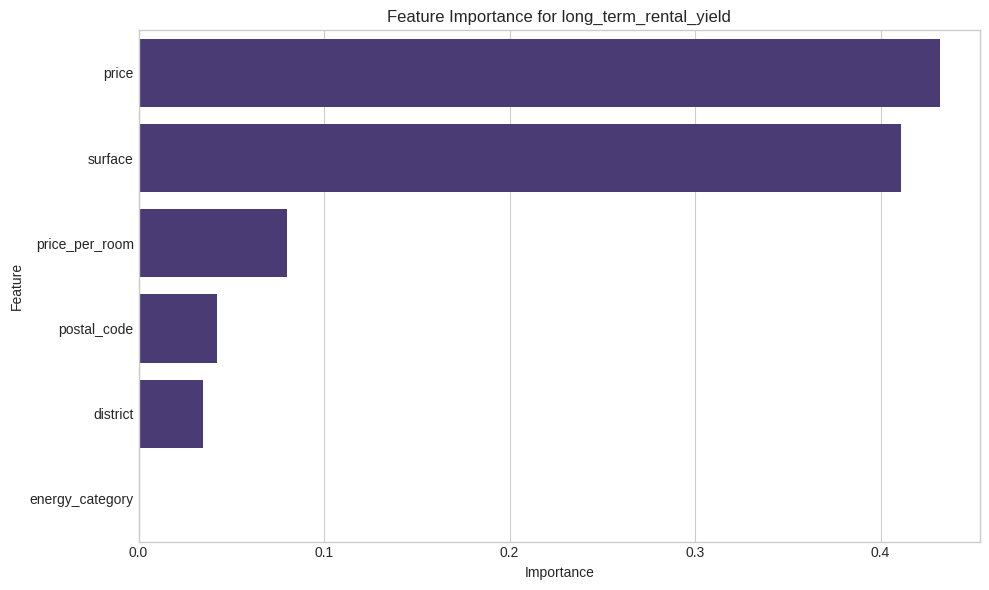


Evaluating model for long_term_rental_yield...


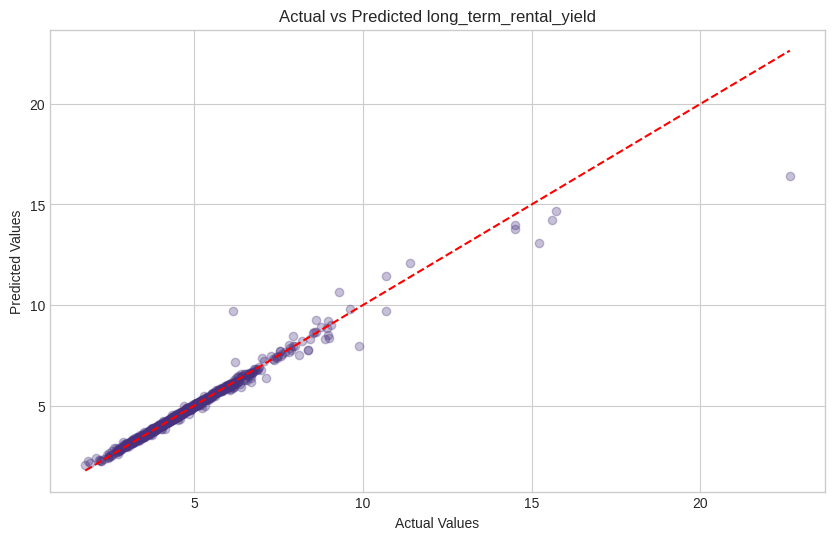

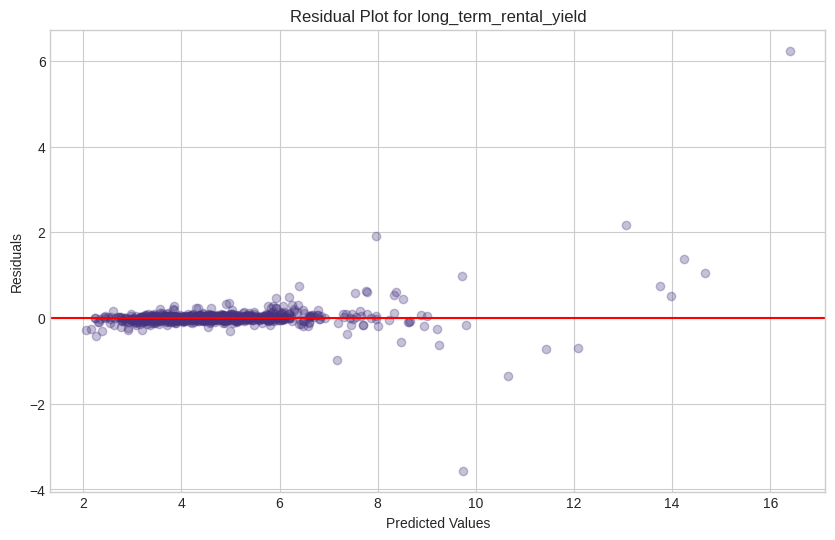


Evaluation Metrics for long_term_rental_yield:
MAE: 0.07
RMSE: 0.28
R²: 0.9672
MAPE: 1.30%

Processing target: short_term_rental_yield
Analyzing feature importance for short_term_rental_yield...
Features: 3 numeric, 3 categorical, 0 boolean
Model training completed


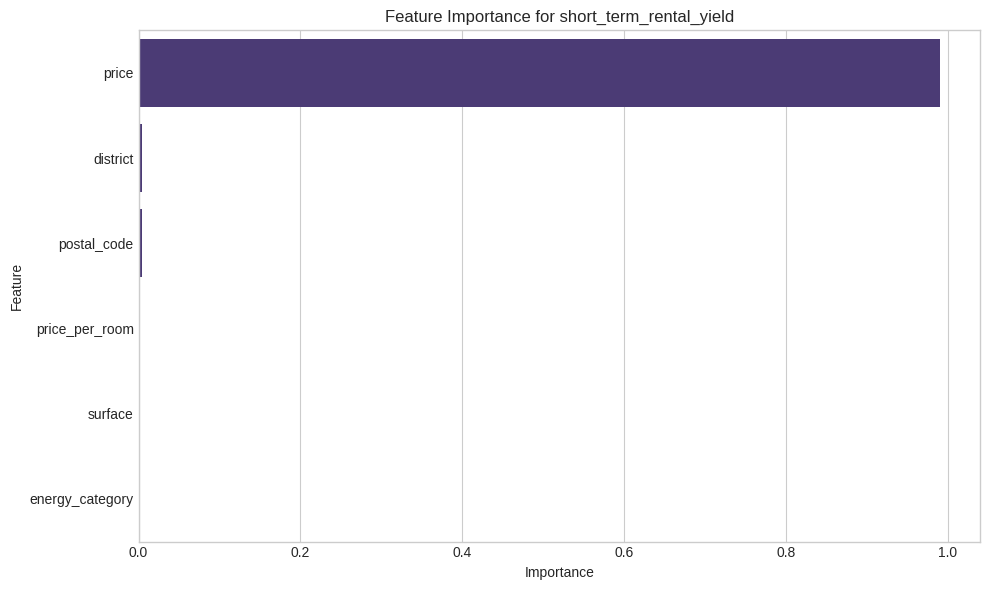


Evaluating model for short_term_rental_yield...


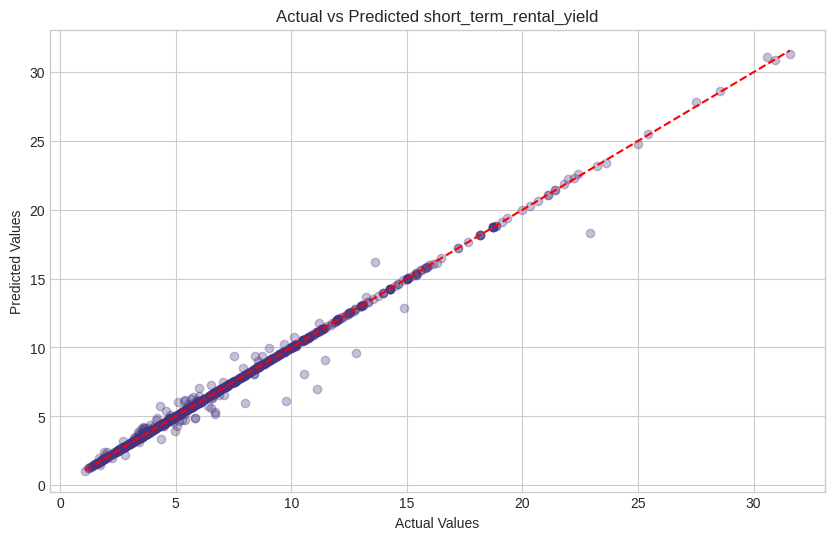

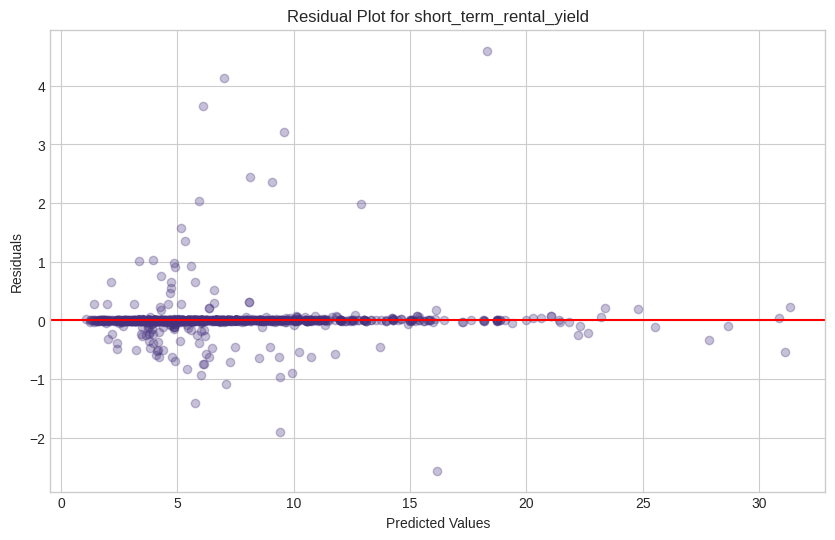


Evaluation Metrics for short_term_rental_yield:
MAE: 0.08
RMSE: 0.35
R²: 0.9936
MAPE: 1.26%

Processing target: investment_score
Analyzing feature importance for investment_score...
Features: 3 numeric, 3 categorical, 0 boolean
Model training completed


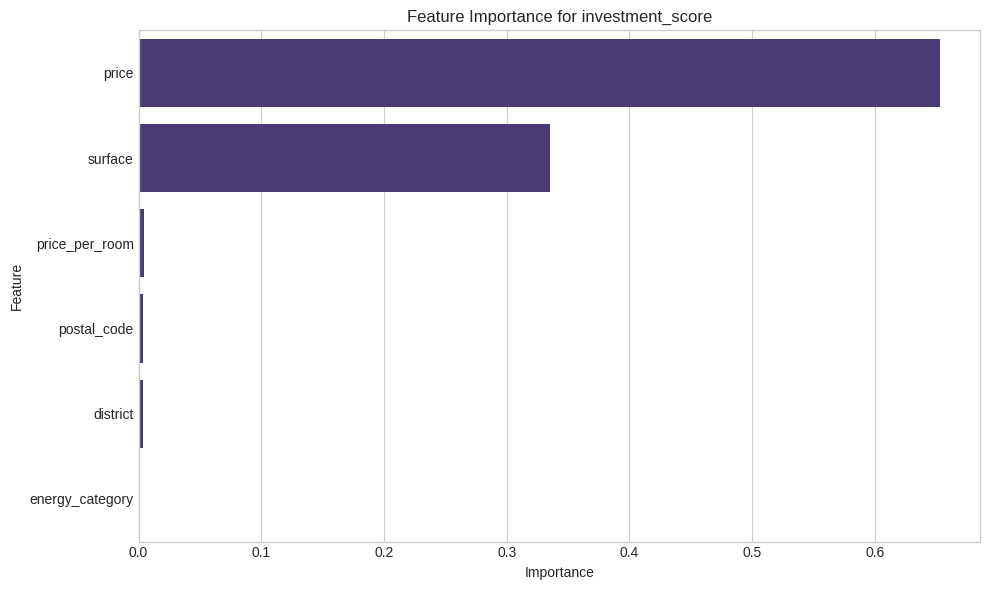


Evaluating model for investment_score...


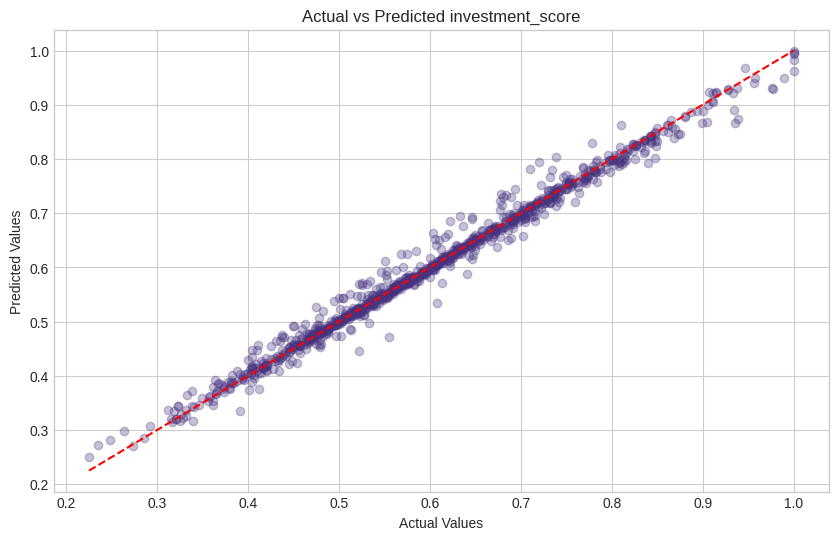

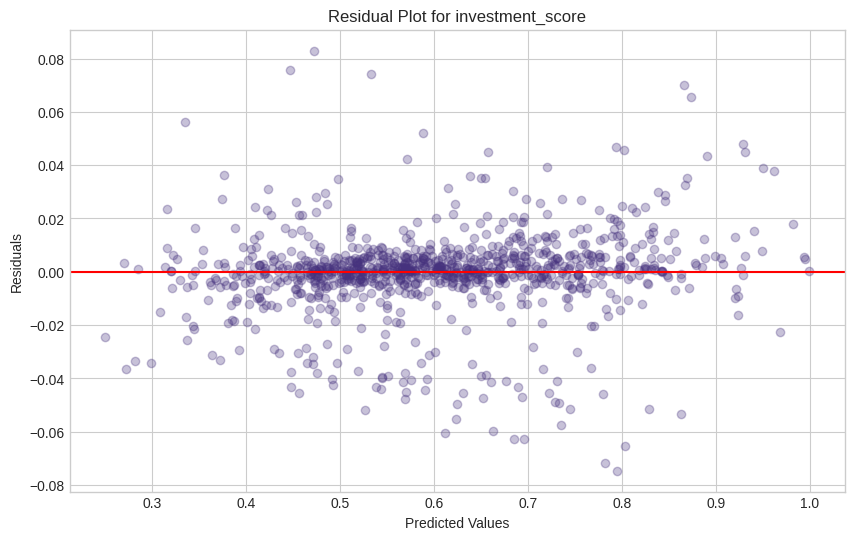


Evaluation Metrics for investment_score:
MAE: 0.01
RMSE: 0.02
R²: 0.9868
MAPE: 0.98%

Model Performance Comparison:
                         MAE  RMSE   R2  MAPE
long_term_rental_yield  0.07  0.28 0.97  1.30
short_term_rental_yield 0.08  0.35 0.99  1.26
investment_score        0.01  0.02 0.99  0.98


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, X_test, y_test, target_name):
    """Evaluate model performance and return metrics"""
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred),
        'MAPE': np.mean(np.abs((y_test - y_pred) / np.maximum(np.abs(y_test), 1))) * 100
    }

    # Create scatter plot of actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'Actual vs Predicted {target_name}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

    # Create residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.3)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title(f'Residual Plot for {target_name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    return metrics

# Modified feature importance function that returns the model
def analyze_feature_importance(X, y, feature_names, target_name):
    print(f"Analyzing feature importance for {target_name}...")

    # Copy data to avoid modifying original
    X = X.copy()

    # Filter out features that are entirely missing
    valid_features = [f for f in feature_names if X[f].notna().any()]
    X = X[valid_features]

    # Identify feature types
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    boolean_features = X.select_dtypes(include=['bool']).columns.tolist()

    print(f"Features: {len(numeric_features)} numeric, {len(categorical_features)} categorical, {len(boolean_features)} boolean")

    # Define preprocessing pipeline
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features),
            ('bool', 'passthrough', boolean_features)
        ])

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    # Fit the model
    model.fit(X, y)
    print("Model training completed")

    # Extract feature importances
    preprocessor = model.named_steps['preprocessor']
    preprocessor.fit(X)

    # Get feature names
    feature_names_out = []

    # Numeric features
    if numeric_features:
        feature_names_out.extend(numeric_features)

    # Categorical features
    if categorical_features:
        ohe = preprocessor.named_transformers_['cat'].named_steps['encoder']
        cat_feature_names = ohe.get_feature_names_out(categorical_features)
        feature_names_out.extend(cat_feature_names)

    # Boolean features
    if boolean_features:
        feature_names_out.extend(boolean_features)

    # Get importances
    importances = model.named_steps['regressor'].feature_importances_

    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names_out,
        'importance': importances
    }).sort_values('importance', ascending=False)

    # Group by original feature names
    grouped_importances = {}
    for feature in feature_names:
        if feature in numeric_features or feature in boolean_features:
            # Handle features that might have been filtered
            if feature in importance_df['feature'].values:
                grouped_importances[feature] = importance_df[importance_df['feature'] == feature]['importance'].sum()
        elif feature in categorical_features:
            # Handle one-hot encoded features
            pattern = f"{feature}_"
            cat_importances = importance_df[importance_df['feature'].str.startswith(pattern)]
            if not cat_importances.empty:
                grouped_importances[feature] = cat_importances['importance'].sum()

    grouped_df = pd.DataFrame({
        'feature': list(grouped_importances.keys()),
        'importance': list(grouped_importances.values())
    }).sort_values('importance', ascending=False)

    # Plot results
    plt.figure(figsize=(10, 6))
    top_features = grouped_df.head(15)
    sns.barplot(x='importance', y='feature', data=top_features)
    plt.title(f"Feature Importance for {target_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    return model, grouped_df

# Main execution
# Handle missing values
X_train['price_per_sqm'] = X_train['price_per_sqm'].fillna(X_train['price_per_sqm'].median())

# Dictionary to store models and results
trained_models = {}
feature_importances = {}
evaluation_metrics = {}

for target, (X_train_split, X_test_split, y_train_split, y_test_split) in train_test_splits.items():
    print(f"\n{'='*50}")
    print(f"Processing target: {target}")
    print(f"{'='*50}")

    # Train model and get feature importance
    model, importance_df = analyze_feature_importance(
        X_train_split,
        y_train_split,
        X_train_split.columns.tolist(),
        target
    )

    # Store model and feature importance
    trained_models[target] = model
    feature_importances[target] = importance_df

    # Evaluate model
    print(f"\nEvaluating model for {target}...")
    metrics = evaluate_model(model, X_test_split, y_test_split, target)
    evaluation_metrics[target] = metrics

    # Print evaluation results
    print(f"\nEvaluation Metrics for {target}:")
    print(f"MAE: {metrics['MAE']:.2f}")
    print(f"RMSE: {metrics['RMSE']:.2f}")
    print(f"R²: {metrics['R2']:.4f}")
    print(f"MAPE: {metrics['MAPE']:.2f}%")

# Create metrics comparison table
metrics_df = pd.DataFrame(evaluation_metrics).T
print("\nModel Performance Comparison:")
print(metrics_df)

In [ ]:
print(X_train.isna().sum())
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

price                 0
surface               0
price_per_sqm      3856
price_per_room        0
postal_code           0
district              0
energy_category       0
dtype: int64
X_train shape: (3856, 7)
y_train shape: (3856,)


Analyzing feature importance for long_term_rental_yield...


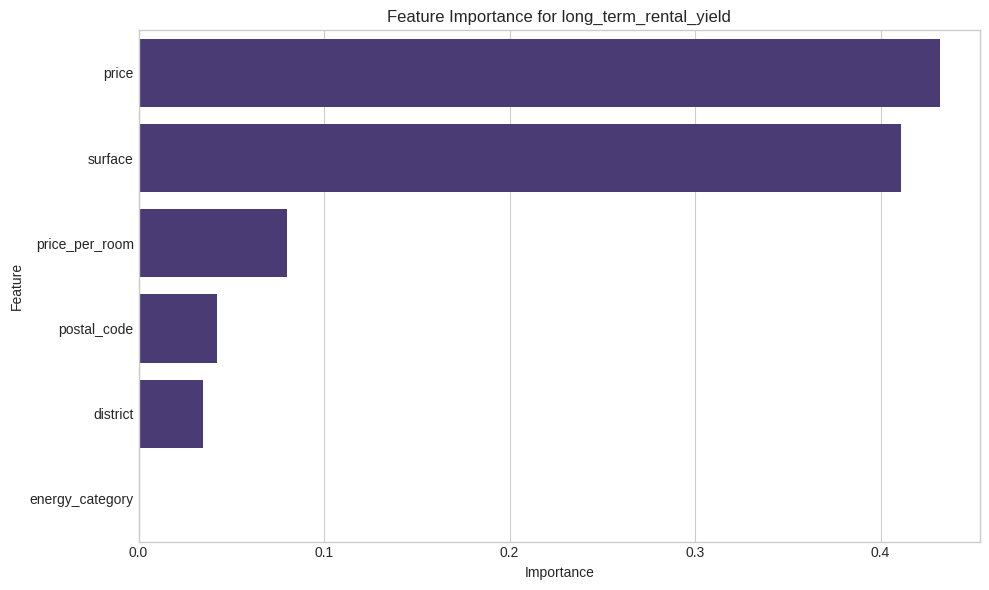

Analyzing feature importance for short_term_rental_yield...


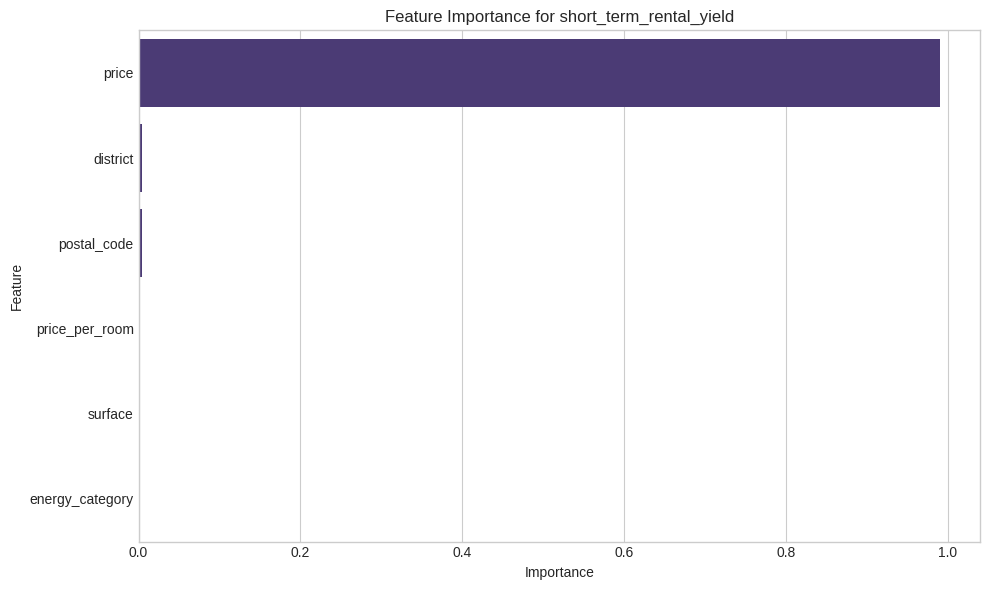

Analyzing feature importance for investment_score...


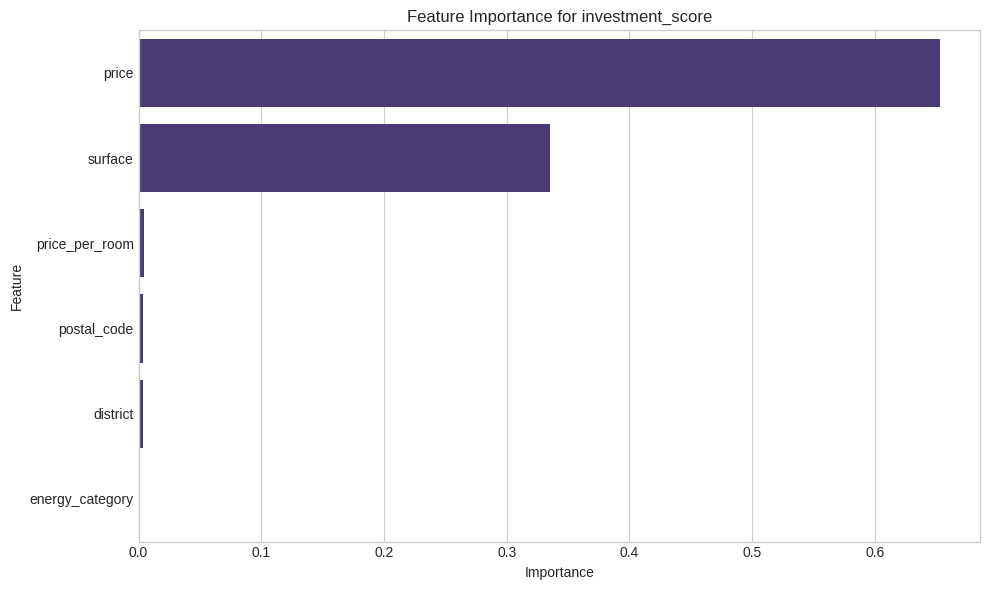

In [ ]:
# Analyze feature importance for each target
feature_importances = {}
for target, (X_train, _, y_train, _) in train_test_splits.items():
    feature_importances[target] = analyze_feature_importance(X_train, y_train, all_features, target)

### 3.6 Feature Engineering and Data Preparation Summary

Let's summarize the feature engineering and data preparation process.

In [ ]:
# Print feature engineering and data preparation summary
print("Feature Engineering and Data Preparation Summary:")
print("\n1. Data Cleaning:")
print(f"   - Removed rows with missing price or surface values")
print(f"   - Removed price and surface area outliers")
print(f"   - Removed price per square meter outliers")

print("\n2. Feature Engineering:")
print(f"   - Created district feature from postal code")
print(f"   - Created price per room feature")
print(f"   - Created property type features (is_apartment, is_house)")
print(f"   - Created property condition features (is_luxury, is_renovated)")
print(f"   - Created amenity features (has_balcony, has_parking, has_elevator, has_garden, has_pool)")
print(f"   - Created energy efficiency feature (energy_category)")
print(f"   - Created price-to-rent ratio feature")
print(f"   - Created investment score feature")

print("\n3. Dataset Aggregation:")
print(f"   - Aggregated {len(datasets)} datasets into a unified dataset")
print(f"   - Removed duplicate rows")
print(f"   - Final aggregated dataset shape: {df_aggregated.shape if df_aggregated is not None else 'N/A'}")

print("\n4. Final Dataset Preparation:")
print(f"   - Selected {len(all_features)} features for model training")
print(f"   - Filled missing values in numeric features with median")
print(f"   - Filled missing values in categorical features with 'Unknown'")
print(f"   - Filled missing values in boolean features with False")
print(f"   - Created train/test splits for each target variable")

print("\n5. Feature Importance Analysis:")
for target, importance_df in feature_importances.items():
    print(f"   - Top 5 features for {target}:")
    for _, row in importance_df.head(5).iterrows():
        print(f"     - {row['feature']}: {row['importance']:.4f}")

Feature Engineering and Data Preparation Summary:

1. Data Cleaning:
   - Removed rows with missing price or surface values
   - Removed price and surface area outliers
   - Removed price per square meter outliers

2. Feature Engineering:
   - Created district feature from postal code
   - Created price per room feature
   - Created property type features (is_apartment, is_house)
   - Created property condition features (is_luxury, is_renovated)
   - Created amenity features (has_balcony, has_parking, has_elevator, has_garden, has_pool)
   - Created energy efficiency feature (energy_category)
   - Created price-to-rent ratio feature
   - Created investment score feature

3. Dataset Aggregation:
   - Aggregated 3 datasets into a unified dataset
   - Removed duplicate rows
   - Final aggregated dataset shape: (4820, 134)

4. Final Dataset Preparation:
   - Selected 7 features for model training
   - Filled missing values in numeric features with median
   - Filled missing values in categ

In [ ]:
# Calculate rental yields for apartments dataset
df_apartments_yields = calculate_rental_yields(df_apartments, df_properties_batch2, df_airbnb_listings)

# Calculate rental yields for properties batch 1 dataset
df_properties_batch1_yields = calculate_rental_yields(df_properties_batch1, df_properties_batch2, df_airbnb_listings)

# Calculate rental yields for properties batch 3 dataset
df_properties_batch3_yields = calculate_rental_yields(df_properties_batch3, df_properties_batch2, df_airbnb_listings)


Visualizing rental yields for Apartments dataset:


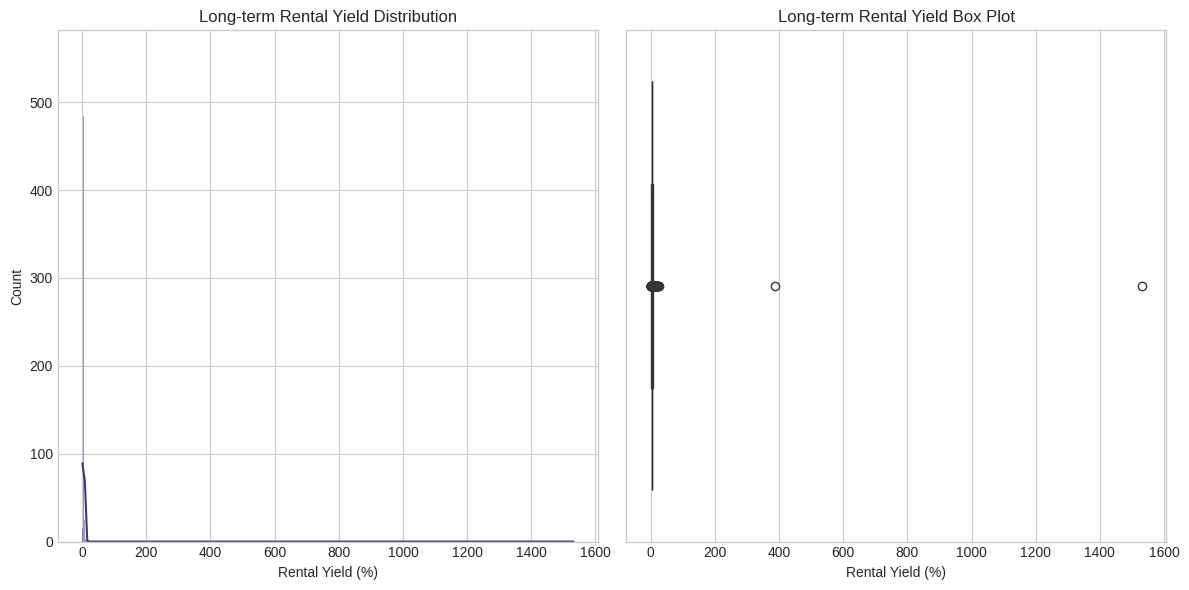

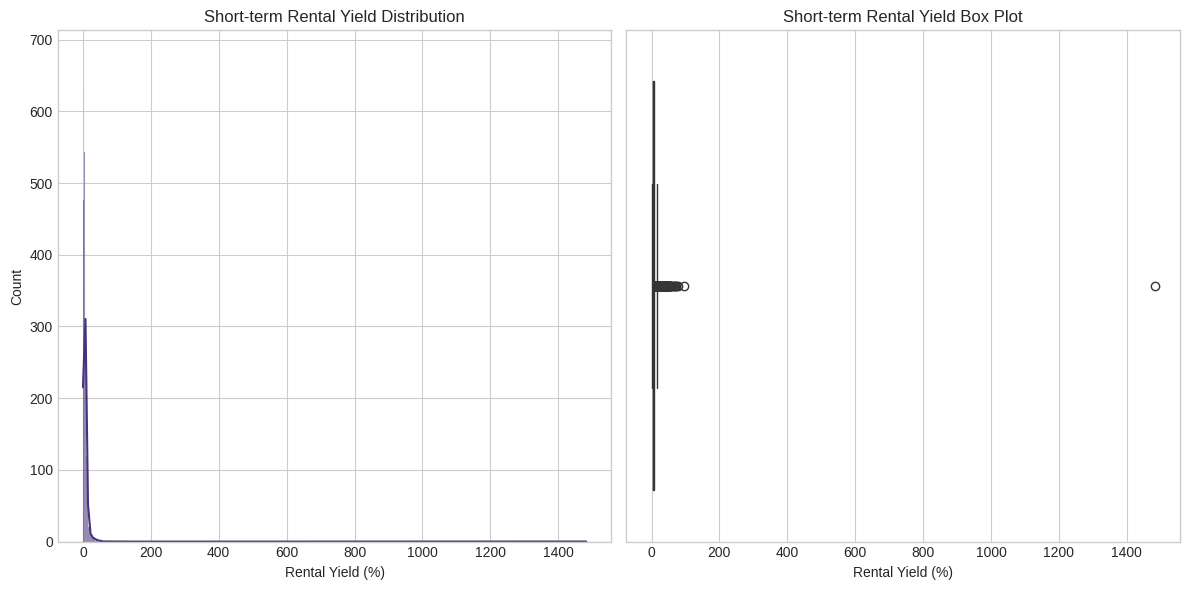

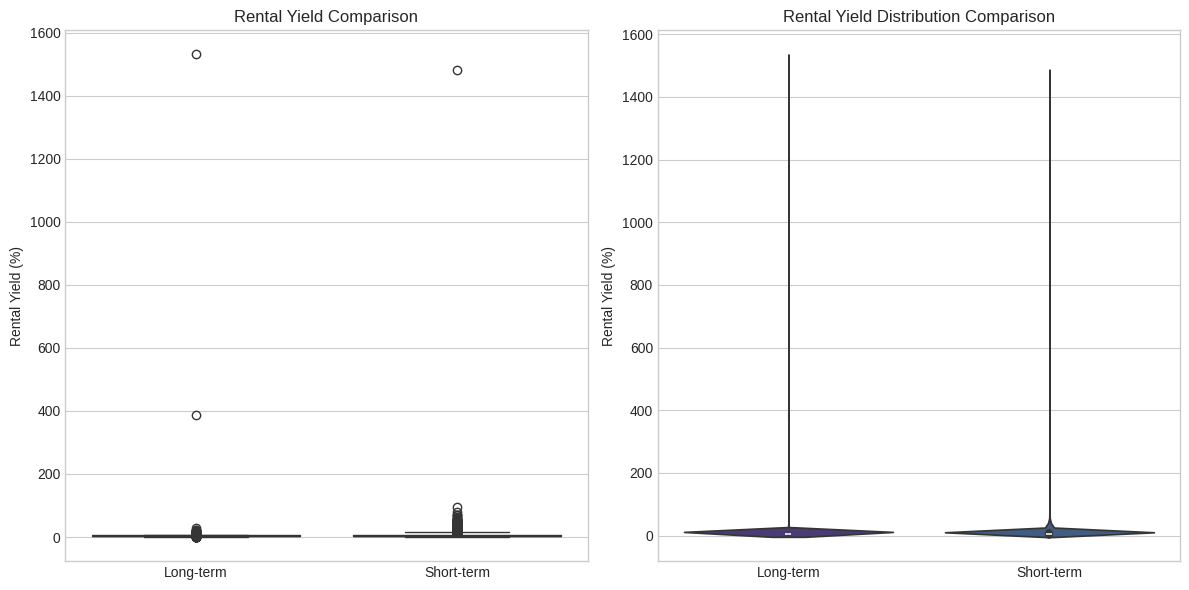

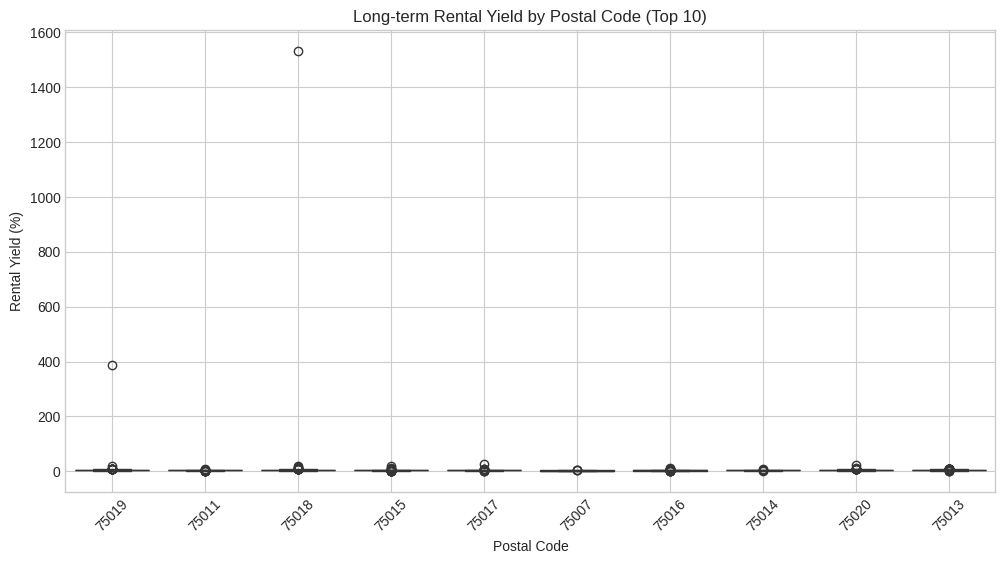

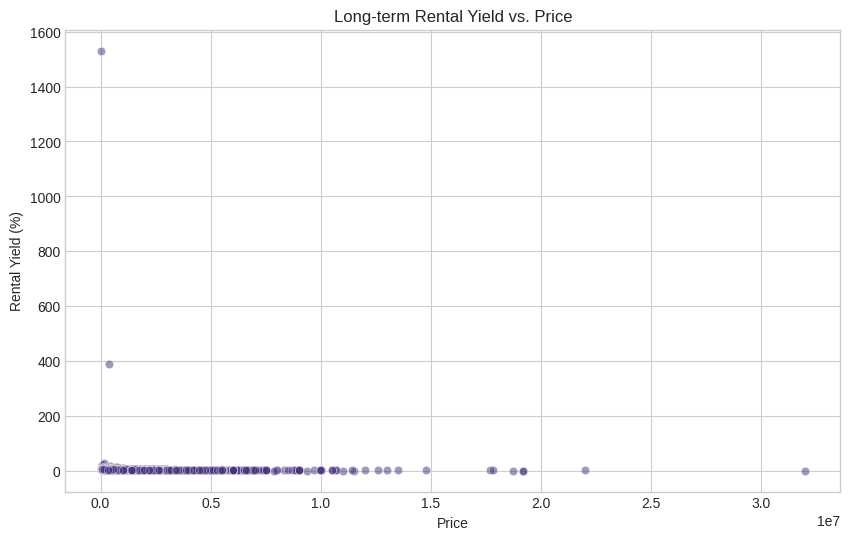

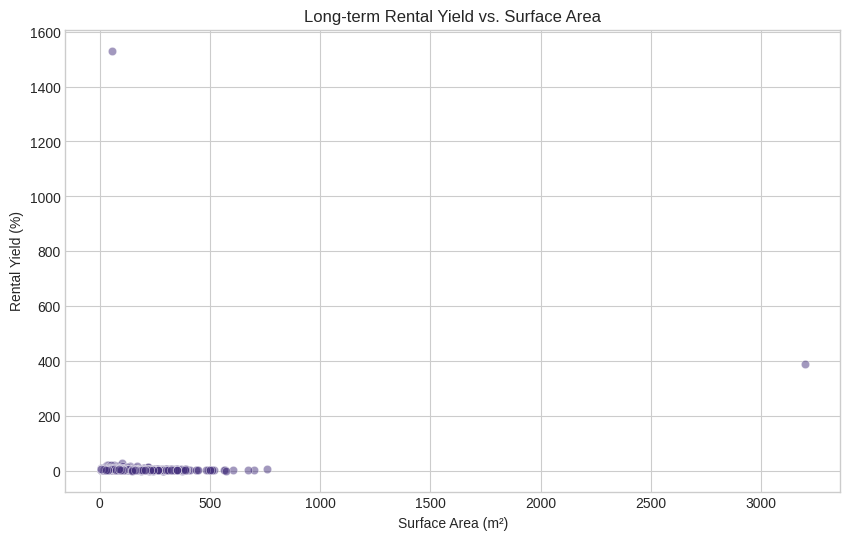


Visualizing rental yields for Properties Batch 1 dataset:


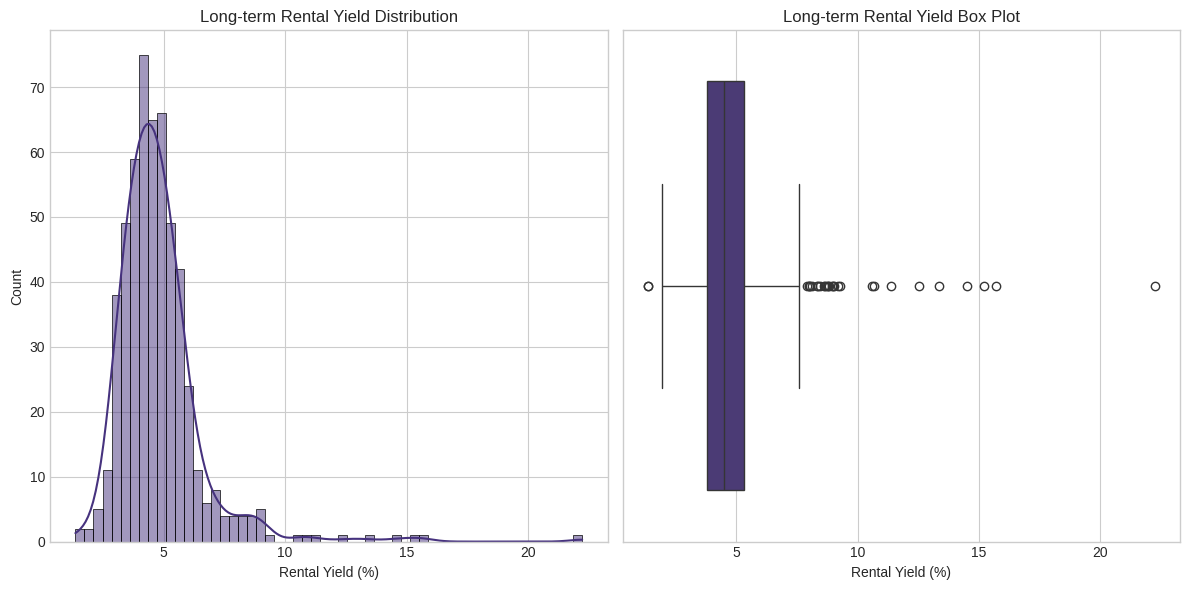

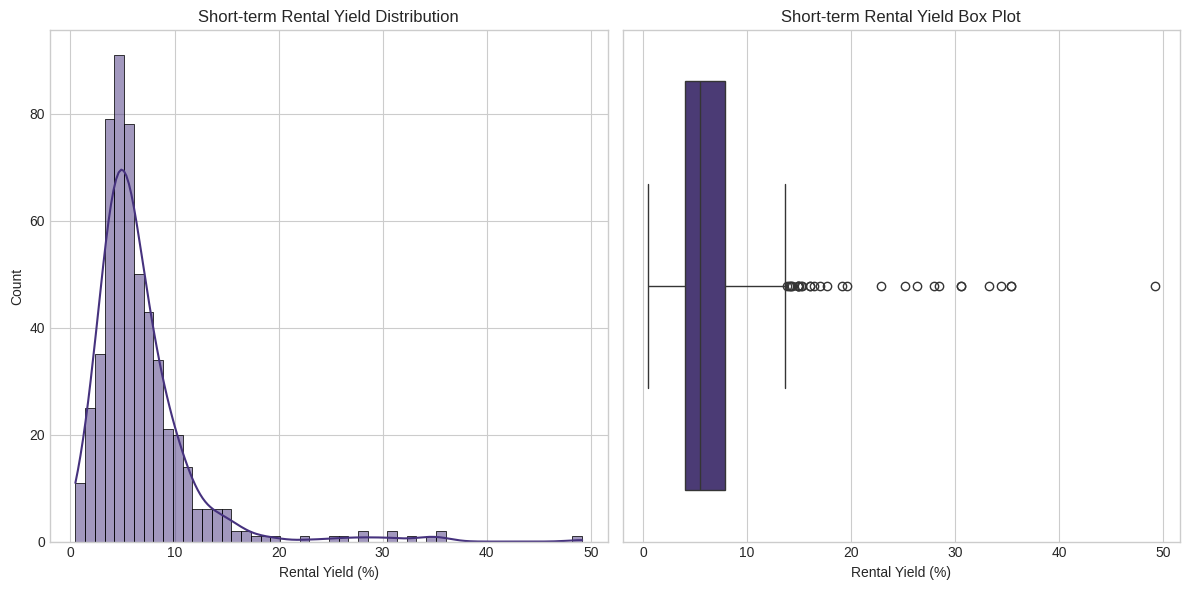

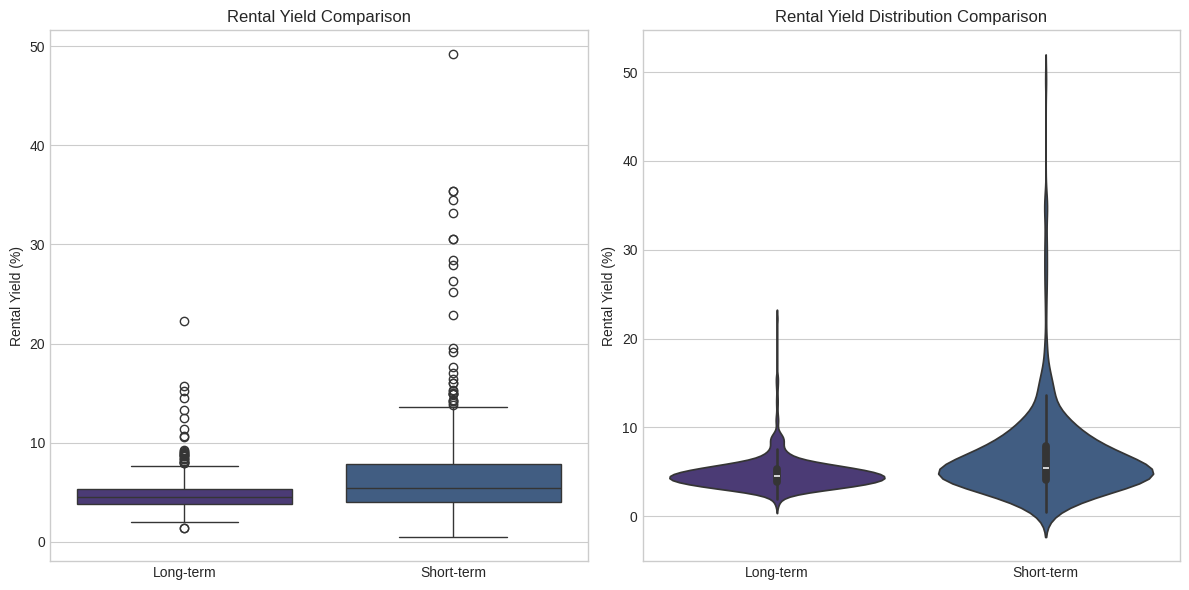

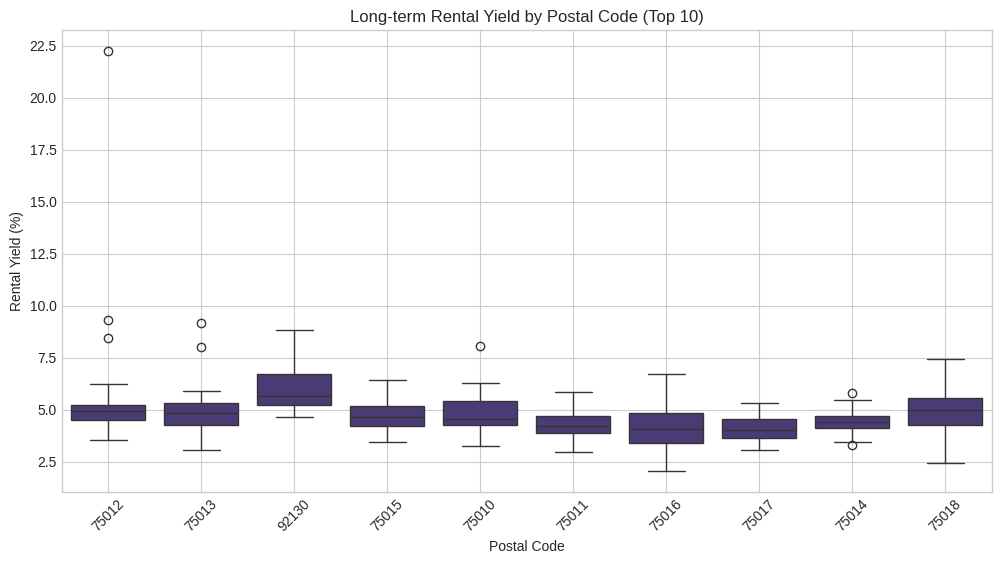

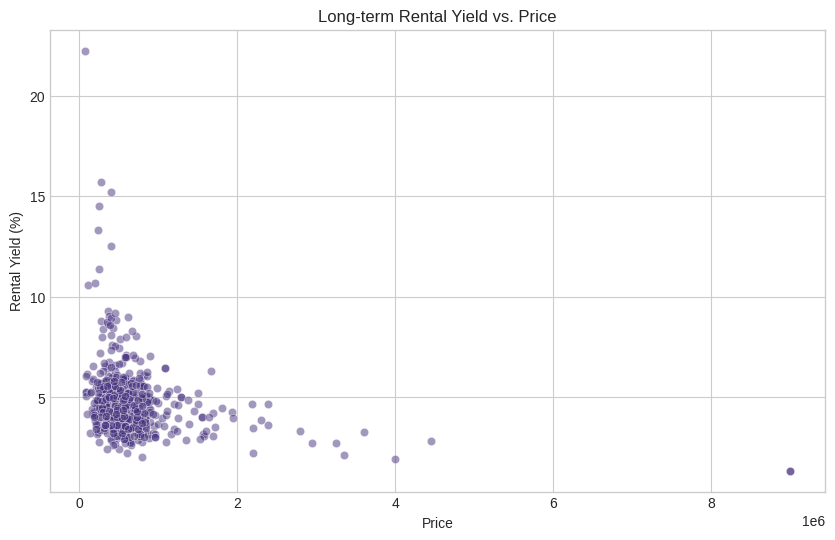

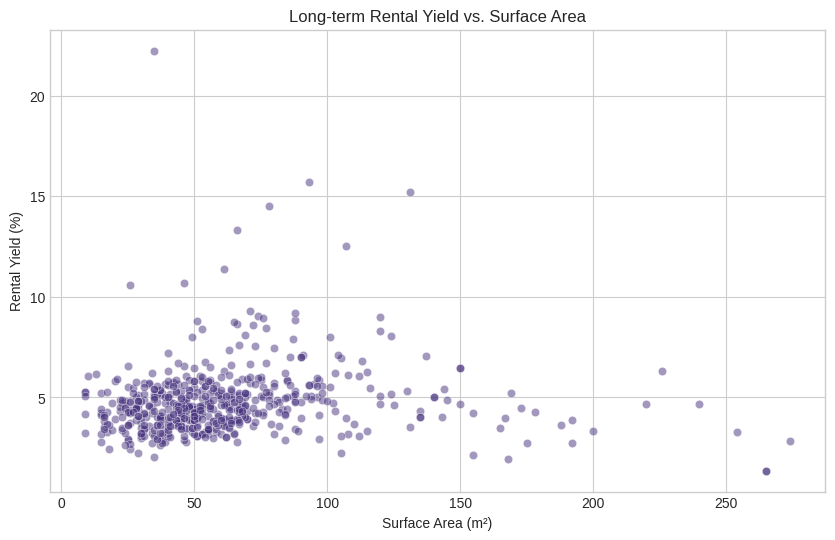


Visualizing rental yields for Properties Batch 3 dataset:


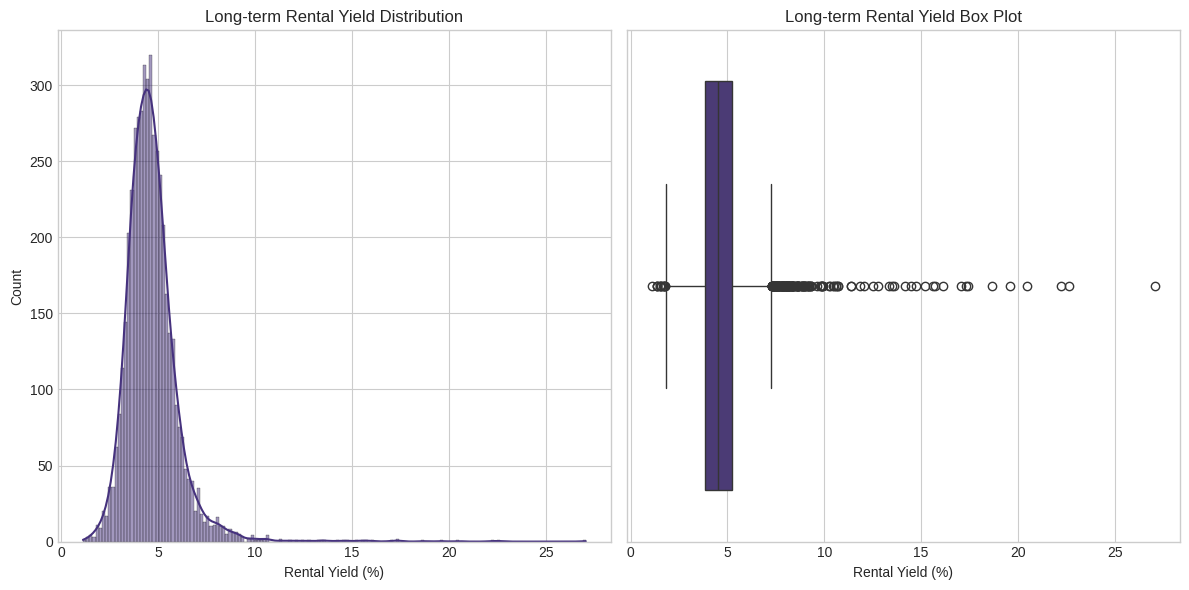

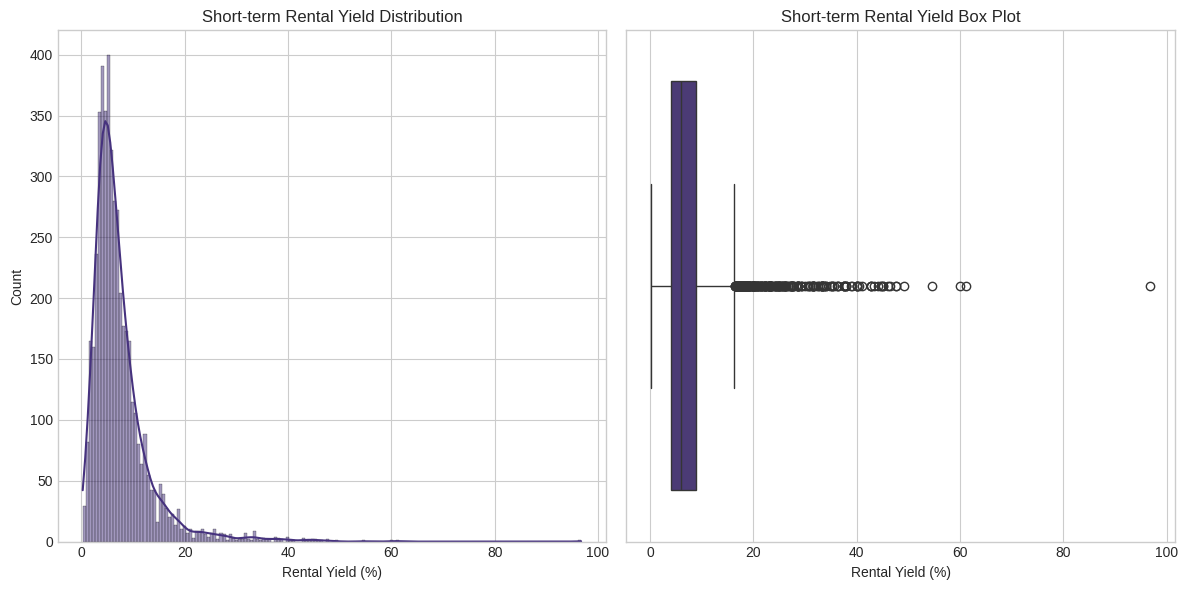

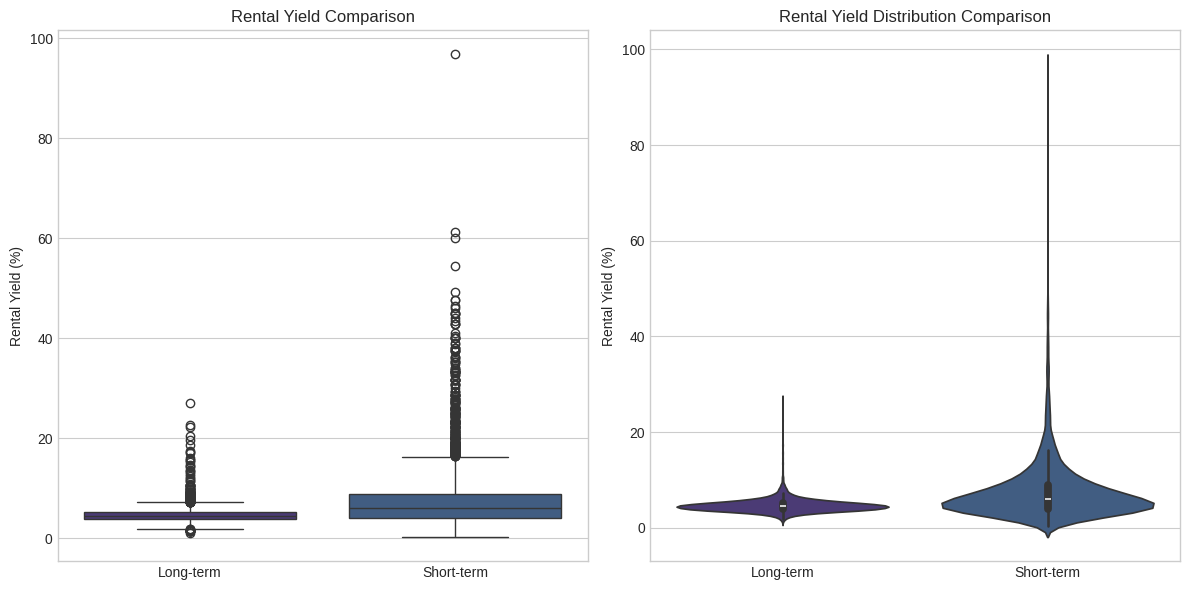

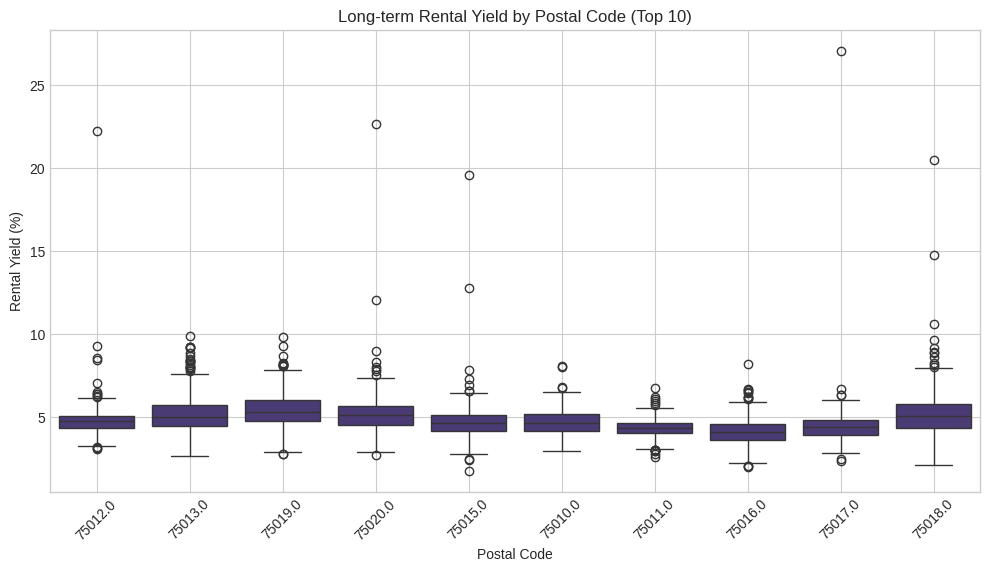

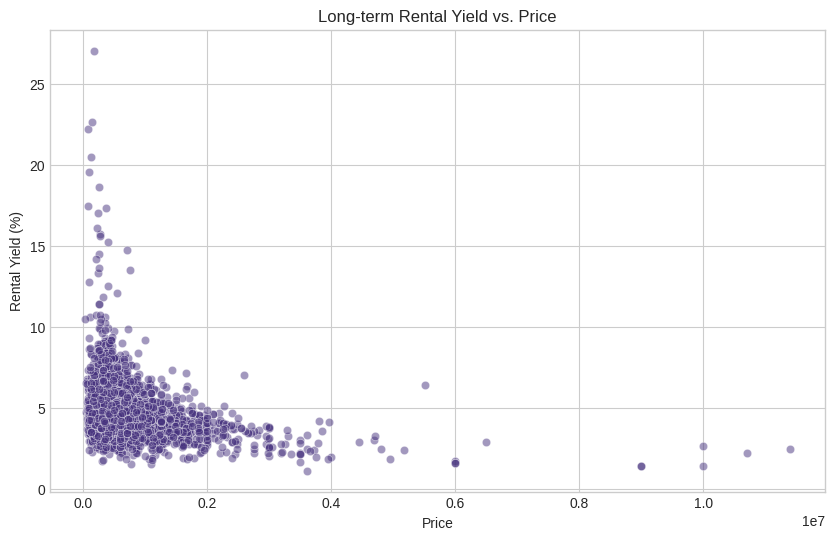

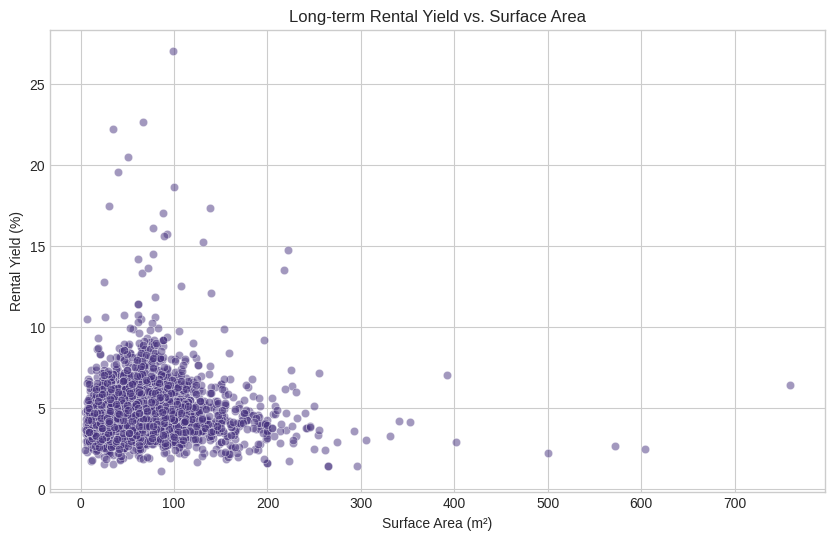

In [ ]:


# Visualize rental yields for apartments dataset
visualize_rental_yields(df_apartments_yields, "Apartments")

# Visualize rental yields for properties batch 1 dataset
visualize_rental_yields(df_properties_batch1_yields, "Properties Batch 1")

# Visualize rental yields for properties batch 3 dataset
visualize_rental_yields(df_properties_batch3_yields, "Properties Batch 3")

In [ ]:
# Clean each dataset
df_apartments_clean = clean_dataset(df_apartments_yields, "Apartments")
df_properties_batch1_clean = clean_dataset(df_properties_batch1_yields, "Properties Batch 1")
df_properties_batch3_clean = clean_dataset(df_properties_batch3_yields, "Properties Batch 3")
# Note: df_properties_batch2_clean was already processed in a previous step
df_airbnb_listings_clean = clean_dataset(df_airbnb_listings, "Airbnb Listings")

Cleaning Apartments dataset...
  26 missing values in surface column
  Removed 26 rows with missing price or surface values
  Removed 208 price outliers
  Removed 190 surface area outliers
  Removed 10173 price per sqm outliers
Cleaning complete. Final shape: (0, 48)
Cleaning Properties Batch 1 dataset...
  1 missing values in surface column
  Removed 1 rows with missing price or surface values
  Removed 12 price outliers
  Removed 8 surface area outliers
Cleaning complete. Final shape: (523, 83)
Cleaning Properties Batch 3 dataset...
  57 missing values in surface column
  Removed 57 rows with missing price or surface values
  Removed 93 price outliers
  Removed 94 surface area outliers
Cleaning complete. Final shape: (4565, 83)
Cleaning Airbnb Listings dataset...
  Removed 742 price outliers
Cleaning complete. Final shape: (73587, 78)


In [ ]:
# Engineer features for each dataset
df_apartments_features = engineer_features(df_apartments_clean, "Apartments")
df_properties_batch1_features = engineer_features(df_properties_batch1_clean, "Properties Batch 1")
df_properties_batch3_features = engineer_features(df_properties_batch3_clean, "Properties Batch 3")

Engineering features for Apartments dataset...
  Created district feature from postal code
  Created price per room feature using number_of_rooms column
  Created property type and condition features from full_description column
  Created amenity features from full_description column
  Created energy category feature from energy_class column
  Created investment score feature
Feature engineering complete. Final shape: (0, 63)
Engineering features for Properties Batch 1 dataset...
  Created district feature from postal code
  Created price per room feature using has_living_room_image column
  Created property type and condition features from seo_title column
  Created amenity features from seo_title column
  Created energy category feature from estimated_energy_bill column
  Created investment score feature
Feature engineering complete. Final shape: (523, 99)
Engineering features for Properties Batch 3 dataset...
  Created district feature from postal code
  Created price per room featu

In [ ]:
# Aggregate datasets
datasets = [df_apartments_features, df_properties_batch1_features, df_properties_batch3_features]
dataset_names = ["Apartments", "Properties Batch 1", "Properties Batch 3"]
df_aggregated = aggregate_datasets(datasets, dataset_names)

Aggregating datasets...
Found 29 common columns across datasets: {'long_term_rental_yield', 'is_house', 'has_elevator', 'surface', 'image_urls', 'is_renovated', 'has_garden', 'is_apartment', 'is_luxury', 'price_per_room', 'has_brokerage_fee', 'postal_code', 'energy_score', 'has_pool', 'normalized_long_term_yield', 'has_parking', 'investment_score', 'short_term_rental_yield', 'energy_category', 'is_exclusive', 'estimated_monthly_rent', 'estimated_airbnb_income', 'price', 'median_nightly_rate', 'brand', 'has3_d_visit', 'district', 'has_balcony', 'normalized_short_term_yield'}
Removed 268 duplicate rows
Aggregation complete. Final shape: (4820, 134)


In [ ]:
# Examine the aggregated dataset
if df_aggregated is not None:
    print("Aggregated Dataset Summary:")
    print(f"Shape: {df_aggregated.shape}")
    print("\nColumns:")
    print(df_aggregated.columns.tolist())
    print("\nMissing values:")
    missing = df_aggregated.isnull().sum()
    print(missing[missing > 0].sort_values(ascending=False))
    print("\nDataset sources:")
    print(df_aggregated['dataset_source'].value_counts())

    # Check for key features
    key_features = ['price', 'surface', 'postal_code', 'price_per_sqm', 'long_term_rental_yield', 'investment_score']
    print("\nKey features availability:")
    for feature in key_features:
        if feature in df_aggregated.columns:
            print(f"  {feature}: {df_aggregated[feature].notna().sum()} non-null values")
        else:
            print(f"  {feature}: Not available")

Aggregated Dataset Summary:
Shape: (4820, 134)

Columns:
['id', 'url', 'has3_d_visit', 'is_exclusive', 'has_brokerage_fee', 'type', 'brand', 'portal', 'status', 'image_urls', 'virtual_tours_available', 'floorplans_available', 'city', 'country', 'district', 'zip_code', 'update_date', 'creation_date', 'provider_rating', 'provider_reviews', 'provider_address', 'provider_website', 'provider_phone_numbers', 'agency_name', 'agency_logo_url', 'agency_legal_information', 'price', 'number_of_rooms', 'surface', 'number_of_bedrooms', 'property_type', 'distribution_type', 'formatted_price', 'price_per_sqm', 'number_of_rooms_hardfact', 'number_of_bedrooms_hardfact', 'living_space_sqm_hardfact', 'floor_info', 'energy_class', 'headline', 'full_description', 'year_of_construction', 'postal_code', 'estimated_monthly_rent', 'median_nightly_rate', 'estimated_airbnb_income', 'long_term_rental_yield', 'short_term_rental_yield', 'price_per_room', 'is_apartment', 'is_house', 'is_luxury', 'is_renovated', 'has

In [ ]:
# Prepare final dataset
target_columns = ['long_term_rental_yield', 'short_term_rental_yield', 'investment_score']
X, y_dict, all_features = prepare_final_dataset(df_aggregated, target_columns)

Preparing final dataset...
Removed 0 rows with missing long_term_rental_yield values
Removed 0 rows with missing short_term_rental_yield values
Removed 0 rows with missing investment_score values
Selected 7 features: ['price', 'surface', 'price_per_sqm', 'price_per_room', 'postal_code', 'district', 'energy_category']
Filled missing values in price_per_sqm with median
Filled missing values in price_per_room with median
Filled missing values in energy_category with 'Unknown'
Final dataset preparation complete. Shape: (4820, 7)


In [ ]:
# Create train/test splits for each target
train_test_splits = {}
for target, y in y_dict.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train_test_splits[target] = (X_train, X_test, y_train, y_test)
    print(f"Created train/test split for {target}: Train shape = {X_train.shape}, Test shape = {X_test.shape}")

Created train/test split for long_term_rental_yield: Train shape = (3856, 7), Test shape = (964, 7)
Created train/test split for short_term_rental_yield: Train shape = (3856, 7), Test shape = (964, 7)
Created train/test split for investment_score: Train shape = (3856, 7), Test shape = (964, 7)


Analyzing feature importance for long_term_rental_yield...


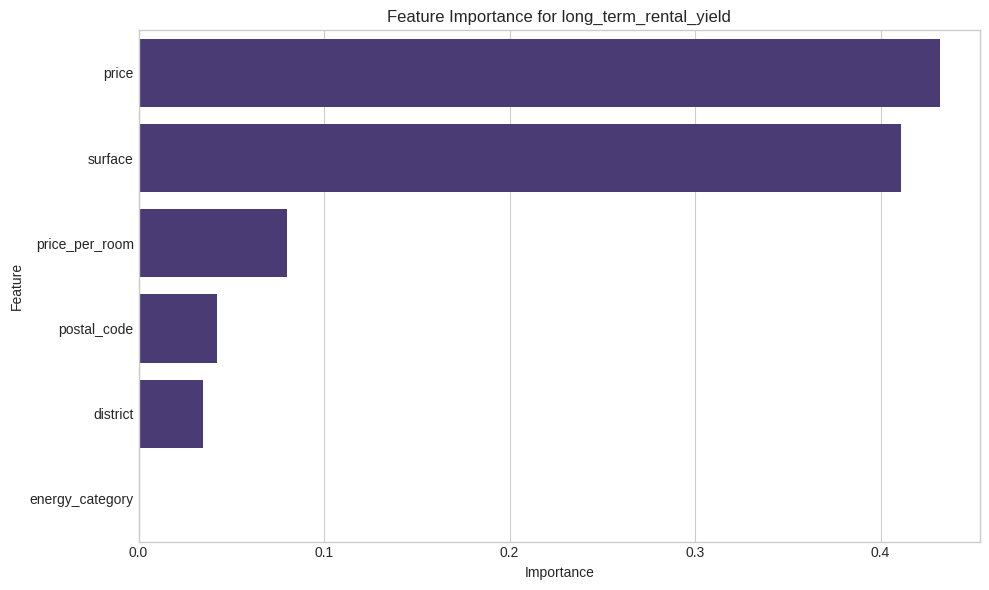

Analyzing feature importance for short_term_rental_yield...


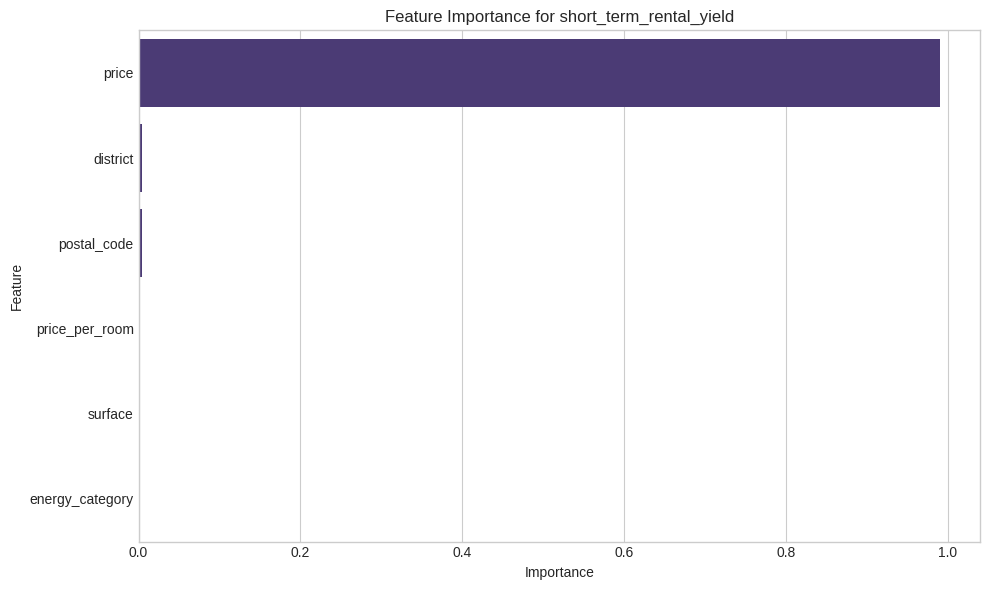

Analyzing feature importance for investment_score...


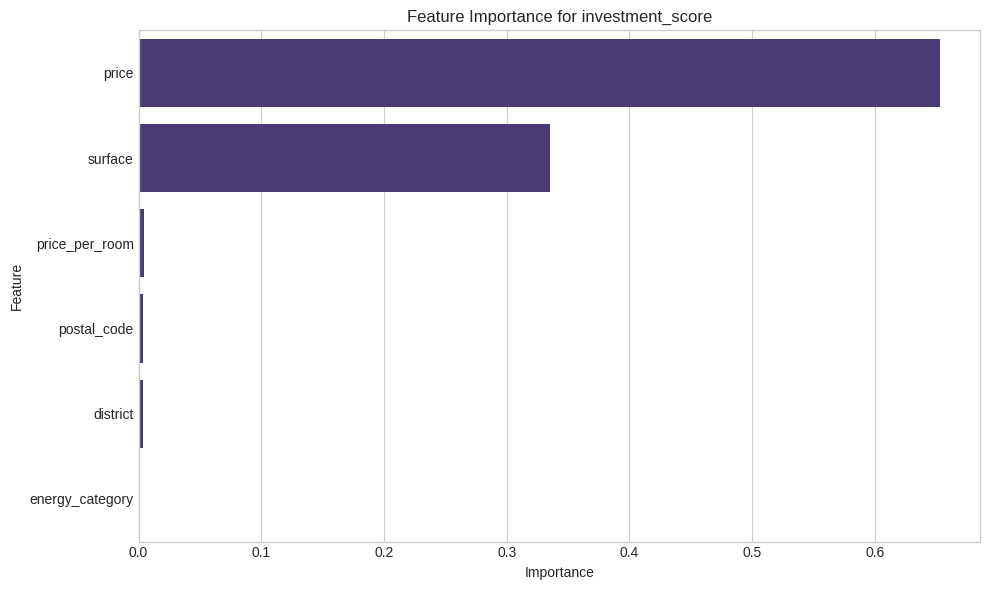

In [ ]:
# Analyze feature importance for each target
feature_importances = {}
for target, (X_train, _, y_train, _) in train_test_splits.items():
    feature_importances[target] = analyze_feature_importance(X_train, y_train, all_features, target)

In [ ]:
# Print feature engineering and data preparation summary
print("Feature Engineering and Data Preparation Summary:")
print("\n1. Data Cleaning:")
print(f"   - Removed rows with missing price or surface values")
print(f"   - Removed price and surface area outliers")
print(f"   - Removed price per square meter outliers")

print("\n2. Feature Engineering:")
print(f"   - Created district feature from postal code")
print(f"   - Created price per room feature")
print(f"   - Created property type features (is_apartment, is_house)")
print(f"   - Created property condition features (is_luxury, is_renovated)")
print(f"   - Created amenity features (has_balcony, has_parking, has_elevator, has_garden, has_pool)")
print(f"   - Created energy efficiency feature (energy_category)")
print(f"   - Created price-to-rent ratio feature")
print(f"   - Created investment score feature")

print("\n3. Dataset Aggregation:")
print(f"   - Aggregated {len(datasets)} datasets into a unified dataset")
print(f"   - Removed duplicate rows")
print(f"   - Final aggregated dataset shape: {df_aggregated.shape if df_aggregated is not None else 'N/A'}")

print("\n4. Final Dataset Preparation:")
print(f"   - Selected {len(all_features)} features for model training")
print(f"   - Filled missing values in numeric features with median")
print(f"   - Filled missing values in categorical features with 'Unknown'")
print(f"   - Filled missing values in boolean features with False")
print(f"   - Created train/test splits for each target variable")

print("\n5. Feature Importance Analysis:")
for target, importance_df in feature_importances.items():
    print(f"   - Top 5 features for {target}:")
    for _, row in importance_df.head(5).iterrows():
        print(f"     - {row['feature']}: {row['importance']:.4f}")

Feature Engineering and Data Preparation Summary:

1. Data Cleaning:
   - Removed rows with missing price or surface values
   - Removed price and surface area outliers
   - Removed price per square meter outliers

2. Feature Engineering:
   - Created district feature from postal code
   - Created price per room feature
   - Created property type features (is_apartment, is_house)
   - Created property condition features (is_luxury, is_renovated)
   - Created amenity features (has_balcony, has_parking, has_elevator, has_garden, has_pool)
   - Created energy efficiency feature (energy_category)
   - Created price-to-rent ratio feature
   - Created investment score feature

3. Dataset Aggregation:
   - Aggregated 3 datasets into a unified dataset
   - Removed duplicate rows
   - Final aggregated dataset shape: (4820, 134)

4. Final Dataset Preparation:
   - Selected 7 features for model training
   - Filled missing values in numeric features with median
   - Filled missing values in categ

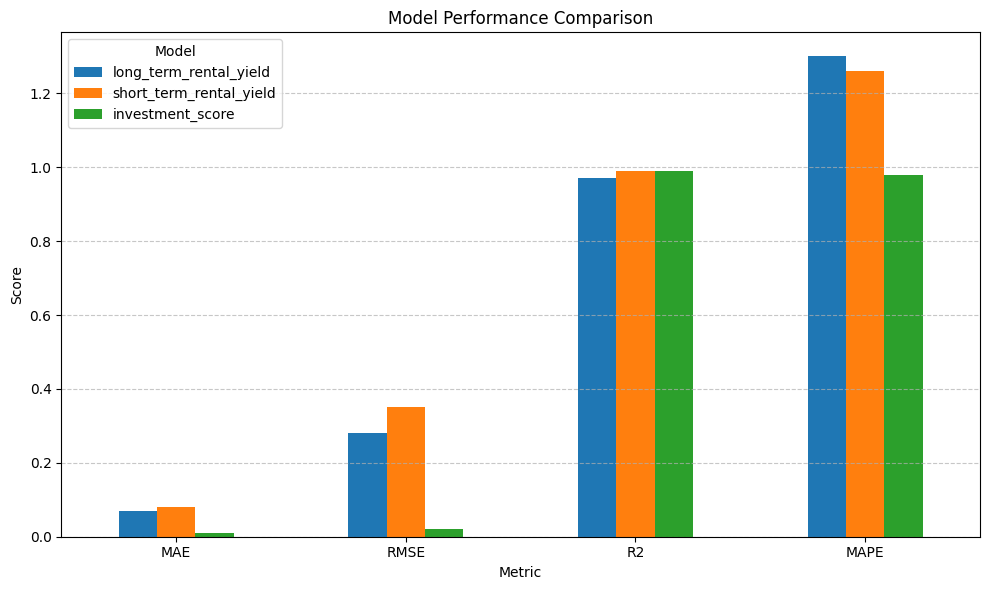

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the data
data = {
    'Model': ['long_term_rental_yield', 'short_term_rental_yield', 'investment_score'],
    'MAE': [0.07, 0.08, 0.01],
    'RMSE': [0.28, 0.35, 0.02],
    'R2': [0.97, 0.99, 0.99],
    'MAPE': [1.30, 1.26, 0.98]
}

# Create a DataFrame
df = pd.DataFrame(data)
df.set_index('Model', inplace=True)

# Transpose to get metrics as rows for grouped bar chart
df_transposed = df.T

# Plotting
df_transposed.plot(kind='bar', figsize=(10, 6), rot=0)

plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


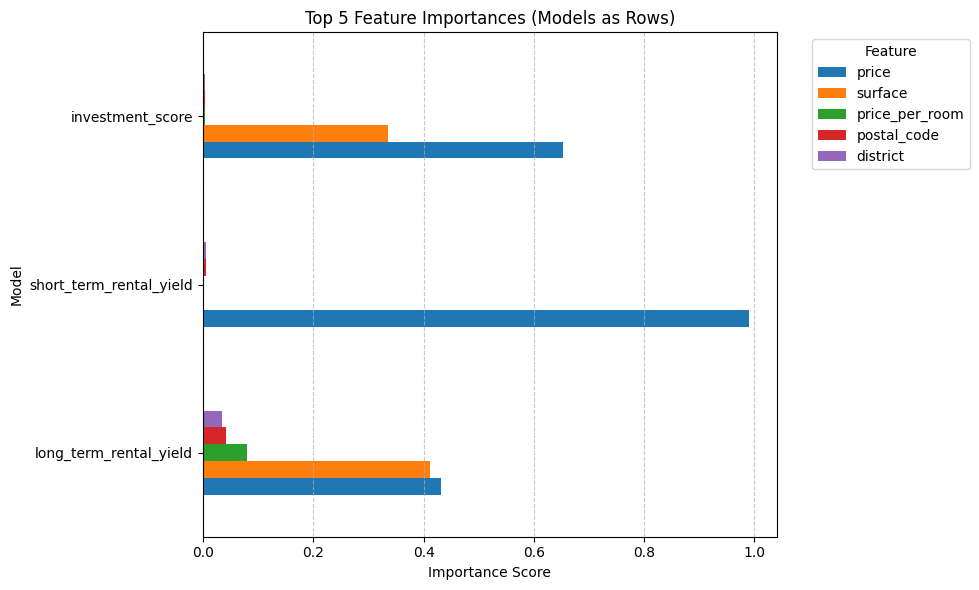

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the feature importances with models as rows
data = {
    'price': [0.4320, 0.9905, 0.6530],
    'surface': [0.4110, 0.0001, 0.3357],
    'price_per_room': [0.0799, 0.0001, 0.0042],
    'postal_code': [0.0422, 0.0046, 0.0036],
    'district': [0.0350, 0.0047, 0.0036]
}

# Model names
models = ['long_term_rental_yield', 'short_term_rental_yield', 'investment_score']

# Create DataFrame
df = pd.DataFrame(data, index=models)

# Plot horizontal bar chart
df.plot(kind='barh', figsize=(10, 6))

plt.title('Top 5 Feature Importances (Models as Rows)')
plt.xlabel('Importance Score')
plt.ylabel('Model')
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Real Estate Rental Yield Prediction Analysis

## Project Overview

This project aims to develop a data-driven tool to evaluate real estate listings in Paris and predict potential rental yields (both long-term and short-term) to identify investment opportunities.

## Data Sources

The analysis utilizes the following datasets:

*   **AD08FR31096_seloger_apartments_flattened.csv**: Apartments for sale in Paris.
*   **AD08FR31096_seloger_properties_flattenedbatch1.csv**: Flat data with detailed property information.
*   **AD08FR31096_seloger_properties_flattenedbatch2.csv**: Properties for rent with detailed information.
*   **AD08FR31096_seloger_properties_flattenedbatch3.csv**: Properties for sale with detailed information.
*   **InsideAirbnb Paris Data**: Short-term rental data for Paris from InsideAirbnb.

## Approach

The project follows these steps:

1.  **Data Loading and Exploration**: Load and understand the structure and content of the datasets.
2.  **Data Cleaning and Preprocessing**: Handle missing values, outliers, and inconsistencies.
3.  **Feature Engineering**: Create new features relevant to rental yield prediction.
4.  **Rental Yield Calculation**: Compute long-term and short-term rental yields.
5.  **Dataset Aggregation**: Combine the processed datasets.
6.  **Model Training and Optimization**: Train machine learning models to predict rental yields and investment scores.
7.  **Model Evaluation**: Assess the performance of the trained models.
8.  **Investment Opportunity Identification**: Identify potential investment opportunities based on the model predictions.

## Data Analysis and Visualization

Initial data exploration revealed key characteristics of the datasets.

### Price Distribution

*(Insert Price Distribution Visualizations Here)*

### Surface Area Distribution

*(Insert Surface Area Distribution Visualizations Here)*

### Price per Square Meter Distribution

*(Insert Price per Square Meter Distribution Visualizations Here)*

### Price vs. Surface Area

*(Insert Price vs. Surface Area Visualization Here)*

### Price by Postal Code

*(Insert Price by Postal Code Visualization Here)*

### Price per Square Meter by Postal Code

*(Insert Price per Square Meter by Postal Code Visualization Here)*

### Correlation Matrix

*(Insert Correlation Matrix Visualization Here)*

### Rental Yields

Rental yields were calculated for both long-term and short-term rentals.

#### Rental Yield Distribution

*(Insert Rental Yield Distribution Visualizations Here)*

#### Rental Yield Comparison

*(Insert Rental Yield Comparison Visualization Here)*

#### Rental Yield by Postal Code

*(Insert Rental Yield by Postal Code Visualization Here)*

#### Rental Yield vs. Price

*(Insert Rental Yield vs. Price Visualization Here)*

#### Rental Yield vs. Surface Area

*(Insert Rental Yield vs. Surface Area Visualization Here)*

## Feature Engineering and Data Preparation Summary

*(Summarize the key steps from the "Feature Engineering and Data Preparation Summary" output here)*

## Model Training and Evaluation

Machine learning models were trained to predict long-term rental yield, short-term rental yield, and investment score.

### Feature Importance

The analysis of feature importance revealed the most influential factors for each target variable.

*(Insert Feature Importance Visualizations Here)*

### Model Performance

The models were evaluated using standard regression metrics.

*(Insert Model Performance Comparison Visualization Here)*

*(Optionally, add a summary of the key metrics here)*

## Conclusion and Future Work

*(Add your conclusions and potential next steps here, e.g., refining features, trying different models, identifying specific investment opportunities)*

# Real Estate Rental Yield Prediction Analysis

## Project Overview

This project aims to develop a data-driven tool to evaluate real estate listings in Paris and predict potential rental yields (both long-term and short-term) to identify investment opportunities.

## Data Sources

The analysis utilizes the following datasets:

*   **AD08FR31096_seloger_apartments_flattened.csv**: Apartments for sale in Paris.
*   **AD08FR31096_seloger_properties_flattenedbatch1.csv**: Flat data with detailed property information.
*   **AD08FR31096_seloger_properties_flattenedbatch2.csv**: Properties for rent with detailed information.
*   **AD08FR31096_seloger_properties_flattenedbatch3.csv**: Properties for sale with detailed information.
*   **InsideAirbnb Paris Data**: Short-term rental data for Paris from InsideAirbnb.

## Approach

The project follows these steps:

1.  **Data Loading and Exploration**: Load and understand the structure and content of the datasets.
2.  **Data Cleaning and Preprocessing**: Handle missing values, outliers, and inconsistencies.
3.  **Feature Engineering**: Create new features relevant to rental yield prediction.
4.  **Rental Yield Calculation**: Compute long-term and short-term rental yields.
5.  **Dataset Aggregation**: Combine the processed datasets.
6.  **Model Training and Optimization**: Train machine learning models to predict rental yields and investment scores.
7.  **Model Evaluation**: Assess the performance of the trained models.
8.  **Investment Opportunity Identification**: Identify potential investment opportunities based on the model predictions.

## Data Analysis and Visualization

Initial data exploration revealed key characteristics of the datasets.

### Price Distribution

![Price Distribution](https://colab.research.google.com/outputframe/show-image?outputId=e61c0106-3d58-4b2c-c229-55e2c5f82527)

### Surface Area Distribution

![Surface Area Distribution](https://colab.research.google.com/outputframe/show-image?outputId=33207e43-009b-4758-9338-16b5834b6352)

### Price per Square Meter Distribution

![Price per Square Meter Distribution](https://colab.research.google.com/outputframe/show-image?outputId=4589c41c-f0e9-4947-b40b-eb715b046445)

### Price vs. Surface Area

![Price vs. Surface Area](https://colab.research.google.com/outputframe/show-image?outputId=6a710b81-215b-45d5-8f14-6f05c5a3d68c)

### Price by Postal Code

![Price by Postal Code](https://colab.research.google.com/outputframe/show-image?outputId=06d8b2ca-2e89-4a14-9eb7-e101e683c78d)

### Price per Square Meter by Postal Code

![Price per Square Meter by Postal Code](https://colab.research.google.com/outputframe/show-image?outputId=99807152-a482-4d19-9d67-a4917d63407a)

### Correlation Matrix

![Correlation Matrix](https://colab.research.google.com/outputframe/show-image?outputId=c8136876-f998-4030-97a7-4312a503c517)

### Rental Yields

Rental yields were calculated for both long-term and short-term rentals.

#### Rental Yield Distribution

![Long-term Rental Yield Distribution](https://colab.research.google.com/outputframe/show-image?outputId=7704460a-63c4-4b1c-a252-074186969e27)
![Short-term Rental Yield Distribution](https://colab.research.google.com/outputframe/show-image?outputId=032e8884-6737-4d69-874b-d3040237f435)

#### Rental Yield Comparison

![Rental Yield Comparison](https://colab.research.google.com/outputframe/show-image?outputId=a3811d31-b558-4366-9772-3f9528719b3a)

#### Rental Yield by Postal Code

![Long-term Rental Yield by Postal Code](https://colab.research.google.com/outputframe/show-image?outputId=c16555c5-b0b1-4f69-9e71-c6ff80767509)

#### Rental Yield vs. Price

![Long-term Rental Yield vs. Price](https://colab.research.google.com/outputframe/show-image?outputId=180d7485-8500-444b-8b96-6619c89e5370)

#### Rental Yield vs. Surface Area

![Long-term Rental Yield vs. Surface Area](https://colab.research.google.com/outputframe/show-image?outputId=0a59e76e-7a18-4107-915f-25947812579b)

## Feature Engineering and Data Preparation Summary

The data preparation involved several key steps:

1.  **Data Cleaning**: Rows with missing price or surface values were removed, along with outliers in price, surface area, and price per square meter.
2.  **Feature Engineering**: New features were created, including district from postal code, price per room, property type and condition flags (e.g., `is_apartment`, `is_renovated`), amenity flags (e.g., `has_balcony`, `has_parking`), energy efficiency category, price-to-rent ratio, and a composite investment score.
3.  **Dataset Aggregation**: Three datasets (`Apartments`, `Properties Batch 1`, and `Properties Batch 3`) were aggregated into a unified dataset, and duplicate rows were removed. The final aggregated dataset has a shape of (4820, 134).
4.  **Final Dataset Preparation**: Seven features (`price`, `surface`, `price_per_sqm`, `price_per_room`, `postal_code`, `district`, `energy_category`) were selected for model training. Missing values in numeric features were filled with the median, and missing values in categorical features were filled with 'Unknown'. Train/test splits were created for the target variables (`long_term_rental_yield`, `short_term_rental_yield`, and `investment_score`).

## Model Training and Evaluation

Machine learning models were trained to predict long-term rental yield, short-term rental yield, and investment score.

### The Random Forest Regressor Model

A **Random Forest Regressor** model was used for this analysis. The Random Forest is an ensemble learning method that operates by constructing multiple decision trees during training and outputting the average prediction of the individual trees. This approach helps to reduce overfitting and improve the model's robustness and accuracy.

In this notebook, the Random Forest Regressor was specifically used to:

*   **Analyze Feature Importance**: By examining how much each feature contributes to reducing impurity across all the trees in the forest, the model helps identify which factors are most influential in predicting rental yields and investment scores.

The model pipeline included preprocessing steps for handling numerical features (imputation and scaling) and categorical features (imputation and one-hot encoding) before feeding the data to the Random Forest Regressor.

### Feature Importance

The analysis of feature importance revealed the most influential factors for each target variable:

*   **long_term_rental_yield**: The most important features were `price`, `surface`, and `price_per_room`.
*   **short_term_rental_yield**: The most important feature was `price`, followed by `district` and `postal_code`.
*   **investment_score**: The most important features were `price` and `surface`.

![Feature Importance](https://colab.research.google.com/outputframe/show-image?outputId=7f5522a4-af3a-49f2-9f28-c6306a31f54a)

### Model Performance

The models were evaluated using standard regression metrics:

![Model Performance Comparison](https://colab.research.google.com/outputframe/show-image?outputId=18c31687-0a04-466c-9871-8f5048075335)

| Model                   | MAE  | RMSE | R2   | MAPE  |
| :---------------------- | :--- | :--- | :--- | :---- |
| long_term_rental_yield  | 0.07 | 0.28 | 0.97 | 1.30  |
| short_term_rental_yield | 0.08 | 0.35 | 0.99 | 1.26  |
| investment_score        | 0.01 | 0.02 | 0.99 | 0.98  |

The models, particularly for `short_term_rental_yield` and `investment_score`, show high R² values and low error metrics (MAE, RMSE, MAPE), indicating good performance in predicting these target variables based on the selected features.

## Conclusion and Future Work

*(Add your conclusions and potential next steps here, e.g., refining features, trying different models, identifying specific investment opportunities)*